Importing necessary libraries and modules

In [ ]:
import pandas as pd #for data manipulation and analysis
import numpy as np #for multidimensional arrays
import re #for regular expressions
from numpy import log
import matplotlib.pyplot as plt #for visualization

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Activation, Flatten
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
import tensorflow as tf
#from tensorflow.keras.optimizers.legacy import Adam
from collections import deque
import time
import random
from tqdm import tqdm
import os

In [ ]:
!pip install gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import numpy as np

In [ ]:
!pip install "stable-baselines3[extra]>=2.0.0a4"

State Space : Heart Rate, Systolic Blood Pressure, Diastolic Blood Pressure, Oxygen levels and Calories Burnt

Additional data input: Gender, Age, Height, Weight

Action Space: Normal treadmill walk(low level), Aerobic treadmill walk(moderate level), High intensity treadmill walk(HIIT level), Treadmill run, Cycling, Rest(Cool down)

Gender = 0 for female and 1 for male

In [ ]:
gender = int(input("Enter your gender(0 for female and 1 for male): "))
print(gender)

In [ ]:
age = int(input("Enter your age(between 20-70): "))
print(age)

In [ ]:
weight = int(input("Enter your weight(between 50-108): "))
print(weight)

Enter your weight(between 50-108): 51
51


In [ ]:
height = int(input("Enter your height in cms(between 150-180): "))
print(height)

Enter your height in cms(between 150-180): 158
158


In [ ]:
bmi = weight/((height/100) * (height/100))
bmi

20.429418362441915

In [ ]:
if(gender == 0):
  gd = 3
else:
  gd = 4

Defining heart rates for different zones

In [ ]:
#also for 100% intensity(heart rate)
max_hr = 211 - (0.64 * age)
max_hr

196.92

In [ ]:
#heart rate
safe_zone_min = 0.6 * max_hr
safe_zone_max = 0.9 * max_hr
walking_thr_min = 0.5 * max_hr
walking_thr_max = 0.85 * max_hr
walking_aerobic_min = 0.7 * max_hr
walking_aerobic_max = 0.8 * max_hr
walking_hiit_min = 0.8 * max_hr
walking_hiit_max = max_hr
running_hiit_min = 0.7 * max_hr
running_hiit_max = 0.85 * max_hr
cycling_min = 0.5 * max_hr
cycling_max = 0.6 * max_hr
weightllifting_min = 0.8 * max_hr
weightllifting_max = 0.95 * max_hr

Defining blood pressure for different zones

In [ ]:
#blood pressure
normal_sys_max = 120
normal_dia_max = 80
normal_sys_min = 90
normal_dia_min = 60
#normal_bp = normal_sys_max & normal_dia_max
elevated_sys_min = 120
elevated_sys_max = 129
elevated_dia_max = 80
#elevated_bp = (elevated_sys_min || elevated_sys_max) & elevated_dia_max
hyper1_sys_min = 130
hyper1_sys_max = 139
hyper1_dia_min = 80
hyper1_dia_max = 89
#hyper1_bp = (hyper1_sys_min || hyper1_sys_max) | (hyper1_dia_min || hyper1_dia_max)
hyper2_sys_min = 140
hyper2_sys_max = 179
hyper2_dia_min = 90
hyper2_dia_max = 119
#hyper2_bp = (hyper2_sys_min || hyper2_sys_max) | (hyper2_dia_min || hyper2_dia_max)
hyper3_sys_min = 180
hyper3_dia_min = 120
#hyper3_bp = (hyper1_sys_min || hyper1_sys_max) &| (hyper1_dia_min || hyper1_dia_max)
exc_sys_min = -4
exc_sys_max = -12
exc_dia_min = -6
exc_dia_max = 9
wl_sys_min = -6.7
wl_sys_max = -2.8
wl_dia_min = -4.9
wl_dia_max = -2.1
risky_dia_min = +10
run_sys_normal_min = 160
run_sys_normal_max = 200
run_dia_normal = 70
run_sys_risk_min = 225
moderate_run_sys_risk_min = 210
risky_sys3minstread_syspeak = 0.9
#run_rest_bp < pre_exc_level
aerobic_walking_min = -5
aerobic_walking_max = -7
exc_hyper_men_min = 210
exc_hyper_women_min = 190
risky_dia_min = +10

Defining oxygen levels for different zones

In [ ]:
#spo2
normal_spo2_min = 0.95
normal_spo2_max = 1.00
mild_hypoxia_spo2_min = 0.91
mild_hypoxia_spo2_max = 0.94
moderate_hypoxia_spo2_min = 0.86
moderate_hypoxia_spo2_max = 0.90
severe_hypoxia_spo2_max = 0.85

hiit_spo2_min = 0.887
hiit_spo2_max = 0.95
running_spo2_min = 0.93
running_spo2_max = 0.92
cycling_spo2_min = 0.84
cycling_spo2_max = 0.95
safe_spo2_min = 0.92
safe_spo2_max = 0.99
risky_spo2_max = 0.87

eih_drop_men = -0.04
eih_drop_women = -0.03
#with each additional 1% decrement in spO2 resulting in a 1% decrement in VO2max.

In [ ]:
#vo2max  absolute values
vo2_men_normal_min = 35
vo2_men_normal_max = 40
vo2_women_normal_min = 27
vo2_women_normal_max = 30

lactate_threshold_min_men = 0.5 * vo2_men_normal_min
lactate_threshold_max_men= 0.8 * vo2_men_normal_min
lactate_threshold_min_women = 0.5 * vo2_women_normal_min
lactate_threshold_max_women= 0.8 * vo2_women_normal_min

In [ ]:
#vo2 table men

#max = upper min - 1

vo2_men_exc_min = (-0.4879 * age) + 68.5
vo2_men_good_max = vo2_men_exc_min - 1
vo2_men_good_min = (-0.40524 * age) + 58.75
vo2_men_aboveavg_max = vo2_men_good_min - 1
vo2_men_aboveavg_min = (-0.36976 * age) + 52.95
vo2_men_avg_max = vo2_men_aboveavg_min - 1
vo2_men_avg_min = (-0.33226 * age) + 47.9
vo2_men_belowavg_max = vo2_men_avg_min - 1
vo2_men_belowavg_min = (-0.30605 * age) + 42.65
vo2_men_poor_max = vo2_men_belowavg_min - 1
vo2_men_poor_min = (-0.22137 * age) + 34.65
vo2_men_vpoor_max = (-0.22137 * age) + 34.65

In [ ]:
#vo2 table women
vo2_women_exc_min = (-0.49919 * age) + 64.3
vo2_women_good_max = vo2_women_exc_min - 1
vo2_women_good_min = (-0.40565 * age) + 54.1
vo2_women_aboveavg_max = vo2_women_good_min - 1
vo2_women_aboveavg_min = (-0.35524 * age) + 47.85
vo2_women_avg_max = vo2_women_aboveavg_min - 1
vo2_women_avg_min = (-0.33185 * age) + 43.55
vo2_women_belowavg_max = vo2_women_avg_min - 1
vo2_women_belowavg_min = (-0.29113 * age) + 38.2
vo2_women_poor_max = vo2_women_belowavg_min - 1
vo2_women_poor_min = (-0.2375 * age) + 31.65
vo2_women_vpoor_max = (-0.2375 * age) + 31.65

Defining calories burnt per half hour for different zones

In [ ]:
#calories
#half hour
aerobic_cycling_women = 202
aerobic_cycling_men = 225
hiit_cycling_women = 314
hiit_cycling_men = 358
run_min = 250
run_max = 500
cycle_min = 50
cycle_max = 325

#dist_km = 23 * dist
rmr_women = (9.99 * weight) + (6.25 * height) - (4.92 * age) - 161
rmr_men = (9.99 * weight) + (6.25 * height) - (4.92 * age) + 5
pal_little_no_exc = 1.2
pal_light_exc = 1.375
pal_moderate_exc = 1.55
pal_heavy_exc = 1.725
pal_very_heavy_exc = 2
cal_walk_min = 92
cal_walk_max = 250
cal_aerobic_walking = 129
cal_running = 340
cal_running_5miles = 292
cal_running_8miles = 493
normal_walk_mets = 3
aerobic_walk_mets = 4
hiit_walk_mets = 5
run_mets = 10
cycle_mets = 8
weightlifting_mets = 6

In [ ]:
#calory table
cal_cycle_women = (0.89391 * weight) + 25.53454
cal_aerobic_cycle_women = (0.0752 * weight) + 211.95333
cal_hiit_cycle_women = (4.12807 * weight) + 24.11874

cal_cycle_men = (0.64169 * weight) + 38.99398
cal_aerobic_cycle_men = (2.25734 * weight) + 38.25237
cal_hiit_cycle_men = (3.85403 * weight) + 39.57848


cal_run_5mph = (4.10296 * weight) - 8.35063
cal_run_6mph = (5.12931 * weight) - 10.60965
cal_run_7mph = (5.84921 * weight) - 8.50223
cal_run_8mph = (6.87556 * weight) - 10.76125
cal_run_9mph = (7.40454 * weight) + 3.65383
cal_run_10mph = (8.18889 * weight) - 15.90312

Reading Data from Sensors

In [ ]:
sensor_data = pd.read_csv('/content/drive/MyDrive/Heart Rate Sensor Data.csv')

In [ ]:
sensor_data = sensor_data.iloc[:, 0:5]
sensor_data

,Date,Time,Value1,Value2
0,19-04-2023,2:54:02 PM,23.00,45.0
1,21-04-2023,10:45:09 PM,23.00,45.0
2,21-04-2023,10:52:44 PM,18.00,23.0
3,21-04-2023,11:44:22 PM,1.00,2.0
4,22-04-2023,13:02:31,19.05,0.0
...,...,...,...,...
404,02-05-2023,22:38:16,20.24,14.0
405,03-05-2023,23:35:43,10.23,0.0
406,03-05-2023,23:35:57,16.49,0.0
407,11-05-2023,23:08:29,19.13,0.0


In [ ]:
sensor_data.dtypes

Date       object
Time       object
Value1    float64
Value2    float64
dtype: object

Initial state

In [ ]:
state = {
    'heartrate' : np.random.uniform(safe_zone_min, safe_zone_max),
    #'heartrate' : sensor_data.iloc[-1].Value1,
    'sys_bp': np.random.uniform(normal_sys_min, normal_sys_max),
    'dia_bp': np.random.uniform(normal_dia_min, normal_dia_max),
    'spo2' : np.random.uniform(normal_spo2_min, normal_spo2_max),
    #'vo2' : np.random.uniform(9 * gd, 10 * gd),
    'calories_burnt' : 0,
    'duration_mins' : 0
}

In [ ]:
state

{'heartrate': 160.39854180770718,
 'sys_bp': 113.22838714482451,
 'dia_bp': 67.88965680649981,
 'spo2': 0.9796826870343652,
 'calories_burnt': 0,
 'duration_mins': 0}

In [ ]:
initial_sys = state['sys_bp']
initial_spo2 = state['spo2']

Defining Normal treadmill walk

In [ ]:
def walk(state):
  state['duration_mins'] = np.random.randint(5,30)
  state['heartrate'] = np.random.uniform(walking_thr_min, walking_thr_max)
  #state['heartrate'] += np.random.uniform(walking_thr_min - state['heartrate'], walking_thr_max - state['heartrate'])
  state['sys_bp'] += np.random.uniform(5,10) * normal_walk_mets
  state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
  state['spo2'] = np.random.uniform(safe_spo2_min, safe_spo2_max)
  #state['vo2'] = 56.363 + (1.921 * pal_light_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
  #state['calories_burnt'] += np.random.uniform(cal_walk_min,cal_walk_max)
  state['calories_burnt'] += state['duration_mins'] * (normal_walk_mets * 3.5 * weight)/200
  #state['calories_burnt'] += (63 * dist_miles) - 72
  return state

In [ ]:
state = walk(state)
state

{'heartrate': 104.49947012290187,
 'sys_bp': 128.86878406575622,
 'dia_bp': 75.38063105723391,
 'spo2': 0.9327204539703358,
 'calories_burnt': 27.3,
 'duration_mins': 10}

Defining Aerobic treadmill walk

In [ ]:
def aerobic_walk(state):
  state['duration_mins'] = np.random.randint(5,30)
  state['heartrate'] = np.random.uniform(walking_aerobic_min, walking_aerobic_max)
  #state['sys_bp'] -= np.random.uniform(aerobic_walking_min, aerobic_walking_max)
  state['sys_bp'] += np.random.uniform(5,10) * aerobic_walk_mets
  state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
  state['spo2'] = np.random.uniform(safe_spo2_min, safe_spo2_max)
  #state['vo2'] = 56.363 + (1.921 * pal_moderate_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
  #state['calories_burnt'] = np.random.uniform(,)
  state['calories_burnt'] += state['duration_mins'] * (aerobic_walk_mets * 3.5 * weight)/200
  return state

In [ ]:
state = aerobic_walk(state)
state

{'heartrate': 133.6592822710129,
 'sys_bp': 150.05092071442542,
 'dia_bp': 72.3233442481975,
 'spo2': 0.9644902214294192,
 'calories_burnt': 107.38,
 'duration_mins': 22}

Defining HIIT treadmill walk

In [ ]:
def hiit_walk(state):
  state['duration_mins'] = np.random.randint(5,30)
  state['heartrate'] = np.random.uniform(walking_hiit_min, walking_hiit_max)
  state['sys_bp'] += np.random.uniform(5,10) * hiit_walk_mets
  state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
  state['spo2'] = np.random.uniform(hiit_spo2_min, hiit_spo2_max)
  #state['vo2'] -= np.random.uniform(hiit_vo2_min,hiit_vo2_max)
  #state['vo2'] = 56.363 + (1.921 * pal_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
  #state['calories_burnt'] = np.random.uniform(,)
  state['calories_burnt'] += state['duration_mins'] * (hiit_walk_mets * 3.5 * weight)/200
  return state

In [ ]:
state = hiit_walk(state)
state

{'heartrate': 158.75635036510783,
 'sys_bp': 186.98384842088467,
 'dia_bp': 70.78899015394727,
 'spo2': 0.9132718842173405,
 'calories_burnt': 130.13,
 'duration_mins': 5}

Defining treadmill run

In [ ]:
def run(state):
  state['duration_mins'] = np.random.randint(5,30)
  state['heartrate'] = np.random.uniform(running_hiit_min, running_hiit_max)
  state['sys_bp'] = np.random.uniform(run_sys_normal_min, run_sys_normal_max)
  state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
  state['spo2'] = np.random.uniform(running_spo2_min, running_spo2_min)
  #state['vo2'] = 56.363 + (1.921 * pal_very_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
  #state['calories_burnt'] = np.random.uniform(,)
  state['calories_burnt'] += state['duration_mins'] * (run_mets * 3.5 * weight)/200
  return state

In [ ]:
state = run(state)
state

{'heartrate': 132.2554618487065,
 'sys_bp': 163.406923116422,
 'dia_bp': 67.14141762832057,
 'spo2': -0.02,
 'calories_burnt': 130.13,
 'duration_mins': 0}

Defining cycling

In [ ]:
def cycle(state):
  state['duration_mins'] = np.random.randint(5,30)
  state['heartrate'] = np.random.uniform(cycling_min, cycling_max)
  state['sys_bp'] = np.random.uniform(run_sys_normal_max, run_sys_normal_max)
  state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
  state['spo2'] = np.random.uniform(cycling_spo2_min, cycling_spo2_max)
  #state['vo2'] = 56.363 + (1.921 * pal_very_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
  #state['calories_burnt'] = np.random.uniform(,)
  state['calories_burnt'] += state['duration_mins'] * (cycle_mets * 3.5 * weight)/200
  #state['calories_burnt'] = (21.76734 * speed_mph) - 179.2953
  return state

In [ ]:
state = cycle(state)
state

{'heartrate': 95.67557834777887,
 'sys_bp': 200.0,
 'dia_bp': 67.66518036711268,
 'spo2': 0.934186207640411,
 'calories_burnt': 181.09,
 'duration_mins': 7}

In [ ]:
#heart rate
heartrate_drop_min = 15
heartrate_drop_max = 20
heartrate_drop_risky_max = 12

#blood pressure
sysbp_risky = +5
sysbp_risky_min = 190
diabp_risky_min = 110
sysbp_men_max = -64
sysbp_men_min = -44

#vo2

#calories for 1 hour
rest_aerobic_hiit_cal_min = 15
rest_aerobic_hiit_cal_min = 20
rest_run_cycle_cal_min = 23
rest_run_cycle_cal_min = 33

Defining Weight Lifting

  men: [Minutes working out] × [Bodyweight in kg] × 0.0713
Women: [Minutes working out] × [Bodyweight in kg] × 0.0637

https://www.strengthlog.com/calories-burned-lifting-weights/

By multiplying the body weight in kg by the MET (*) value and duration of activity, you can estimate the energy expenditure in Kcal specific to a persons body weight. In this example, weight lifting at a 6 MET value, burns 6 Kcal/kg x body weight/h.

A 70 kg individual weight lifting for 30 minutes expends the following:

(6 METs x 70 kg body weight) x (30 min/60 min) = 210.0 Kcal.
SOME divide this by 200

https://coolconversion.com/calories-burned/Calorie-Calculator-%7C-_weight-lifting_

The formula to use is: METs x 3.5 x (your body weight in kilograms) / 200 = calories burned per minute.

In [ ]:
def weightlift(state):
  state['duration_mins'] = np.random.randint(5,30)
  state['heartrate'] = np.random.uniform(weightllifting_min, weightllifting_max)
  state['sys_bp'] += np.random.uniform(wl_sys_min,wl_sys_max)
  state['dia_bp'] += np.random.uniform(wl_dia_min,wl_dia_max)
  state['spo2'] = np.random.uniform(hiit_spo2_min, hiit_spo2_max)
  #state['vo2'] = 56.363 + (1.921 * pal_very_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
  state['calories_burnt'] += state['duration_mins'] * (cycle_mets * 3.5 * weight)/200
  return state

In [ ]:
state = weightlift(state)
state

{'heartrate': 158.93691245228482,
 'sys_bp': 195.78830099566665,
 'dia_bp': 63.85115968937863,
 'spo2': 0.92572854143035,
 'calories_burnt': 253.89,
 'duration_mins': 10}

Defining rest/cool down

In [ ]:
def rest(state): #per minute
  state['duration_mins'] = np.random.randint(5,10)
  state['heartrate'] -= np.random.uniform(heartrate_drop_min, heartrate_drop_max)
  state['sys_bp'] = initial_sys - np.random.uniform(sysbp_men_min, sysbp_men_max)
  state['spo2'] = np.random.uniform(normal_spo2_min, normal_spo2_max)
  #state['vo2'] = ((220 - age)/state['heartrate']) * 15
  state['calories_burnt'] += np.random.uniform(0.06,0.15) * state['calories_burnt']
  return state

In [ ]:
state = rest(state)
state

{'heartrate': 143.31594969569784,
 'sys_bp': 170.70947947644697,
 'dia_bp': 63.85115968937863,
 'spo2': 0.9958588975701341,
 'calories_burnt': 291.94780767455507,
 'duration_mins': 8}

Action space

In [ ]:
actions = [rest, walk, aerobic_walk, hiit_walk, run, cycle, weightlift]

In [ ]:
smartcoach_action_space = gym.spaces.Discrete(len(actions))

Safe lower and upper bounds

In [ ]:
observations = ['heartrate','sys_bp','dia_bp','spo2', 'calories_burnt', 'duration_mins']

def make_smartcoach_obs_space():
    lower_obs_bound = {
        'heartrate' : safe_zone_min,
        'sys_bp' : normal_sys_min,
        'dia_bp': normal_dia_min,
        'spo2' : safe_spo2_min,
        #'vo2' : 9 * gd,
        'calories_burnt' : 0,
        'duration_mins' : 0
    }
    higher_obs_bound = {
        'heartrate' : safe_zone_max,
        'sys_bp' : normal_sys_max,
        'dia_bp' : normal_dia_max,
        'spo2' : safe_spo2_max,
        #'vo2' : 10 * gd,
        'calories_burnt' : 500,
        'duration_mins' : 30
    }

    low = np.array([lower_obs_bound[o] for o in observations])
    high = np.array([higher_obs_bound[o] for o in observations])
    shape = (len(observations),)
    return gym.spaces.Box(low,high,shape)

Defining how different conditions can affect the risk of heart attack

In [ ]:
#Risky conditions
def risky_conditions(state):
  heart_rate = (state['heartrate'] < safe_zone_min) or ((state['heartrate'] > safe_zone_max))
  print('hr:', heart_rate)
  print('safe_zone_min:', safe_zone_min)
  print(' safe_zone_max:', safe_zone_max)
  sys_bp = (state['sys_bp'] > hyper2_sys_min) or (state['sys_bp'] < normal_sys_min)
  print('ss_bp:', sys_bp)
  dia_bp = (state['dia_bp'] > hyper2_dia_min) or (state['dia_bp'] < normal_dia_min)
  print('dia_bp:', dia_bp)
  if(gender == 1):
    spo2 = ((initial_spo2 - state['spo2']) > 0.04) or (state['spo2'] <= risky_spo2_max)
    #vo2 = (state['vo2'] >= lactate_threshold_min_men) or (state['vo2'] <= lactate_threshold_max_men) or (state['vo2'] < vo2_men_poor_max)
  else:
    spo2 = ((initial_spo2 - state['spo2']) > 0.03) or (state['spo2'] <= risky_spo2_max)
    #vo2 = (state['vo2'] >= lactate_threshold_min_women) or (state['vo2'] <= lactate_threshold_max_women) or (state['vo2'] < vo2_women_poor_max)
  print('spo2:', spo2)
  return (heart_rate or (sys_bp and dia_bp) or spo2)

Returning whether or not heart attack occured

In [ ]:
state

{'heartrate': 160.39854180770718,
 'sys_bp': 113.22838714482451,
 'dia_bp': 67.88965680649981,
 'spo2': 0.9796826870343652,
 'calories_burnt': 0,
 'duration_mins': 0}

In [ ]:
heart_attack_occured = risky_conditions(state)

hr: False
safe_zone_min: 118.15199999999999
 safe_zone_max: 177.22799999999998
ss_bp: False
dia_bp: False
spo2: False


In [ ]:
heart_attack_occured

False

In [ ]:
class SmartCoach(gym.Env):
    def __init__(self, heart_attack_proclivity=0.5, max_steps=100):
        self.actions = actions
        self.observations = observations
        self.action_space = smartcoach_action_space
        self.observation_space = make_smartcoach_obs_space()
        self.heart_attack_proclivity = heart_attack_proclivity
        self.log = ''
        self.max_steps = max_steps

    def observation(self):
        return np.array([self.state[o] for o in self.observations])

    def reset(self):
        self.state = {
                'heartrate' : np.random.uniform(safe_zone_min, safe_zone_max),
                #'heartrate' : sensor_data.iloc[-1].Value1,
                'sys_bp': np.random.uniform(normal_sys_min, normal_sys_max),
                'dia_bp': np.random.uniform(normal_dia_min, normal_dia_max),
                'spo2' : np.random.uniform(normal_spo2_min, normal_spo2_max),
                # 'vo2' : np.random.uniform(normal_vo2_min, normal_vo2_min),
                'calories_burnt' : 0,
                'duration_mins' : 0
        }
        self.steps_left = self.max_steps
        return self.observation()

    def step(self, action):
        if (self.state['duration_mins'] == 0):
            old_score = 0
        else:
            old_score = self.state['calories_burnt'] / self.state['duration_mins']

        # Do selected action
        self.actions[action](self.state)
        self.log += f'Chosen action: {self.actions[action].__name__}\n'
        if (self.state['duration_mins'] == 0):
            new_score = old_score
        else:
          new_score = self.state['calories_burnt'] / self.state['duration_mins']
        reward = new_score - old_score

        #if heart_attack_occured(self.state, self.heart_attack_proclivity):
        if heart_attack_occured:
          self.log += f'HEART ATTACK\n'
          # We would like to avoid this
          reward -= 100

        self.log += str(self.state) + '\n'

        self.steps_left -= 1
        done = (self.steps_left <= 0)

        return self.observation(), reward, done, {}

    def close(self):
        pass

    def render(self, mode=None):
        print(self.log)
        self.log = ''

In [ ]:
smartcoach = SmartCoach()

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [ ]:
smartcoach

Deep Q Network

In [ ]:
from stable_baselines3 import DQN

model = DQN("MlpPolicy", smartcoach, verbose=1, policy_kwargs={'net_arch': [16,16]})

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
model.learn(total_timesteps=100000, log_interval=10)

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 8.27e+09 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 10       |
|    fps              | 4428     |
|    time_elapsed     | 2        |
|    total_timesteps  | 10000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 1.4e+10  |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 20       |
|    fps              | 2865     |
|    time_elapsed     | 6        |
|    total_timesteps  | 20000    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 1e+03    |
|    ep_rew_mean      | 1.14e+10 |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes       

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, smartcoach, n_eval_episodes=5)
print(f'Reward per episode {mean_reward} ± {std_reward}')

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Reward per episode -100000.0 ± 0.0


In [ ]:
obs = smartcoach.reset()
total_reward = 0
actions = []
next_obs = []
rewards = []
for step in range(100):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = smartcoach.step(action)
    actions.append(action)
    next_obs.append(obs)
    rewards.append(reward)
    smartcoach.render()

Chosen action: rest
HEART ATTACK
{'heartrate': 62.68904477443188, 'sys_bp': 150.8035956710144, 'dia_bp': 72.35809546207128, 'spo2': 1.9650344999243474, 'calories_burnt': 0.0, 'duration_mins': 5}

Chosen action: rest
HEART ATTACK
{'heartrate': 42.716308109463846, 'sys_bp': 153.341341095879, 'dia_bp': 72.35809546207128, 'spo2': 2.9420107159123834, 'calories_burnt': 0.0, 'duration_mins': 8}

Chosen action: rest
HEART ATTACK
{'heartrate': 26.07335695709111, 'sys_bp': 150.85637444614156, 'dia_bp': 72.35809546207128, 'spo2': 3.936942744058346, 'calories_burnt': 0.0, 'duration_mins': 5}

Chosen action: rest
HEART ATTACK
{'heartrate': 9.39911293198536, 'sys_bp': 146.87198766671457, 'dia_bp': 72.35809546207128, 'spo2': 4.911586020009181, 'calories_burnt': 0.0, 'duration_mins': 6}

Chosen action: rest
HEART ATTACK
{'heartrate': -8.765772832507192, 'sys_bp': 157.57549533498624, 'dia_bp': 72.35809546207128, 'spo2': 5.865234448875988, 'calories_burnt': 0.0, 'duration_mins': 9}

Chosen action: rest


In [ ]:
smartcoach.observation()

array([-1661.98297709,   147.16129495,    72.35809546,    98.48524476,
           0.        ])

In [ ]:
rewards

In [ ]:
actions

A2C Model

In [ ]:
from stable_baselines3 import A2C

In [ ]:
model = A2C("MlpPolicy", smartcoach, verbose = 1)

In [ ]:
TIMESTEPS = 10000

In [ ]:
#for i in range(30):
  model.learn(total_timesteps = TIMESTEPS, log_interval=10)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, smartcoach, n_eval_episodes=5)
print(f'Reward per episode {mean_reward} ± {std_reward}')

In [ ]:
episodes = 10

for ep in range(episodes):
  obs = smartcoach.reset()
  done = False
  while not done:
    smartcoach.render()
    #obs, reward, done, info = env.step(env.action_space.sample())
    #obs, reward, done, info = smartcoach.step(action)

  smartcoach.close()

In [ ]:
model.learn(total_timesteps = TIMESTEPS)

PPO model

In [ ]:
from stable_baselines3 import PPO

In [ ]:
model = PPO("MlpPolicy", smartcoach, verbose = 1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [ ]:
TIMESTEPS = 10000

In [ ]:
for i in range(30):
  model.learn(total_timesteps = 10000, log_interval=10)

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, smartcoach, n_eval_episodes=5)
print(f'Reward per episode {mean_reward} ± {std_reward}')

/usr/local/lib/python3.9/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Reward per episode -99999.85248565674 ± 0.03295745810754178


In [ ]:
episodes = 10

for ep in range(episodes):
  obs = smartcoach.reset()
  done = False
  while not done:
    smartcoach.render()
    #obs, reward, done, info = env.step(env.action_space.sample())
    #obs, reward, done, info = smartcoach.step(action)

  smartcoach.close()

*******
Customised Deep Q network

In [ ]:
from keras import Sequential, layers
from keras.optimizers import Adam
from keras.layers import Dense
from collections import deque
import numpy as np

In [ ]:
REPLAY_MEMORY_SIZE = 500 # How many last steps to keep for model training
MIN_REPLAY_MEMORY_SIZE = 100 # Minimum number of steps in a memory to start training
MINIBATCH_SIZE = 64 # How many steps (samples) to use for training
DISCOUNT = 0.99
UPDATE_TARGET_EVERY = 5
MIN_REWARD = -200  # For model save
MEMORY_FRACTION = 0.20

# Environment settings
#EPISODES = 20_000
EPISODES = 1200

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
EPSILON_DECAY = 0.99975
MIN_EPSILON = 0.001

#  Stats settings
AGGREGATE_STATS_EVERY = 5  # episodes
SHOW_PREVIEW = False

In [ ]:
class sc:
  #CHANGE TO SELF FORM
  def __init__(self):
    self.state.heartrate = np.random.uniform(safe_zone_min, safe_zone_max)
    self.state.sys_bp = np.random.uniform(normal_sys_min, normal_sys_max)
    self.state.dia_bp = np.random.uniform(normal_dia_min, normal_dia_max)
    self.state.spo2 = np.random.uniform(normal_spo2_min, normal_spo2_max)
    #self.state.vo2 = np.random.uniform(9 * gd, 10 * gd)
    self.state.calories_burnt = 0
    self.state.duration_mins = 0

    self.state.initial_sys = self.state.sys_bp
    self.state.initial_spo2 = self.state.spo2

    state = {
                'heartrate' : np.random.uniform(safe_zone_min, safe_zone_max),
                #'heartrate' : sensor_data.iloc[-1].Value1,
                'sys_bp': np.random.uniform(normal_sys_min, normal_sys_max),
                'dia_bp': np.random.uniform(normal_dia_min, normal_dia_max),
                'spo2' : np.random.uniform(normal_spo2_min, normal_spo2_max),
                # 'vo2' : np.random.uniform(9 * gd, 10 * gd),
                'calories_burnt' : 0,
                'duration_mins' : 0
        }


  #initial_sys = state['sys_bp']
  #initial_spo2 = state['spo2']

  #NOTE: CHANGE TO SELF FORM

  #def walk(self):
  # self.duration_mins = np.random.randint(0,30)


  def walk(state):
    state['duration_mins'] = np.random.randint(5,30)
    state['heartrate'] = np.random.uniform(walking_thr_min, walking_thr_max)
    #state['heartrate'] += np.random.uniform(walking_thr_min - state['heartrate'], walking_thr_max - state['heartrate'])
    state['sys_bp'] += np.random.uniform(5,10) * normal_walk_mets
    state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
    state['spo2'] = np.random.uniform(safe_spo2_min, safe_spo2_max)
    #state['vo2'] = 56.363 + (1.921 * pal_light_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
    #state['calories_burnt'] += np.random.uniform(cal_walk_min,cal_walk_max)
    state['calories_burnt'] += state['duration_mins']/(normal_walk_mets * 3.5 * weight)/200
    #state['calories_burnt'] += (63 * dist_miles) - 72
    return state

  def aerobic_walk(state):
    state['duration_mins'] = np.random.randint(5,30)
    state['heartrate'] = np.random.uniform(walking_aerobic_min, walking_aerobic_max)
    #state['sys_bp'] -= np.random.uniform(aerobic_walking_min, aerobic_walking_max)
    state['sys_bp'] += np.random.uniform(5,10) * aerobic_walk_mets
    state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
    state['spo2'] = np.random.uniform(safe_spo2_min, safe_spo2_max)
    #state['vo2'] = 56.363 + (1.921 * pal_moderate_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
    #state['calories_burnt'] = np.random.uniform(,)
    state['calories_burnt'] += state['duration_mins']/(aerobic_walk_mets * 3.5 * weight)/200
    return state

  def hiit_walk(state):
    state['duration_mins'] = np.random.randint(5,30)
    state['heartrate'] = np.random.uniform(walking_hiit_min, walking_hiit_max)
    state['sys_bp'] += np.random.uniform(5,10) * hiit_walk_mets
    state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
    state['spo2'] = np.random.uniform(hiit_spo2_min, hiit_spo2_max)
    #state['vo2'] -= np.random.uniform(hiit_vo2_min,hiit_vo2_max)
    #state['vo2'] = 56.363 + (1.921 * pal_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
    #state['calories_burnt'] = np.random.uniform(,)
    state['calories_burnt'] += state['duration_mins']/(hiit_walk_mets * 3.5 * weight)/200
    return state

  def run(state):
    state['duration_mins'] = np.random.randint(5,30)
    state['heartrate'] = np.random.uniform(running_hiit_min, running_hiit_max)
    state['sys_bp'] = np.random.uniform(run_sys_normal_min, run_sys_normal_max)
    state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
    state['spo2'] = np.random.uniform(running_spo2_min, running_spo2_min)
    #state['vo2'] = 56.363 + (1.921 * pal_very_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
    #state['calories_burnt'] = np.random.uniform(,)
    state['calories_burnt'] += state['duration_mins']/(run_mets * 3.5 * weight)/200
    return state

  def cycle(state):
    state['duration_mins'] = np.random.randint(5,30)
    state['heartrate'] = np.random.uniform(cycling_min, cycling_max)
    state['sys_bp'] = np.random.uniform(run_sys_normal_max, run_sys_normal_max)
    state['dia_bp'] += np.random.uniform(exc_dia_min,exc_dia_max)
    state['spo2'] = np.random.uniform(cycling_spo2_min, cycling_spo2_max)
    #state['vo2'] = 56.363 + (1.921 * pal_very_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
    #state['calories_burnt'] = np.random.uniform(,)
    state['calories_burnt'] += state['duration_mins']/(cycle_mets * 3.5 * weight)/200
    #state['calories_burnt'] = (21.76734 * speed_mph) - 179.2953
    return state

  def weightlift(state):
    state['duration_mins'] = np.random.randint(5,30)
    state['heartrate'] = np.random.uniform(weightllifting_min, weightllifting_max)
    state['sys_bp'] += np.random.uniform(wl_sys_min,wl_sys_max)
    state['dia_bp'] += np.random.uniform(wl_dia_min,wl_dia_max)
    state['spo2'] = np.random.uniform(hiit_spo2_min, hiit_spo2_max)
    #state['vo2'] = 56.363 + (1.921 * pal_very_heavy_exc) - (0.381 * age) - (0.754 * bmi) + (10.987 * gender)
    state['calories_burnt'] += state['duration_mins'] * (cycle_mets * 3.5 * weight)/200
    return state

  def rest(state): #per minute
    state['duration_mins'] = np.random.randint(5,10)
    state['heartrate'] -= np.random.uniform(heartrate_drop_min, heartrate_drop_max)
    state['sys_bp'] = initial_sys - np.random.uniform(sysbp_men_min, sysbp_men_max)
    state['spo2'] = np.random.uniform(normal_spo2_min, normal_spo2_max)
    #state['vo2'] = ((220 - age)/state['heartrate']) * 15
    state['calories_burnt'] += np.random.uniform(0.06,0.15) * state['calories_burnt']
    return state

  #Risky conditions
  def risky_conditions(state):
    heart_rate = (state['heart_rate'] < safe_zone_min) or ((state['heart_rate'] > safe_zone_max))
    sys_bp = (state['sys_bp'] > hyper1_sys_min) or (state['sys_bp'] < normal_sys_min)
    dia_bp = (state['dia_bp'] > hyper1_dia_min) or (state['dia_bp'] < normal_dia_min)
    if(gender == 1):
      spo2 = ((initial_spo2 - state['spo2']) > 0.04) or (state['spo2'] <= risky_spo2_max)
      #vo2 = (state['vo2'] >= lactate_threshold_min_men) or (state['vo2'] <= lactate_threshold_max_men) or (state['vo2'] < vo2_men_poor_max)
    else:
      spo2 = ((initial_spo2 - state['spo2']) > 0.03) or (state['spo2'] <= risky_spo2_max)
      #vo2 = (state['vo2'] >= lactate_threshold_min_women) or (state['vo2'] <= lactate_threshold_max_women) or (state['vo2'] < vo2_women_poor_max)
    return (heart_rate or (sys_bp and dia_bp) or spo2)

  #Evaluating heart attack risk
  def heart_attack_risk(state, heart_attack_proclivity=0.5):
    # return heart_attack_proclivity * sigmoid(thalachh)
    return 0.5

  def heart_attack_occured(state, heart_attack_proclivity=0.5):
    return np.random.uniform(0, 1) < sc.heart_attack_risk(state, heart_attack_proclivity)

  def action_to_take(self, action):
    if (action == 0):
      state = sc.rest(state)
      #self.rest()
    elif (action == 1):
      state = sc.walk(state)
      #self.walk()
    elif (action == 2):
      state = sc.aerobic_walk(state)
      #self.aerobic_walk()
    elif (action == 3):
      state = sc.hiit_walk(state)
      #self.hiit_walk()
    elif (action == 4):
      state = sc.run(state)
      #self.run()
    elif (action == 5):
      state = sc.cycle(state)
    elif (action == 6):
        state = sc.weightlift(state)
      #self.cycle()
    return state

In [ ]:
actions = [sc.rest, sc.walk, sc.aerobic_walk, sc.hiit_walk, sc.run, sc.cycle, sc.weightlift]

In [ ]:
smartcoach_action_space = gym.spaces.Discrete(len(actions))

In [ ]:
class SmartCoach:

  def __init__(self, heart_attack_proclivity=0.5, max_steps=5):
    self.actions = actions
    self.observations = observations
    self.action_space = smartcoach_action_space
    self.observation_space = make_smartcoach_obs_space()
    self.heart_attack_proclivity = heart_attack_proclivity
    self.log = ''
    self.max_steps = max_steps

  def observation(self):
    return np.array([self.state[o] for o in self.observations])

  def reset(self):
    self.state = {
                'heartrate' : np.random.uniform(safe_zone_min, safe_zone_max),
                #'heartrate' : sensor_data.iloc[-1].Value1,
                'sys_bp': np.random.uniform(normal_sys_min, normal_sys_max),
                'dia_bp': np.random.uniform(normal_dia_min, normal_dia_max),
                'spo2' : np.random.uniform(normal_spo2_min, normal_spo2_max),
                # 'vo2' : np.random.uniform(normal_vo2_min, normal_vo2_min),
                'calories_burnt' : 0,
                'duration_mins' : 0
        }
    self.steps_left = self.max_steps
    return self.observation()

  def step(self, action):
    if (self.state['duration_mins'] == 0):
      old_score = 0
      new_score = 0
    else:
      old_score = self.state['calories_burnt'] / self.state['duration_mins']

      # Do selected action
      self.actions[action](self.state)
      self.log += f'Chosen action: {self.actions[action].__name__}\n'
      if (self.state['duration_mins'] == 0):
        new_score = old_score
      else:
        new_score = self.state['calories_burnt'] / self.state['duration_mins']
    reward = new_score - old_score

    if sc.heart_attack_occured(self.state, self.heart_attack_proclivity):
      self.log += f'HEART ATTACK\n'
      # We would like to avoid this
      reward -= 100

    self.log += str(self.state) + '\n'

    self.steps_left -= 1
    done = (self.steps_left <= 0)

    return self.observation(), reward, done

  def close(self):
    pass

  def render(self, mode=None):
    print(self.log)
    self.log = ''


env = SmartCoach()

In [ ]:
# For stats
ep_rewards = [-200]

# For more repetitive results
random.seed(1)
np.random.seed(1)
#tf.set_random_seed(1)

In [ ]:
class DQNAgent:
  def __init__(self):
    #main model that gets trained every step
    self.model = self.create_model()

    #target model - .predict against every step
    self.target_model = self.create_model()
    self.target_model.set_weights(self.model.get_weights())

    self.replay_memory = deque(maxlen = REPLAY_MEMORY_SIZE)

    self.target_update_counter = 0

  def create_model(self):
    model = Sequential()
    #model.add(Dense(64, input_shape=(1,), activation='relu'))
    model.add(Dense(64, input_shape=(None,32,6), activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate = 0.001))
    return model

  def update_replay_memory(self, transition):
    self.replay_memory.append(transition)

  #def train(self, terminal_state, step):
  def train(self, step):
    if len(self.replay_memory) < MIN_REPLAY_MEMORY_SIZE:
      return

    minibatch = random.sample(self.replay_memory, MINIBATCH_SIZE)

    current_states = np.array([transition[0] for transition in minibatch])
    current_qs_list = self.model.predict(current_states)

    new_current_states = np.array([transition[3] for transition in minibatch])
    future_qs_list = self.target_model.predict(new_current_states)

    X = []
    y = []

    for index, (current_state, action, reward, new_current_state, done) in enumerate(minibatch):
      if not done:
        max_future_q = np.max(future_qs_list[index])
        new_q = reward + DISCOUNT * max_future_q
      else:
        new_q = reward

      current_qs = current_qs_list[index]
      current_qs[action] = new_q

      X.append(current_state)
      y.append(current_qs)

    #self.model.fit(np.array(X), np.array(y), batch_size = MINIBATCH_SIZE, verbose = 0, shuffle = False if terminal_state else None)
    self.model.fit(np.array(X), np.array(y), batch_size = MINIBATCH_SIZE, verbose = 0, shuffle = False)

    # updating to determine if we want to update target_model yet
    #if terminal_state:
    self.target_update_counter += 1

    #if self.target_update_counter > UPDATE_TAREGT_EVERY:
    if self.target_update_counter > 5:
      self.target_model.set_weights(self.model.get_weights())
      self.target_update_counter = 0

  # Queries main network for Q values given current observation space (environment state)
  def get_qs(self,state):
    return self.model.predict(np.array(state).reshape(-1, *state.shape)[0])
    #return self.model.predict(np.array(state)[0])

agent = DQNAgent()

In [ ]:
# Iterate over episodes
rewards = []
actions = []
next_obs = []

for episode in tqdm(range(1, EPISODES + 1), ascii=True, unit='episodes'):
  # Restarting episode - reset episode reward and step number
  episode_reward = 0
  step = 1
  #reward = 0
  # Reset environment and get initial state
  current_state = env.reset()

  # Reset flag and start iterating until episode ends
  done = False
  while not done:
    # This part stays mostly the same, the change is to query a model for Q values
    if np.random.random() > epsilon:
      # Get action from Q table
      #action = np.argmax(agent.get_qs(current_state))    ###########################################################
      ()
    else:
      # Get random action
      action = np.random.randint(0, 7)

      new_state, reward, done = env.step(action)

      rewards.append(reward)
      actions.append(action)
      next_obs.append(new_state)

      # Transform new continous state to new discrete state and count reward
      episode_reward += reward
      #episode_reward += 1

      if SHOW_PREVIEW and not episode % AGGREGATE_STATS_EVERY:
        env.render()

      # Every step we update replay memory and train main network
      agent.update_replay_memory((current_state, action, reward, new_state, done))
      #agent.train(done, step)
      agent.train(step)
      current_state = new_state
      step += 1

    # Append episode reward to a list and log stats (every given number of episodes)
    ep_rewards.append(episode_reward)
    if not episode % AGGREGATE_STATS_EVERY or episode == 1:
      average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
      min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
      max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])

  # Decay epsilon
  if epsilon > MIN_EPSILON:
    epsilon *= EPSILON_DECAY
    epsilon = max(MIN_EPSILON, epsilon)

  0%|          | 0/1200 [00:00<?, ?episodes/s]

2/2 [==============================] - 0s 9ms/step


  2%|1         | 20/1200 [00:01<01:23, 14.19episodes/s]

2/2 [==============================] - 0s 3ms/step


  2%|1         | 22/1200 [00:05<05:42,  3.44episodes/s]

2/2 [==============================] - 0s 9ms/step


  2%|1         | 23/1200 [00:06<08:04,  2.43episodes/s]

2/2 [==============================] - 0s 5ms/step


  2%|2         | 24/1200 [00:08<10:05,  1.94episodes/s]

2/2 [==============================] - 0s 9ms/step


  2%|2         | 25/1200 [00:09<13:02,  1.50episodes/s]

2/2 [==============================] - 0s 7ms/step


  2%|2         | 26/1200 [00:11<15:46,  1.24episodes/s]

2/2 [==============================] - 0s 2ms/step


  2%|2         | 27/1200 [00:12<16:16,  1.20episodes/s]

2/2 [==============================] - 0s 7ms/step


  2%|2         | 28/1200 [00:13<16:53,  1.16episodes/s]

2/2 [==============================] - 0s 3ms/step


  2%|2         | 29/1200 [00:14<17:18,  1.13episodes/s]

2/2 [==============================] - 0s 5ms/step


  2%|2         | 30/1200 [00:15<16:59,  1.15episodes/s]

2/2 [==============================] - 0s 2ms/step


  3%|2         | 31/1200 [00:15<16:34,  1.18episodes/s]

2/2 [==============================] - 0s 4ms/step


  3%|2         | 32/1200 [00:16<16:13,  1.20episodes/s]

2/2 [==============================] - 0s 5ms/step


  3%|2         | 33/1200 [00:17<15:42,  1.24episodes/s]

2/2 [==============================] - 0s 4ms/step


  3%|2         | 34/1200 [00:18<15:33,  1.25episodes/s]

2/2 [==============================] - 0s 5ms/step


  3%|2         | 35/1200 [00:19<15:26,  1.26episodes/s]

2/2 [==============================] - 0s 4ms/step


  3%|3         | 36/1200 [00:19<15:33,  1.25episodes/s]

2/2 [==============================] - 0s 5ms/step


  3%|3         | 37/1200 [00:20<15:25,  1.26episodes/s]

2/2 [==============================] - 0s 8ms/step


  3%|3         | 38/1200 [00:21<15:30,  1.25episodes/s]

2/2 [==============================] - 0s 7ms/step


  3%|3         | 39/1200 [00:22<16:46,  1.15episodes/s]

2/2 [==============================] - 0s 7ms/step


  3%|3         | 40/1200 [00:23<17:28,  1.11episodes/s]

2/2 [==============================] - 0s 3ms/step


  3%|3         | 41/1200 [00:24<18:41,  1.03episodes/s]

2/2 [==============================] - 0s 7ms/step


  4%|3         | 42/1200 [00:25<19:30,  1.01s/episodes]

2/2 [==============================] - 0s 3ms/step


  4%|3         | 43/1200 [00:26<19:45,  1.02s/episodes]

2/2 [==============================] - 0s 2ms/step


  4%|3         | 44/1200 [00:28<21:22,  1.11s/episodes]

2/2 [==============================] - 0s 5ms/step


  4%|3         | 45/1200 [00:28<20:06,  1.04s/episodes]

2/2 [==============================] - 0s 6ms/step


  4%|3         | 46/1200 [00:29<18:34,  1.04episodes/s]

2/2 [==============================] - 0s 5ms/step


  4%|3         | 47/1200 [00:30<18:01,  1.07episodes/s]

2/2 [==============================] - 0s 6ms/step


  4%|4         | 48/1200 [00:31<17:05,  1.12episodes/s]

2/2 [==============================] - 0s 5ms/step


  4%|4         | 49/1200 [00:32<16:33,  1.16episodes/s]

2/2 [==============================] - 0s 3ms/step


  4%|4         | 50/1200 [00:33<16:24,  1.17episodes/s]

2/2 [==============================] - 0s 6ms/step


  4%|4         | 51/1200 [00:33<15:40,  1.22episodes/s]

2/2 [==============================] - 0s 6ms/step


  4%|4         | 52/1200 [00:34<15:15,  1.25episodes/s]

2/2 [==============================] - 0s 5ms/step


  4%|4         | 53/1200 [00:35<15:18,  1.25episodes/s]

2/2 [==============================] - 0s 3ms/step


  4%|4         | 54/1200 [00:36<15:14,  1.25episodes/s]

2/2 [==============================] - 0s 5ms/step


  5%|4         | 55/1200 [00:36<15:29,  1.23episodes/s]

2/2 [==============================] - 0s 2ms/step


  5%|4         | 56/1200 [00:38<16:38,  1.15episodes/s]

2/2 [==============================] - 0s 3ms/step


  5%|4         | 57/1200 [00:39<17:53,  1.07episodes/s]

2/2 [==============================] - 0s 6ms/step


  5%|4         | 58/1200 [00:40<18:34,  1.02episodes/s]

2/2 [==============================] - 0s 7ms/step


  5%|4         | 59/1200 [00:41<18:12,  1.04episodes/s]

2/2 [==============================] - 0s 4ms/step


  5%|5         | 60/1200 [00:41<17:04,  1.11episodes/s]

2/2 [==============================] - 0s 6ms/step


  5%|5         | 61/1200 [00:42<16:27,  1.15episodes/s]

2/2 [==============================] - 0s 6ms/step


  5%|5         | 62/1200 [00:43<16:32,  1.15episodes/s]

2/2 [==============================] - 0s 5ms/step


  5%|5         | 63/1200 [00:44<16:22,  1.16episodes/s]

2/2 [==============================] - 0s 6ms/step


  5%|5         | 64/1200 [00:45<16:06,  1.17episodes/s]

2/2 [==============================] - 0s 4ms/step


  5%|5         | 65/1200 [00:46<15:54,  1.19episodes/s]

2/2 [==============================] - 0s 7ms/step


  6%|5         | 66/1200 [00:46<15:36,  1.21episodes/s]

2/2 [==============================] - 0s 3ms/step


  6%|5         | 67/1200 [00:47<15:36,  1.21episodes/s]

2/2 [==============================] - 0s 5ms/step


  6%|5         | 68/1200 [00:48<15:26,  1.22episodes/s]

2/2 [==============================] - 0s 6ms/step


  6%|5         | 69/1200 [00:49<15:07,  1.25episodes/s]

2/2 [==============================] - 0s 3ms/step


  6%|5         | 70/1200 [00:49<15:00,  1.25episodes/s]

2/2 [==============================] - 0s 6ms/step


  6%|5         | 71/1200 [00:50<15:37,  1.20episodes/s]

2/2 [==============================] - 0s 3ms/step


  6%|6         | 72/1200 [00:51<16:44,  1.12episodes/s]

2/2 [==============================] - 0s 4ms/step


  6%|6         | 73/1200 [00:52<17:27,  1.08episodes/s]

2/2 [==============================] - 0s 4ms/step


  6%|6         | 74/1200 [00:53<17:41,  1.06episodes/s]

2/2 [==============================] - 0s 7ms/step


  6%|6         | 75/1200 [00:54<16:45,  1.12episodes/s]

2/2 [==============================] - 0s 6ms/step


  6%|6         | 76/1200 [00:55<16:19,  1.15episodes/s]

2/2 [==============================] - 0s 6ms/step


  6%|6         | 77/1200 [00:56<15:46,  1.19episodes/s]

2/2 [==============================] - 0s 5ms/step


  6%|6         | 78/1200 [00:57<15:35,  1.20episodes/s]

2/2 [==============================] - 0s 4ms/step


  7%|6         | 79/1200 [00:57<15:31,  1.20episodes/s]

2/2 [==============================] - 0s 5ms/step


  7%|6         | 80/1200 [00:58<15:22,  1.21episodes/s]

2/2 [==============================] - 0s 3ms/step


  7%|6         | 81/1200 [00:59<15:17,  1.22episodes/s]

2/2 [==============================] - 0s 7ms/step


  7%|6         | 82/1200 [01:00<15:23,  1.21episodes/s]

2/2 [==============================] - 0s 5ms/step


  7%|6         | 83/1200 [01:01<15:16,  1.22episodes/s]

2/2 [==============================] - 0s 6ms/step


  7%|7         | 84/1200 [01:01<15:12,  1.22episodes/s]

2/2 [==============================] - 0s 5ms/step


  7%|7         | 85/1200 [01:02<15:25,  1.20episodes/s]

2/2 [==============================] - 0s 7ms/step


  7%|7         | 86/1200 [01:03<15:23,  1.21episodes/s]

2/2 [==============================] - 0s 3ms/step


  7%|7         | 87/1200 [01:04<16:46,  1.11episodes/s]

2/2 [==============================] - 0s 3ms/step


  7%|7         | 88/1200 [01:05<17:26,  1.06episodes/s]

2/2 [==============================] - 0s 6ms/step


  7%|7         | 89/1200 [01:06<17:50,  1.04episodes/s]

2/2 [==============================] - 0s 5ms/step


  8%|7         | 90/1200 [01:07<16:58,  1.09episodes/s]

2/2 [==============================] - 0s 6ms/step


  8%|7         | 91/1200 [01:08<16:05,  1.15episodes/s]

2/2 [==============================] - 0s 7ms/step


  8%|7         | 92/1200 [01:09<15:40,  1.18episodes/s]

2/2 [==============================] - 0s 5ms/step


  8%|7         | 93/1200 [01:10<15:35,  1.18episodes/s]

2/2 [==============================] - 0s 5ms/step


  8%|7         | 94/1200 [01:10<15:17,  1.21episodes/s]

2/2 [==============================] - 0s 16ms/step


  8%|7         | 95/1200 [01:11<16:35,  1.11episodes/s]

2/2 [==============================] - 0s 4ms/step


  8%|8         | 96/1200 [01:12<15:57,  1.15episodes/s]

2/2 [==============================] - 0s 4ms/step


  8%|8         | 97/1200 [01:13<15:18,  1.20episodes/s]

2/2 [==============================] - 0s 7ms/step


  8%|8         | 98/1200 [01:14<14:44,  1.25episodes/s]

2/2 [==============================] - 0s 3ms/step


  8%|8         | 99/1200 [01:14<14:47,  1.24episodes/s]

2/2 [==============================] - 0s 5ms/step


  8%|8         | 100/1200 [01:15<14:47,  1.24episodes/s]

2/2 [==============================] - 0s 10ms/step


  8%|8         | 101/1200 [01:16<15:58,  1.15episodes/s]

2/2 [==============================] - 0s 7ms/step


  8%|8         | 102/1200 [01:19<25:38,  1.40s/episodes]

2/2 [==============================] - 0s 10ms/step


  9%|8         | 103/1200 [01:22<32:39,  1.79s/episodes]

2/2 [==============================] - 0s 6ms/step


  9%|8         | 104/1200 [01:23<32:14,  1.77s/episodes]

2/2 [==============================] - 0s 10ms/step


  9%|8         | 105/1200 [01:25<31:24,  1.72s/episodes]

2/2 [==============================] - 0s 7ms/step


  9%|8         | 106/1200 [01:26<27:29,  1.51s/episodes]

2/2 [==============================] - 0s 6ms/step


  9%|8         | 107/1200 [01:27<24:59,  1.37s/episodes]

2/2 [==============================] - 0s 8ms/step


  9%|9         | 108/1200 [01:28<22:27,  1.23s/episodes]

2/2 [==============================] - 0s 4ms/step


  9%|9         | 109/1200 [01:29<20:20,  1.12s/episodes]

2/2 [==============================] - 0s 5ms/step


  9%|9         | 110/1200 [01:30<18:49,  1.04s/episodes]

2/2 [==============================] - 0s 3ms/step


  9%|9         | 111/1200 [01:31<18:51,  1.04s/episodes]

2/2 [==============================] - 0s 6ms/step


  9%|9         | 112/1200 [01:32<19:23,  1.07s/episodes]

2/2 [==============================] - 0s 4ms/step


  9%|9         | 113/1200 [01:33<19:16,  1.06s/episodes]

2/2 [==============================] - 0s 3ms/step


 10%|9         | 114/1200 [01:34<17:49,  1.01episodes/s]

2/2 [==============================] - 0s 3ms/step


 10%|9         | 115/1200 [01:34<17:00,  1.06episodes/s]

2/2 [==============================] - 0s 7ms/step


 10%|9         | 116/1200 [01:35<16:07,  1.12episodes/s]

2/2 [==============================] - 0s 5ms/step


 10%|9         | 117/1200 [01:36<15:42,  1.15episodes/s]

2/2 [==============================] - 0s 6ms/step


 10%|9         | 118/1200 [01:37<15:35,  1.16episodes/s]

2/2 [==============================] - 0s 3ms/step


 10%|9         | 119/1200 [01:38<15:46,  1.14episodes/s]

2/2 [==============================] - 0s 7ms/step


 10%|#         | 120/1200 [01:39<15:33,  1.16episodes/s]

2/2 [==============================] - 0s 4ms/step


 10%|#         | 121/1200 [01:39<15:16,  1.18episodes/s]

2/2 [==============================] - 0s 3ms/step


 10%|#         | 122/1200 [01:40<15:26,  1.16episodes/s]

2/2 [==============================] - 0s 7ms/step


 10%|#         | 123/1200 [01:41<15:03,  1.19episodes/s]

2/2 [==============================] - 0s 7ms/step


 10%|#         | 124/1200 [01:42<14:51,  1.21episodes/s]

2/2 [==============================] - 0s 7ms/step


 10%|#         | 125/1200 [01:43<15:24,  1.16episodes/s]

2/2 [==============================] - 0s 4ms/step


 10%|#         | 126/1200 [01:44<16:26,  1.09episodes/s]

2/2 [==============================] - 0s 6ms/step


 11%|#         | 127/1200 [01:45<17:06,  1.05episodes/s]

2/2 [==============================] - 0s 8ms/step


 11%|#         | 128/1200 [01:46<17:57,  1.01s/episodes]

2/2 [==============================] - 0s 5ms/step


 11%|#         | 129/1200 [01:47<16:56,  1.05episodes/s]

2/2 [==============================] - 0s 4ms/step


 11%|#         | 130/1200 [01:48<16:13,  1.10episodes/s]

2/2 [==============================] - 0s 4ms/step


 11%|#         | 131/1200 [01:49<15:40,  1.14episodes/s]

2/2 [==============================] - 0s 3ms/step


 11%|#1        | 132/1200 [01:49<15:17,  1.16episodes/s]

2/2 [==============================] - 0s 6ms/step


 11%|#1        | 133/1200 [01:50<16:31,  1.08episodes/s]

2/2 [==============================] - 0s 9ms/step


 11%|#1        | 134/1200 [01:51<15:56,  1.12episodes/s]

2/2 [==============================] - 0s 5ms/step


 11%|#1        | 135/1200 [01:52<15:42,  1.13episodes/s]

2/2 [==============================] - 0s 3ms/step


 11%|#1        | 136/1200 [01:53<15:20,  1.16episodes/s]

2/2 [==============================] - 0s 7ms/step


 11%|#1        | 137/1200 [01:54<14:59,  1.18episodes/s]

2/2 [==============================] - 0s 6ms/step


 12%|#1        | 138/1200 [01:55<14:48,  1.19episodes/s]

2/2 [==============================] - 0s 9ms/step


 12%|#1        | 139/1200 [01:56<16:48,  1.05episodes/s]

2/2 [==============================] - 0s 10ms/step


 12%|#1        | 140/1200 [01:58<23:59,  1.36s/episodes]

2/2 [==============================] - 0s 3ms/step


 12%|#1        | 141/1200 [02:00<28:01,  1.59s/episodes]

2/2 [==============================] - 0s 3ms/step


 12%|#1        | 142/1200 [02:02<26:59,  1.53s/episodes]

2/2 [==============================] - 0s 5ms/step


 12%|#1        | 143/1200 [02:03<25:21,  1.44s/episodes]

2/2 [==============================] - 0s 5ms/step


 12%|#2        | 144/1200 [02:04<23:21,  1.33s/episodes]

2/2 [==============================] - 0s 6ms/step


 12%|#2        | 145/1200 [02:05<20:44,  1.18s/episodes]

2/2 [==============================] - 0s 9ms/step


 12%|#2        | 146/1200 [02:06<18:43,  1.07s/episodes]

2/2 [==============================] - 0s 3ms/step


 12%|#2        | 147/1200 [02:06<17:22,  1.01episodes/s]

2/2 [==============================] - 0s 4ms/step


 12%|#2        | 148/1200 [02:07<16:21,  1.07episodes/s]

2/2 [==============================] - 0s 5ms/step


 12%|#2        | 149/1200 [02:08<15:34,  1.13episodes/s]

2/2 [==============================] - 0s 7ms/step


 12%|#2        | 150/1200 [02:09<15:16,  1.15episodes/s]

2/2 [==============================] - 0s 2ms/step


 13%|#2        | 151/1200 [02:10<14:59,  1.17episodes/s]

2/2 [==============================] - 0s 3ms/step


 13%|#2        | 152/1200 [02:11<15:50,  1.10episodes/s]

2/2 [==============================] - 0s 3ms/step


 13%|#2        | 153/1200 [02:12<16:48,  1.04episodes/s]

2/2 [==============================] - 0s 8ms/step


 13%|#2        | 154/1200 [02:13<17:35,  1.01s/episodes]

2/2 [==============================] - 0s 3ms/step


 13%|#2        | 155/1200 [02:14<16:42,  1.04episodes/s]

2/2 [==============================] - 0s 8ms/step


 13%|#3        | 156/1200 [02:15<16:06,  1.08episodes/s]

2/2 [==============================] - 0s 7ms/step


 13%|#3        | 157/1200 [02:15<15:37,  1.11episodes/s]

2/2 [==============================] - 0s 2ms/step


 13%|#3        | 158/1200 [02:16<15:24,  1.13episodes/s]

2/2 [==============================] - 0s 5ms/step


 13%|#3        | 159/1200 [02:17<14:54,  1.16episodes/s]

2/2 [==============================] - 0s 7ms/step


 13%|#3        | 160/1200 [02:18<14:46,  1.17episodes/s]

2/2 [==============================] - 0s 4ms/step


 13%|#3        | 161/1200 [02:19<14:40,  1.18episodes/s]

2/2 [==============================] - 0s 6ms/step


 14%|#3        | 162/1200 [02:20<16:50,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 14%|#3        | 163/1200 [02:21<17:02,  1.01episodes/s]

2/2 [==============================] - 0s 7ms/step


 14%|#3        | 164/1200 [02:22<17:04,  1.01episodes/s]

2/2 [==============================] - 0s 5ms/step


 14%|#3        | 165/1200 [02:23<17:04,  1.01episodes/s]

2/2 [==============================] - 0s 3ms/step


 14%|#3        | 166/1200 [02:24<18:36,  1.08s/episodes]

2/2 [==============================] - 0s 9ms/step


 14%|#3        | 167/1200 [02:25<19:17,  1.12s/episodes]

2/2 [==============================] - 0s 5ms/step


 14%|#4        | 168/1200 [02:27<18:48,  1.09s/episodes]

2/2 [==============================] - 0s 10ms/step


 14%|#4        | 169/1200 [02:27<17:29,  1.02s/episodes]

2/2 [==============================] - 0s 4ms/step


 14%|#4        | 170/1200 [02:28<17:10,  1.00s/episodes]

2/2 [==============================] - 0s 2ms/step


 14%|#4        | 171/1200 [02:29<16:08,  1.06episodes/s]

2/2 [==============================] - 0s 5ms/step


 14%|#4        | 172/1200 [02:30<15:36,  1.10episodes/s]

2/2 [==============================] - 0s 6ms/step


 14%|#4        | 173/1200 [02:31<15:08,  1.13episodes/s]

2/2 [==============================] - 0s 4ms/step


 14%|#4        | 174/1200 [02:32<14:50,  1.15episodes/s]

2/2 [==============================] - 0s 5ms/step


 15%|#4        | 175/1200 [02:32<14:37,  1.17episodes/s]

2/2 [==============================] - 0s 11ms/step


 15%|#4        | 176/1200 [02:34<16:24,  1.04episodes/s]

2/2 [==============================] - 0s 4ms/step


 15%|#4        | 177/1200 [02:35<17:53,  1.05s/episodes]

2/2 [==============================] - 0s 4ms/step


 15%|#4        | 178/1200 [02:36<19:31,  1.15s/episodes]

2/2 [==============================] - 0s 9ms/step


 15%|#4        | 179/1200 [02:39<29:15,  1.72s/episodes]

2/2 [==============================] - 0s 9ms/step


 15%|#5        | 180/1200 [02:41<28:12,  1.66s/episodes]

2/2 [==============================] - 0s 9ms/step


 15%|#5        | 181/1200 [02:42<26:23,  1.55s/episodes]

2/2 [==============================] - 0s 4ms/step


 15%|#5        | 182/1200 [02:43<22:36,  1.33s/episodes]

2/2 [==============================] - 0s 7ms/step


 15%|#5        | 183/1200 [02:44<20:02,  1.18s/episodes]

2/2 [==============================] - 0s 7ms/step


 15%|#5        | 184/1200 [02:45<18:24,  1.09s/episodes]

2/2 [==============================] - 0s 3ms/step


 15%|#5        | 185/1200 [02:45<16:59,  1.00s/episodes]

2/2 [==============================] - 0s 9ms/step


 16%|#5        | 186/1200 [02:46<16:08,  1.05episodes/s]

2/2 [==============================] - 0s 4ms/step


 16%|#5        | 187/1200 [02:47<15:33,  1.08episodes/s]

2/2 [==============================] - 0s 4ms/step


 16%|#5        | 188/1200 [02:48<14:52,  1.13episodes/s]

2/2 [==============================] - 0s 6ms/step


 16%|#5        | 189/1200 [02:49<14:42,  1.15episodes/s]

2/2 [==============================] - 0s 5ms/step


 16%|#5        | 190/1200 [02:50<14:34,  1.16episodes/s]

2/2 [==============================] - 0s 3ms/step


 16%|#5        | 191/1200 [02:51<15:24,  1.09episodes/s]

2/2 [==============================] - 0s 3ms/step


 16%|#6        | 192/1200 [02:52<15:59,  1.05episodes/s]

2/2 [==============================] - 0s 3ms/step


 16%|#6        | 193/1200 [02:53<16:32,  1.01episodes/s]

2/2 [==============================] - 0s 4ms/step


 16%|#6        | 194/1200 [02:54<16:03,  1.04episodes/s]

2/2 [==============================] - 0s 9ms/step


 16%|#6        | 195/1200 [02:54<15:21,  1.09episodes/s]

2/2 [==============================] - 0s 9ms/step


 16%|#6        | 196/1200 [02:55<14:38,  1.14episodes/s]

2/2 [==============================] - 0s 8ms/step


 16%|#6        | 197/1200 [02:56<14:27,  1.16episodes/s]

2/2 [==============================] - 0s 3ms/step


 16%|#6        | 198/1200 [02:57<14:18,  1.17episodes/s]

2/2 [==============================] - 0s 8ms/step


 17%|#6        | 199/1200 [02:58<13:49,  1.21episodes/s]

2/2 [==============================] - 0s 3ms/step


 17%|#6        | 200/1200 [02:59<14:00,  1.19episodes/s]

2/2 [==============================] - 0s 3ms/step


 17%|#6        | 201/1200 [02:59<13:52,  1.20episodes/s]

2/2 [==============================] - 0s 5ms/step


 17%|#6        | 202/1200 [03:00<13:35,  1.22episodes/s]

2/2 [==============================] - 0s 7ms/step


 17%|#6        | 203/1200 [03:01<13:54,  1.19episodes/s]

2/2 [==============================] - 0s 9ms/step


 17%|#7        | 204/1200 [03:02<13:41,  1.21episodes/s]

2/2 [==============================] - 0s 3ms/step


 17%|#7        | 205/1200 [03:03<13:39,  1.21episodes/s]

2/2 [==============================] - 0s 9ms/step


 17%|#7        | 206/1200 [03:04<14:34,  1.14episodes/s]

2/2 [==============================] - 0s 4ms/step


 17%|#7        | 207/1200 [03:05<16:32,  1.00episodes/s]

2/2 [==============================] - 0s 4ms/step


 17%|#7        | 208/1200 [03:06<16:28,  1.00episodes/s]

2/2 [==============================] - 0s 3ms/step


 17%|#7        | 209/1200 [03:07<16:09,  1.02episodes/s]

2/2 [==============================] - 0s 5ms/step


 18%|#7        | 210/1200 [03:08<15:24,  1.07episodes/s]

2/2 [==============================] - 0s 2ms/step


 18%|#7        | 211/1200 [03:08<14:29,  1.14episodes/s]

2/2 [==============================] - 0s 3ms/step


 18%|#7        | 212/1200 [03:09<13:57,  1.18episodes/s]

2/2 [==============================] - 0s 12ms/step


 18%|#7        | 213/1200 [03:10<15:38,  1.05episodes/s]

2/2 [==============================] - 0s 7ms/step


 18%|#7        | 214/1200 [03:12<17:33,  1.07s/episodes]

2/2 [==============================] - 0s 11ms/step


 18%|#7        | 215/1200 [03:13<18:51,  1.15s/episodes]

2/2 [==============================] - 0s 15ms/step


 18%|#8        | 216/1200 [03:15<19:58,  1.22s/episodes]

2/2 [==============================] - 0s 10ms/step


 18%|#8        | 217/1200 [03:16<20:07,  1.23s/episodes]

2/2 [==============================] - 0s 3ms/step


 18%|#8        | 218/1200 [03:17<20:02,  1.22s/episodes]

2/2 [==============================] - 0s 5ms/step


 18%|#8        | 219/1200 [03:18<19:17,  1.18s/episodes]

2/2 [==============================] - 0s 3ms/step


 18%|#8        | 220/1200 [03:19<18:57,  1.16s/episodes]

2/2 [==============================] - 0s 8ms/step


 18%|#8        | 221/1200 [03:21<20:23,  1.25s/episodes]

2/2 [==============================] - 0s 5ms/step


 18%|#8        | 222/1200 [03:22<19:13,  1.18s/episodes]

2/2 [==============================] - 0s 9ms/step


 19%|#8        | 223/1200 [03:23<18:15,  1.12s/episodes]

2/2 [==============================] - 0s 5ms/step


 19%|#8        | 224/1200 [03:24<17:42,  1.09s/episodes]

2/2 [==============================] - 0s 3ms/step


 19%|#8        | 225/1200 [03:25<17:19,  1.07s/episodes]

2/2 [==============================] - 0s 5ms/step


 19%|#8        | 226/1200 [03:26<16:35,  1.02s/episodes]

2/2 [==============================] - 0s 7ms/step


 19%|#8        | 227/1200 [03:26<15:34,  1.04episodes/s]

2/2 [==============================] - 0s 8ms/step


 19%|#9        | 228/1200 [03:27<14:50,  1.09episodes/s]

2/2 [==============================] - 0s 11ms/step


 19%|#9        | 229/1200 [03:28<14:16,  1.13episodes/s]

2/2 [==============================] - 0s 6ms/step


 19%|#9        | 230/1200 [03:29<13:54,  1.16episodes/s]

2/2 [==============================] - 0s 3ms/step


 19%|#9        | 231/1200 [03:30<13:44,  1.17episodes/s]

2/2 [==============================] - 0s 5ms/step


 19%|#9        | 232/1200 [03:31<14:49,  1.09episodes/s]

2/2 [==============================] - 0s 9ms/step


 19%|#9        | 233/1200 [03:32<15:29,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 20%|#9        | 234/1200 [03:33<16:05,  1.00episodes/s]

2/2 [==============================] - 0s 3ms/step


 20%|#9        | 235/1200 [03:34<15:37,  1.03episodes/s]

2/2 [==============================] - 0s 4ms/step


 20%|#9        | 236/1200 [03:35<14:56,  1.08episodes/s]

2/2 [==============================] - 0s 4ms/step


 20%|#9        | 237/1200 [03:35<14:32,  1.10episodes/s]

2/2 [==============================] - 0s 3ms/step


 20%|#9        | 238/1200 [03:36<14:04,  1.14episodes/s]

2/2 [==============================] - 0s 8ms/step


 20%|#9        | 239/1200 [03:37<13:56,  1.15episodes/s]

2/2 [==============================] - 0s 3ms/step


 20%|##        | 240/1200 [03:38<13:34,  1.18episodes/s]

2/2 [==============================] - 0s 3ms/step


 20%|##        | 241/1200 [03:39<13:34,  1.18episodes/s]

2/2 [==============================] - 0s 6ms/step


 20%|##        | 242/1200 [03:40<13:39,  1.17episodes/s]

2/2 [==============================] - 0s 5ms/step


 20%|##        | 243/1200 [03:40<13:31,  1.18episodes/s]

2/2 [==============================] - 0s 7ms/step


 20%|##        | 244/1200 [03:41<13:22,  1.19episodes/s]

2/2 [==============================] - 0s 9ms/step


 20%|##        | 245/1200 [03:42<13:08,  1.21episodes/s]

2/2 [==============================] - 0s 3ms/step


 20%|##        | 246/1200 [03:43<13:00,  1.22episodes/s]

2/2 [==============================] - 0s 7ms/step


 21%|##        | 247/1200 [03:44<13:57,  1.14episodes/s]

2/2 [==============================] - 0s 3ms/step


 21%|##        | 248/1200 [03:45<14:53,  1.07episodes/s]

2/2 [==============================] - 0s 15ms/step


 21%|##        | 249/1200 [03:46<17:06,  1.08s/episodes]

2/2 [==============================] - 0s 14ms/step


 21%|##        | 250/1200 [03:48<19:46,  1.25s/episodes]

2/2 [==============================] - 0s 7ms/step


 21%|##        | 251/1200 [03:49<19:23,  1.23s/episodes]

2/2 [==============================] - 0s 3ms/step


 21%|##1       | 252/1200 [03:50<17:40,  1.12s/episodes]

2/2 [==============================] - 0s 5ms/step


 21%|##1       | 253/1200 [03:51<16:18,  1.03s/episodes]

2/2 [==============================] - 0s 4ms/step


 21%|##1       | 254/1200 [03:52<15:20,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 21%|##1       | 255/1200 [03:53<14:54,  1.06episodes/s]

2/2 [==============================] - 0s 6ms/step


 21%|##1       | 256/1200 [03:53<14:23,  1.09episodes/s]

2/2 [==============================] - 0s 9ms/step


 21%|##1       | 257/1200 [03:54<14:04,  1.12episodes/s]

2/2 [==============================] - 0s 6ms/step


 22%|##1       | 258/1200 [03:55<13:50,  1.13episodes/s]

2/2 [==============================] - 0s 5ms/step


 22%|##1       | 259/1200 [03:56<13:42,  1.14episodes/s]

2/2 [==============================] - 0s 9ms/step


 22%|##1       | 260/1200 [03:57<14:05,  1.11episodes/s]

2/2 [==============================] - 0s 6ms/step


 22%|##1       | 261/1200 [03:58<15:07,  1.03episodes/s]

2/2 [==============================] - 0s 6ms/step


 22%|##1       | 262/1200 [03:59<16:01,  1.02s/episodes]

2/2 [==============================] - 0s 4ms/step


 22%|##1       | 263/1200 [04:00<16:01,  1.03s/episodes]

2/2 [==============================] - 0s 4ms/step


 22%|##2       | 264/1200 [04:01<14:56,  1.04episodes/s]

2/2 [==============================] - 0s 6ms/step


 22%|##2       | 265/1200 [04:02<14:28,  1.08episodes/s]

2/2 [==============================] - 0s 8ms/step


 22%|##2       | 266/1200 [04:03<13:50,  1.12episodes/s]

2/2 [==============================] - 0s 10ms/step


 22%|##2       | 267/1200 [04:04<13:25,  1.16episodes/s]

2/2 [==============================] - 0s 4ms/step


 22%|##2       | 268/1200 [04:04<13:11,  1.18episodes/s]

2/2 [==============================] - 0s 3ms/step


 22%|##2       | 269/1200 [04:05<13:10,  1.18episodes/s]

2/2 [==============================] - 0s 4ms/step


 22%|##2       | 270/1200 [04:06<13:09,  1.18episodes/s]

2/2 [==============================] - 0s 4ms/step


 23%|##2       | 271/1200 [04:07<13:10,  1.17episodes/s]

2/2 [==============================] - 0s 6ms/step


 23%|##2       | 272/1200 [04:08<13:04,  1.18episodes/s]

2/2 [==============================] - 0s 4ms/step


 23%|##2       | 273/1200 [04:09<13:01,  1.19episodes/s]

2/2 [==============================] - 0s 5ms/step


 23%|##2       | 274/1200 [04:09<13:04,  1.18episodes/s]

2/2 [==============================] - 0s 6ms/step


 23%|##2       | 275/1200 [04:10<13:18,  1.16episodes/s]

2/2 [==============================] - 0s 6ms/step


 23%|##3       | 276/1200 [04:11<14:16,  1.08episodes/s]

2/2 [==============================] - 0s 3ms/step


 23%|##3       | 277/1200 [04:13<15:08,  1.02episodes/s]

2/2 [==============================] - 0s 7ms/step


 23%|##3       | 278/1200 [04:14<15:31,  1.01s/episodes]

2/2 [==============================] - 0s 3ms/step


 23%|##3       | 279/1200 [04:14<14:40,  1.05episodes/s]

2/2 [==============================] - 0s 5ms/step


 23%|##3       | 280/1200 [04:16<16:42,  1.09s/episodes]

2/2 [==============================] - 0s 9ms/step


 23%|##3       | 281/1200 [04:17<16:23,  1.07s/episodes]

2/2 [==============================] - 0s 7ms/step


 24%|##3       | 282/1200 [04:18<16:15,  1.06s/episodes]

2/2 [==============================] - 0s 3ms/step


 24%|##3       | 283/1200 [04:19<16:58,  1.11s/episodes]

2/2 [==============================] - 0s 8ms/step


 24%|##3       | 284/1200 [04:20<16:15,  1.07s/episodes]

2/2 [==============================] - 0s 9ms/step


 24%|##3       | 285/1200 [04:21<15:49,  1.04s/episodes]

2/2 [==============================] - 0s 6ms/step


 24%|##3       | 286/1200 [04:22<15:43,  1.03s/episodes]

2/2 [==============================] - 0s 22ms/step


 24%|##3       | 287/1200 [04:23<15:42,  1.03s/episodes]

2/2 [==============================] - 0s 3ms/step


 24%|##4       | 288/1200 [04:26<24:03,  1.58s/episodes]

2/2 [==============================] - 0s 15ms/step


 24%|##4       | 289/1200 [04:28<27:13,  1.79s/episodes]

2/2 [==============================] - 0s 4ms/step


 24%|##4       | 290/1200 [04:30<26:11,  1.73s/episodes]

2/2 [==============================] - 0s 5ms/step


 24%|##4       | 291/1200 [04:33<31:38,  2.09s/episodes]

2/2 [==============================] - 0s 10ms/step


 24%|##4       | 292/1200 [04:36<35:24,  2.34s/episodes]

2/2 [==============================] - 0s 5ms/step


 24%|##4       | 293/1200 [04:39<39:15,  2.60s/episodes]

2/2 [==============================] - 0s 5ms/step


 24%|##4       | 294/1200 [04:41<38:05,  2.52s/episodes]

2/2 [==============================] - 0s 10ms/step


 25%|##4       | 295/1200 [04:42<32:13,  2.14s/episodes]

2/2 [==============================] - 0s 5ms/step


 25%|##4       | 296/1200 [04:43<26:41,  1.77s/episodes]

2/2 [==============================] - 0s 3ms/step


 25%|##4       | 297/1200 [04:44<22:47,  1.51s/episodes]

2/2 [==============================] - 0s 4ms/step


 25%|##4       | 298/1200 [04:45<19:38,  1.31s/episodes]

2/2 [==============================] - 0s 5ms/step


 25%|##4       | 299/1200 [04:46<17:34,  1.17s/episodes]

2/2 [==============================] - 0s 8ms/step


 25%|##5       | 300/1200 [04:47<16:01,  1.07s/episodes]

2/2 [==============================] - 0s 6ms/step


 25%|##5       | 301/1200 [04:48<15:16,  1.02s/episodes]

2/2 [==============================] - 0s 2ms/step


 25%|##5       | 302/1200 [04:49<14:14,  1.05episodes/s]

2/2 [==============================] - 0s 6ms/step


 25%|##5       | 303/1200 [04:49<13:50,  1.08episodes/s]

2/2 [==============================] - 0s 3ms/step


 25%|##5       | 304/1200 [04:50<13:19,  1.12episodes/s]

2/2 [==============================] - 0s 4ms/step


 25%|##5       | 305/1200 [04:51<12:58,  1.15episodes/s]

2/2 [==============================] - 0s 3ms/step


 26%|##5       | 306/1200 [04:52<13:23,  1.11episodes/s]

2/2 [==============================] - 0s 3ms/step


 26%|##5       | 307/1200 [04:53<14:37,  1.02episodes/s]

2/2 [==============================] - 0s 5ms/step


 26%|##5       | 308/1200 [04:54<15:15,  1.03s/episodes]

2/2 [==============================] - 0s 5ms/step


 26%|##5       | 309/1200 [04:55<15:21,  1.03s/episodes]

2/2 [==============================] - 0s 8ms/step


 26%|##5       | 310/1200 [04:56<15:35,  1.05s/episodes]

2/2 [==============================] - 0s 11ms/step


 26%|##5       | 311/1200 [04:57<14:45,  1.00episodes/s]

2/2 [==============================] - 0s 6ms/step


 26%|##6       | 312/1200 [04:58<14:09,  1.05episodes/s]

2/2 [==============================] - 0s 3ms/step


 26%|##6       | 313/1200 [04:59<13:38,  1.08episodes/s]

2/2 [==============================] - 0s 5ms/step


 26%|##6       | 314/1200 [05:00<13:17,  1.11episodes/s]

2/2 [==============================] - 0s 5ms/step


 26%|##6       | 315/1200 [05:01<13:00,  1.13episodes/s]

2/2 [==============================] - 0s 5ms/step


 26%|##6       | 316/1200 [05:02<13:10,  1.12episodes/s]

2/2 [==============================] - 0s 9ms/step


 26%|##6       | 317/1200 [05:03<14:49,  1.01s/episodes]

2/2 [==============================] - 0s 6ms/step


 26%|##6       | 318/1200 [05:05<18:02,  1.23s/episodes]

2/2 [==============================] - 0s 3ms/step


 27%|##6       | 319/1200 [05:07<22:57,  1.56s/episodes]

2/2 [==============================] - 0s 3ms/step


 27%|##6       | 320/1200 [05:09<25:34,  1.74s/episodes]

2/2 [==============================] - 0s 2ms/step


 27%|##6       | 321/1200 [05:11<24:08,  1.65s/episodes]

2/2 [==============================] - 0s 7ms/step


 27%|##6       | 322/1200 [05:12<22:19,  1.53s/episodes]

2/2 [==============================] - 0s 4ms/step


 27%|##6       | 323/1200 [05:13<19:19,  1.32s/episodes]

2/2 [==============================] - 0s 7ms/step


 27%|##7       | 324/1200 [05:14<17:18,  1.19s/episodes]

2/2 [==============================] - 0s 7ms/step


 27%|##7       | 325/1200 [05:14<16:06,  1.10s/episodes]

2/2 [==============================] - 0s 5ms/step


 27%|##7       | 326/1200 [05:15<15:03,  1.03s/episodes]

2/2 [==============================] - 0s 4ms/step


 27%|##7       | 327/1200 [05:16<14:12,  1.02episodes/s]

2/2 [==============================] - 0s 5ms/step


 27%|##7       | 328/1200 [05:17<13:26,  1.08episodes/s]

2/2 [==============================] - 0s 8ms/step


 27%|##7       | 329/1200 [05:18<12:59,  1.12episodes/s]

2/2 [==============================] - 0s 4ms/step


 28%|##7       | 330/1200 [05:19<12:42,  1.14episodes/s]

2/2 [==============================] - 0s 4ms/step


 28%|##7       | 331/1200 [05:20<13:28,  1.08episodes/s]

2/2 [==============================] - 0s 3ms/step


 28%|##7       | 332/1200 [05:21<14:26,  1.00episodes/s]

2/2 [==============================] - 0s 3ms/step


 28%|##7       | 333/1200 [05:22<15:04,  1.04s/episodes]

2/2 [==============================] - 0s 3ms/step


 28%|##7       | 334/1200 [05:23<14:38,  1.01s/episodes]

2/2 [==============================] - 0s 6ms/step


 28%|##7       | 335/1200 [05:24<13:43,  1.05episodes/s]

2/2 [==============================] - 0s 3ms/step


 28%|##8       | 336/1200 [05:25<13:07,  1.10episodes/s]

2/2 [==============================] - 0s 5ms/step


 28%|##8       | 337/1200 [05:25<12:51,  1.12episodes/s]

2/2 [==============================] - 0s 6ms/step


 28%|##8       | 338/1200 [05:26<12:26,  1.15episodes/s]

2/2 [==============================] - 0s 3ms/step


 28%|##8       | 339/1200 [05:28<14:57,  1.04s/episodes]

2/2 [==============================] - 0s 10ms/step


 28%|##8       | 340/1200 [05:29<15:24,  1.07s/episodes]

2/2 [==============================] - 0s 5ms/step


 28%|##8       | 341/1200 [05:30<15:17,  1.07s/episodes]

2/2 [==============================] - 0s 4ms/step


 28%|##8       | 342/1200 [05:31<15:20,  1.07s/episodes]

2/2 [==============================] - 0s 5ms/step


 29%|##8       | 343/1200 [05:32<14:55,  1.04s/episodes]

2/2 [==============================] - 0s 3ms/step


 29%|##8       | 344/1200 [05:33<15:15,  1.07s/episodes]

2/2 [==============================] - 0s 5ms/step


 29%|##8       | 345/1200 [05:34<15:52,  1.11s/episodes]

2/2 [==============================] - 0s 3ms/step


 29%|##8       | 346/1200 [05:35<15:52,  1.12s/episodes]

2/2 [==============================] - 0s 6ms/step


 29%|##8       | 347/1200 [05:36<15:07,  1.06s/episodes]

2/2 [==============================] - 0s 11ms/step


 29%|##9       | 348/1200 [05:37<14:08,  1.00episodes/s]

2/2 [==============================] - 0s 8ms/step


 29%|##9       | 349/1200 [05:38<13:28,  1.05episodes/s]

2/2 [==============================] - 0s 12ms/step


 29%|##9       | 350/1200 [05:39<14:23,  1.02s/episodes]

2/2 [==============================] - 0s 5ms/step


 29%|##9       | 351/1200 [05:41<16:04,  1.14s/episodes]

2/2 [==============================] - 0s 3ms/step


 29%|##9       | 352/1200 [05:42<17:34,  1.24s/episodes]

2/2 [==============================] - 0s 15ms/step


 29%|##9       | 353/1200 [05:43<18:11,  1.29s/episodes]

2/2 [==============================] - 0s 13ms/step


 30%|##9       | 354/1200 [05:45<20:21,  1.44s/episodes]

2/2 [==============================] - 0s 13ms/step


 30%|##9       | 355/1200 [05:47<22:33,  1.60s/episodes]

2/2 [==============================] - 0s 4ms/step


 30%|##9       | 356/1200 [05:48<20:54,  1.49s/episodes]

2/2 [==============================] - 0s 3ms/step


 30%|##9       | 357/1200 [05:50<19:17,  1.37s/episodes]

2/2 [==============================] - 0s 4ms/step


 30%|##9       | 358/1200 [05:50<17:06,  1.22s/episodes]

2/2 [==============================] - 0s 12ms/step


 30%|##9       | 359/1200 [05:51<15:31,  1.11s/episodes]

2/2 [==============================] - 0s 9ms/step


 30%|###       | 360/1200 [05:52<14:22,  1.03s/episodes]

2/2 [==============================] - 0s 5ms/step


 30%|###       | 361/1200 [05:53<13:44,  1.02episodes/s]

2/2 [==============================] - 0s 3ms/step


 30%|###       | 362/1200 [05:54<13:10,  1.06episodes/s]

2/2 [==============================] - 0s 4ms/step


 30%|###       | 363/1200 [05:55<12:34,  1.11episodes/s]

2/2 [==============================] - 0s 3ms/step


 30%|###       | 364/1200 [05:56<12:25,  1.12episodes/s]

2/2 [==============================] - 0s 5ms/step


 30%|###       | 365/1200 [05:56<12:15,  1.14episodes/s]

2/2 [==============================] - 0s 3ms/step


 30%|###       | 366/1200 [05:57<12:10,  1.14episodes/s]

2/2 [==============================] - 0s 2ms/step


 31%|###       | 367/1200 [05:58<12:16,  1.13episodes/s]

2/2 [==============================] - 0s 8ms/step


 31%|###       | 368/1200 [05:59<12:02,  1.15episodes/s]

2/2 [==============================] - 0s 7ms/step


 31%|###       | 369/1200 [06:00<12:17,  1.13episodes/s]

2/2 [==============================] - 0s 3ms/step


 31%|###       | 370/1200 [06:01<12:59,  1.07episodes/s]

2/2 [==============================] - 0s 3ms/step


 31%|###       | 371/1200 [06:02<13:42,  1.01episodes/s]

2/2 [==============================] - 0s 3ms/step


 31%|###1      | 372/1200 [06:03<14:12,  1.03s/episodes]

2/2 [==============================] - 0s 6ms/step


 31%|###1      | 373/1200 [06:04<13:30,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 31%|###1      | 374/1200 [06:05<13:05,  1.05episodes/s]

2/2 [==============================] - 0s 4ms/step


 31%|###1      | 375/1200 [06:06<12:56,  1.06episodes/s]

2/2 [==============================] - 0s 11ms/step


 31%|###1      | 376/1200 [06:07<12:27,  1.10episodes/s]

2/2 [==============================] - 0s 10ms/step


 31%|###1      | 377/1200 [06:08<12:09,  1.13episodes/s]

2/2 [==============================] - 0s 7ms/step


 32%|###1      | 378/1200 [06:08<11:56,  1.15episodes/s]

2/2 [==============================] - 0s 4ms/step


 32%|###1      | 379/1200 [06:09<11:47,  1.16episodes/s]

2/2 [==============================] - 0s 7ms/step


 32%|###1      | 380/1200 [06:10<12:22,  1.10episodes/s]

2/2 [==============================] - 0s 4ms/step


 32%|###1      | 381/1200 [06:11<11:57,  1.14episodes/s]

2/2 [==============================] - 0s 5ms/step


 32%|###1      | 382/1200 [06:12<11:39,  1.17episodes/s]

2/2 [==============================] - 0s 3ms/step


 32%|###1      | 383/1200 [06:13<11:39,  1.17episodes/s]

2/2 [==============================] - 0s 7ms/step


 32%|###2      | 384/1200 [06:14<12:05,  1.13episodes/s]

2/2 [==============================] - 0s 5ms/step


 32%|###2      | 385/1200 [06:15<13:59,  1.03s/episodes]

2/2 [==============================] - 0s 15ms/step


 32%|###2      | 386/1200 [06:17<18:23,  1.36s/episodes]

2/2 [==============================] - 0s 13ms/step


 32%|###2      | 387/1200 [06:19<18:56,  1.40s/episodes]

2/2 [==============================] - 0s 10ms/step


 32%|###2      | 388/1200 [06:20<19:03,  1.41s/episodes]

2/2 [==============================] - 0s 5ms/step


 32%|###2      | 389/1200 [06:21<19:06,  1.41s/episodes]

2/2 [==============================] - 0s 18ms/step


 32%|###2      | 390/1200 [06:23<18:59,  1.41s/episodes]

2/2 [==============================] - 0s 7ms/step


 33%|###2      | 391/1200 [06:24<17:29,  1.30s/episodes]

2/2 [==============================] - 0s 4ms/step


 33%|###2      | 392/1200 [06:25<15:54,  1.18s/episodes]

2/2 [==============================] - 0s 5ms/step


 33%|###2      | 393/1200 [06:26<14:30,  1.08s/episodes]

2/2 [==============================] - 0s 4ms/step


 33%|###2      | 394/1200 [06:27<13:45,  1.02s/episodes]

2/2 [==============================] - 0s 3ms/step


 33%|###2      | 395/1200 [06:28<14:03,  1.05s/episodes]

2/2 [==============================] - 0s 3ms/step


 33%|###3      | 396/1200 [06:29<14:16,  1.06s/episodes]

2/2 [==============================] - 0s 6ms/step


 33%|###3      | 397/1200 [06:30<14:47,  1.11s/episodes]

2/2 [==============================] - 0s 11ms/step


 33%|###3      | 398/1200 [06:32<16:42,  1.25s/episodes]

2/2 [==============================] - 0s 9ms/step


 33%|###3      | 399/1200 [06:33<16:11,  1.21s/episodes]

2/2 [==============================] - 0s 5ms/step


 33%|###3      | 400/1200 [06:34<15:47,  1.18s/episodes]

2/2 [==============================] - 0s 12ms/step


 33%|###3      | 401/1200 [06:35<15:57,  1.20s/episodes]

2/2 [==============================] - 0s 3ms/step


 34%|###3      | 402/1200 [06:36<15:54,  1.20s/episodes]

2/2 [==============================] - 0s 6ms/step


 34%|###3      | 403/1200 [06:37<15:06,  1.14s/episodes]

2/2 [==============================] - 0s 7ms/step


 34%|###3      | 404/1200 [06:38<14:19,  1.08s/episodes]

2/2 [==============================] - 0s 4ms/step


 34%|###3      | 405/1200 [06:39<13:45,  1.04s/episodes]

2/2 [==============================] - 0s 3ms/step


 34%|###3      | 406/1200 [06:40<13:10,  1.00episodes/s]

2/2 [==============================] - 0s 13ms/step


 34%|###3      | 407/1200 [06:41<13:54,  1.05s/episodes]

2/2 [==============================] - 0s 10ms/step


 34%|###4      | 408/1200 [06:43<15:55,  1.21s/episodes]

2/2 [==============================] - 0s 3ms/step


 34%|###4      | 409/1200 [06:44<16:53,  1.28s/episodes]

2/2 [==============================] - 0s 4ms/step


 34%|###4      | 410/1200 [06:45<16:04,  1.22s/episodes]

2/2 [==============================] - 0s 7ms/step


 34%|###4      | 411/1200 [06:46<15:05,  1.15s/episodes]

2/2 [==============================] - 0s 8ms/step


 34%|###4      | 412/1200 [06:47<15:18,  1.17s/episodes]

2/2 [==============================] - 0s 9ms/step


 34%|###4      | 413/1200 [06:48<14:22,  1.10s/episodes]

2/2 [==============================] - 0s 9ms/step


 34%|###4      | 414/1200 [06:50<14:30,  1.11s/episodes]

2/2 [==============================] - 0s 11ms/step


 35%|###4      | 415/1200 [06:51<14:09,  1.08s/episodes]

2/2 [==============================] - 0s 7ms/step


 35%|###4      | 416/1200 [06:52<14:55,  1.14s/episodes]

2/2 [==============================] - 0s 4ms/step


 35%|###4      | 417/1200 [06:53<16:25,  1.26s/episodes]

2/2 [==============================] - 0s 14ms/step


 35%|###4      | 418/1200 [06:55<17:20,  1.33s/episodes]

2/2 [==============================] - 0s 11ms/step


 35%|###4      | 419/1200 [06:58<23:04,  1.77s/episodes]

2/2 [==============================] - 0s 5ms/step


 35%|###5      | 420/1200 [07:00<24:43,  1.90s/episodes]

2/2 [==============================] - 0s 3ms/step


 35%|###5      | 421/1200 [07:02<23:38,  1.82s/episodes]

2/2 [==============================] - 0s 7ms/step


 35%|###5      | 422/1200 [07:03<20:23,  1.57s/episodes]

2/2 [==============================] - 0s 4ms/step


 35%|###5      | 423/1200 [07:03<17:51,  1.38s/episodes]

2/2 [==============================] - 0s 14ms/step


 35%|###5      | 424/1200 [07:04<16:22,  1.27s/episodes]

2/2 [==============================] - 0s 9ms/step


 35%|###5      | 425/1200 [07:05<15:16,  1.18s/episodes]

2/2 [==============================] - 0s 9ms/step


 36%|###5      | 426/1200 [07:06<14:02,  1.09s/episodes]

2/2 [==============================] - 0s 9ms/step


 36%|###5      | 427/1200 [07:07<13:19,  1.03s/episodes]

2/2 [==============================] - 0s 11ms/step


 36%|###5      | 428/1200 [07:08<13:09,  1.02s/episodes]

2/2 [==============================] - 0s 3ms/step


 36%|###5      | 429/1200 [07:09<13:05,  1.02s/episodes]

2/2 [==============================] - 0s 3ms/step


 36%|###5      | 430/1200 [07:10<13:51,  1.08s/episodes]

2/2 [==============================] - 0s 3ms/step


 36%|###5      | 431/1200 [07:12<14:14,  1.11s/episodes]

2/2 [==============================] - 0s 5ms/step


 36%|###6      | 432/1200 [07:13<14:11,  1.11s/episodes]

2/2 [==============================] - 0s 4ms/step


 36%|###6      | 433/1200 [07:14<13:13,  1.03s/episodes]

2/2 [==============================] - 0s 3ms/step


 36%|###6      | 434/1200 [07:14<12:38,  1.01episodes/s]

2/2 [==============================] - 0s 12ms/step


 36%|###6      | 435/1200 [07:15<12:08,  1.05episodes/s]

2/2 [==============================] - 0s 3ms/step


 36%|###6      | 436/1200 [07:16<11:55,  1.07episodes/s]

2/2 [==============================] - 0s 3ms/step


 36%|###6      | 437/1200 [07:17<11:46,  1.08episodes/s]

2/2 [==============================] - 0s 5ms/step


 36%|###6      | 438/1200 [07:18<11:40,  1.09episodes/s]

2/2 [==============================] - 0s 3ms/step


 37%|###6      | 439/1200 [07:19<11:40,  1.09episodes/s]

2/2 [==============================] - 0s 4ms/step


 37%|###6      | 440/1200 [07:20<11:31,  1.10episodes/s]

2/2 [==============================] - 0s 5ms/step


 37%|###6      | 441/1200 [07:21<11:24,  1.11episodes/s]

2/2 [==============================] - 0s 4ms/step


 37%|###6      | 442/1200 [07:22<11:22,  1.11episodes/s]

2/2 [==============================] - 0s 6ms/step


 37%|###6      | 443/1200 [07:23<11:26,  1.10episodes/s]

2/2 [==============================] - 0s 3ms/step


 37%|###7      | 444/1200 [07:24<12:24,  1.02episodes/s]

2/2 [==============================] - 0s 3ms/step


 37%|###7      | 445/1200 [07:25<13:28,  1.07s/episodes]

2/2 [==============================] - 0s 8ms/step


 37%|###7      | 446/1200 [07:26<14:38,  1.17s/episodes]

2/2 [==============================] - 0s 5ms/step


 37%|###7      | 447/1200 [07:27<13:37,  1.09s/episodes]

2/2 [==============================] - 0s 4ms/step


 37%|###7      | 448/1200 [07:28<12:52,  1.03s/episodes]

2/2 [==============================] - 0s 5ms/step


 37%|###7      | 449/1200 [07:30<14:16,  1.14s/episodes]

2/2 [==============================] - 0s 11ms/step


 38%|###7      | 450/1200 [07:32<18:33,  1.49s/episodes]

2/2 [==============================] - 0s 6ms/step


 38%|###7      | 451/1200 [07:34<20:27,  1.64s/episodes]

2/2 [==============================] - 0s 7ms/step


 38%|###7      | 452/1200 [07:36<22:45,  1.83s/episodes]

2/2 [==============================] - 0s 6ms/step


 38%|###7      | 453/1200 [07:40<29:56,  2.40s/episodes]

2/2 [==============================] - 0s 7ms/step


 38%|###7      | 454/1200 [07:42<27:18,  2.20s/episodes]

2/2 [==============================] - 0s 16ms/step


 38%|###7      | 455/1200 [07:43<25:01,  2.02s/episodes]

2/2 [==============================] - 0s 3ms/step


 38%|###8      | 456/1200 [07:45<23:15,  1.88s/episodes]

2/2 [==============================] - 0s 5ms/step


 38%|###8      | 457/1200 [07:46<19:33,  1.58s/episodes]

2/2 [==============================] - 0s 5ms/step


 38%|###8      | 458/1200 [07:47<17:11,  1.39s/episodes]

2/2 [==============================] - 0s 4ms/step


 38%|###8      | 459/1200 [07:48<16:56,  1.37s/episodes]

2/2 [==============================] - 0s 4ms/step


 38%|###8      | 460/1200 [07:49<15:53,  1.29s/episodes]

2/2 [==============================] - 0s 7ms/step


 38%|###8      | 461/1200 [07:50<15:11,  1.23s/episodes]

2/2 [==============================] - 0s 3ms/step


 38%|###8      | 462/1200 [07:51<15:27,  1.26s/episodes]

2/2 [==============================] - 0s 4ms/step


 39%|###8      | 463/1200 [07:53<16:08,  1.31s/episodes]

2/2 [==============================] - 0s 8ms/step


 39%|###8      | 464/1200 [07:54<16:13,  1.32s/episodes]

2/2 [==============================] - 0s 3ms/step


 39%|###8      | 465/1200 [07:55<14:50,  1.21s/episodes]

2/2 [==============================] - 0s 5ms/step


 39%|###8      | 466/1200 [07:56<13:53,  1.14s/episodes]

2/2 [==============================] - 0s 5ms/step


 39%|###8      | 467/1200 [07:57<13:07,  1.07s/episodes]

2/2 [==============================] - 0s 8ms/step


 39%|###9      | 468/1200 [07:58<12:27,  1.02s/episodes]

2/2 [==============================] - 0s 2ms/step


 39%|###9      | 469/1200 [07:59<11:50,  1.03episodes/s]

2/2 [==============================] - 0s 12ms/step


 39%|###9      | 470/1200 [08:00<11:24,  1.07episodes/s]

2/2 [==============================] - 0s 6ms/step


 39%|###9      | 471/1200 [08:01<11:31,  1.05episodes/s]

2/2 [==============================] - 0s 6ms/step


 39%|###9      | 472/1200 [08:02<12:19,  1.02s/episodes]

2/2 [==============================] - 0s 6ms/step


 39%|###9      | 473/1200 [08:03<11:53,  1.02episodes/s]

2/2 [==============================] - 0s 6ms/step


 40%|###9      | 474/1200 [08:04<11:24,  1.06episodes/s]

2/2 [==============================] - 0s 3ms/step


 40%|###9      | 475/1200 [08:05<12:15,  1.01s/episodes]

2/2 [==============================] - 0s 3ms/step


 40%|###9      | 476/1200 [08:06<12:53,  1.07s/episodes]

2/2 [==============================] - 0s 15ms/step


 40%|###9      | 477/1200 [08:08<17:20,  1.44s/episodes]

2/2 [==============================] - 0s 13ms/step


 40%|###9      | 478/1200 [08:10<17:55,  1.49s/episodes]

2/2 [==============================] - 0s 4ms/step


 40%|###9      | 479/1200 [08:11<18:23,  1.53s/episodes]

2/2 [==============================] - 0s 3ms/step


 40%|####      | 480/1200 [08:13<18:50,  1.57s/episodes]

2/2 [==============================] - 0s 17ms/step


 40%|####      | 481/1200 [08:15<19:07,  1.60s/episodes]

2/2 [==============================] - 0s 6ms/step


 40%|####      | 482/1200 [08:16<18:15,  1.53s/episodes]

2/2 [==============================] - 0s 2ms/step


 40%|####      | 483/1200 [08:17<15:52,  1.33s/episodes]

2/2 [==============================] - 0s 3ms/step


 40%|####      | 484/1200 [08:18<14:31,  1.22s/episodes]

2/2 [==============================] - 0s 3ms/step


 40%|####      | 485/1200 [08:19<14:14,  1.19s/episodes]

2/2 [==============================] - 0s 3ms/step


 40%|####      | 486/1200 [08:20<14:20,  1.20s/episodes]

2/2 [==============================] - 0s 2ms/step


 41%|####      | 487/1200 [08:21<14:06,  1.19s/episodes]

2/2 [==============================] - 0s 9ms/step


 41%|####      | 488/1200 [08:22<12:54,  1.09s/episodes]

2/2 [==============================] - 0s 5ms/step


 41%|####      | 489/1200 [08:23<12:00,  1.01s/episodes]

2/2 [==============================] - 0s 7ms/step


 41%|####      | 490/1200 [08:24<11:27,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 41%|####      | 491/1200 [08:25<10:55,  1.08episodes/s]

2/2 [==============================] - 0s 4ms/step


 41%|####1     | 492/1200 [08:26<10:51,  1.09episodes/s]

2/2 [==============================] - 0s 15ms/step


 41%|####1     | 493/1200 [08:27<11:00,  1.07episodes/s]

2/2 [==============================] - 0s 2ms/step


 41%|####1     | 494/1200 [08:28<10:46,  1.09episodes/s]

2/2 [==============================] - 0s 7ms/step


 41%|####1     | 495/1200 [08:28<10:28,  1.12episodes/s]

2/2 [==============================] - 0s 6ms/step


 41%|####1     | 496/1200 [08:29<10:17,  1.14episodes/s]

2/2 [==============================] - 0s 3ms/step


 41%|####1     | 497/1200 [08:30<10:09,  1.15episodes/s]

2/2 [==============================] - 0s 4ms/step


 42%|####1     | 498/1200 [08:31<10:09,  1.15episodes/s]

2/2 [==============================] - 0s 7ms/step


 42%|####1     | 499/1200 [08:32<11:15,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 42%|####1     | 500/1200 [08:33<12:04,  1.04s/episodes]

2/2 [==============================] - 0s 3ms/step


 42%|####1     | 501/1200 [08:35<12:37,  1.08s/episodes]

2/2 [==============================] - 0s 4ms/step


 42%|####1     | 502/1200 [08:36<12:15,  1.05s/episodes]

2/2 [==============================] - 0s 4ms/step


 42%|####1     | 503/1200 [08:37<11:51,  1.02s/episodes]

2/2 [==============================] - 0s 3ms/step


 42%|####2     | 504/1200 [08:38<12:16,  1.06s/episodes]

2/2 [==============================] - 0s 3ms/step


 42%|####2     | 505/1200 [08:39<13:30,  1.17s/episodes]

2/2 [==============================] - 0s 3ms/step


 42%|####2     | 506/1200 [08:40<13:44,  1.19s/episodes]

2/2 [==============================] - 0s 4ms/step


 42%|####2     | 507/1200 [08:41<13:07,  1.14s/episodes]

2/2 [==============================] - 0s 5ms/step


 42%|####2     | 508/1200 [08:42<12:07,  1.05s/episodes]

2/2 [==============================] - 0s 9ms/step


 42%|####2     | 509/1200 [08:43<11:57,  1.04s/episodes]

2/2 [==============================] - 0s 7ms/step


 42%|####2     | 510/1200 [08:45<13:13,  1.15s/episodes]

2/2 [==============================] - 0s 6ms/step


 43%|####2     | 511/1200 [08:47<18:14,  1.59s/episodes]

2/2 [==============================] - 0s 12ms/step


 43%|####2     | 512/1200 [08:49<20:06,  1.75s/episodes]

2/2 [==============================] - 0s 13ms/step


 43%|####2     | 513/1200 [08:51<19:18,  1.69s/episodes]

2/2 [==============================] - 0s 6ms/step


 43%|####2     | 514/1200 [08:52<18:36,  1.63s/episodes]

2/2 [==============================] - 0s 6ms/step


 43%|####2     | 515/1200 [08:53<16:30,  1.45s/episodes]

2/2 [==============================] - 0s 5ms/step


 43%|####3     | 516/1200 [08:54<14:57,  1.31s/episodes]

2/2 [==============================] - 0s 6ms/step


 43%|####3     | 517/1200 [08:55<13:28,  1.18s/episodes]

2/2 [==============================] - 0s 3ms/step


 43%|####3     | 518/1200 [08:56<12:26,  1.09s/episodes]

2/2 [==============================] - 0s 8ms/step


 43%|####3     | 519/1200 [08:58<13:50,  1.22s/episodes]

2/2 [==============================] - 0s 11ms/step


 43%|####3     | 520/1200 [08:59<13:11,  1.16s/episodes]

2/2 [==============================] - 0s 6ms/step


 43%|####3     | 521/1200 [09:00<14:12,  1.26s/episodes]

2/2 [==============================] - 0s 9ms/step


 44%|####3     | 522/1200 [09:02<14:35,  1.29s/episodes]

2/2 [==============================] - 0s 5ms/step


 44%|####3     | 523/1200 [09:03<14:12,  1.26s/episodes]

2/2 [==============================] - 0s 5ms/step


 44%|####3     | 524/1200 [09:04<13:29,  1.20s/episodes]

2/2 [==============================] - 0s 3ms/step


 44%|####3     | 525/1200 [09:05<12:33,  1.12s/episodes]

2/2 [==============================] - 0s 6ms/step


 44%|####3     | 526/1200 [09:06<11:43,  1.04s/episodes]

2/2 [==============================] - 0s 3ms/step


 44%|####3     | 527/1200 [09:07<11:23,  1.02s/episodes]

2/2 [==============================] - 0s 5ms/step


 44%|####4     | 528/1200 [09:07<10:55,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 44%|####4     | 529/1200 [09:08<10:49,  1.03episodes/s]

2/2 [==============================] - 0s 6ms/step


 44%|####4     | 530/1200 [09:09<10:29,  1.06episodes/s]

2/2 [==============================] - 0s 4ms/step


 44%|####4     | 531/1200 [09:10<10:09,  1.10episodes/s]

2/2 [==============================] - 0s 8ms/step


 44%|####4     | 532/1200 [09:11<10:05,  1.10episodes/s]

2/2 [==============================] - 0s 11ms/step


 44%|####4     | 533/1200 [09:12<09:59,  1.11episodes/s]

2/2 [==============================] - 0s 9ms/step


 44%|####4     | 534/1200 [09:13<10:49,  1.03episodes/s]

2/2 [==============================] - 0s 4ms/step


 45%|####4     | 535/1200 [09:14<11:42,  1.06s/episodes]

2/2 [==============================] - 0s 8ms/step


 45%|####4     | 536/1200 [09:16<12:32,  1.13s/episodes]

2/2 [==============================] - 0s 3ms/step


 45%|####4     | 537/1200 [09:17<12:07,  1.10s/episodes]

2/2 [==============================] - 0s 3ms/step


 45%|####4     | 538/1200 [09:18<11:30,  1.04s/episodes]

2/2 [==============================] - 0s 4ms/step


 45%|####4     | 539/1200 [09:18<11:00,  1.00episodes/s]

2/2 [==============================] - 0s 5ms/step


 45%|####5     | 540/1200 [09:19<10:37,  1.04episodes/s]

2/2 [==============================] - 0s 9ms/step


 45%|####5     | 541/1200 [09:20<10:24,  1.06episodes/s]

2/2 [==============================] - 0s 13ms/step


 45%|####5     | 542/1200 [09:21<10:44,  1.02episodes/s]

2/2 [==============================] - 0s 8ms/step


 45%|####5     | 543/1200 [09:23<12:42,  1.16s/episodes]

2/2 [==============================] - 0s 11ms/step


 45%|####5     | 544/1200 [09:24<14:07,  1.29s/episodes]

2/2 [==============================] - 0s 3ms/step


 45%|####5     | 545/1200 [09:26<14:47,  1.35s/episodes]

2/2 [==============================] - 0s 11ms/step


 46%|####5     | 546/1200 [09:29<21:17,  1.95s/episodes]

2/2 [==============================] - 0s 18ms/step


 46%|####5     | 547/1200 [09:31<20:16,  1.86s/episodes]

2/2 [==============================] - 0s 12ms/step


 46%|####5     | 548/1200 [09:32<17:15,  1.59s/episodes]

2/2 [==============================] - 0s 8ms/step


 46%|####5     | 549/1200 [09:33<15:07,  1.39s/episodes]

2/2 [==============================] - 0s 7ms/step


 46%|####5     | 550/1200 [09:34<13:34,  1.25s/episodes]

2/2 [==============================] - 0s 3ms/step


 46%|####5     | 551/1200 [09:35<12:29,  1.16s/episodes]

2/2 [==============================] - 0s 5ms/step


 46%|####6     | 552/1200 [09:36<11:38,  1.08s/episodes]

2/2 [==============================] - 0s 6ms/step


 46%|####6     | 553/1200 [09:37<11:17,  1.05s/episodes]

2/2 [==============================] - 0s 4ms/step


 46%|####6     | 554/1200 [09:38<10:57,  1.02s/episodes]

2/2 [==============================] - 0s 6ms/step


 46%|####6     | 555/1200 [09:38<10:32,  1.02episodes/s]

2/2 [==============================] - 0s 5ms/step


 46%|####6     | 556/1200 [09:39<10:20,  1.04episodes/s]

2/2 [==============================] - 0s 5ms/step


 46%|####6     | 557/1200 [09:40<10:47,  1.01s/episodes]

2/2 [==============================] - 0s 8ms/step


 46%|####6     | 558/1200 [09:42<11:29,  1.07s/episodes]

2/2 [==============================] - 0s 3ms/step


 47%|####6     | 559/1200 [09:43<11:57,  1.12s/episodes]

2/2 [==============================] - 0s 3ms/step


 47%|####6     | 560/1200 [09:44<11:29,  1.08s/episodes]

2/2 [==============================] - 0s 4ms/step


 47%|####6     | 561/1200 [09:45<11:16,  1.06s/episodes]

2/2 [==============================] - 0s 5ms/step


 47%|####6     | 562/1200 [09:46<10:49,  1.02s/episodes]

2/2 [==============================] - 0s 10ms/step


 47%|####6     | 563/1200 [09:47<10:32,  1.01episodes/s]

2/2 [==============================] - 0s 10ms/step


 47%|####6     | 564/1200 [09:48<10:14,  1.03episodes/s]

2/2 [==============================] - 0s 5ms/step


 47%|####7     | 565/1200 [09:49<10:14,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 47%|####7     | 566/1200 [09:50<09:57,  1.06episodes/s]

2/2 [==============================] - 0s 5ms/step


 47%|####7     | 567/1200 [09:50<09:53,  1.07episodes/s]

2/2 [==============================] - 0s 3ms/step


 47%|####7     | 568/1200 [09:51<09:32,  1.10episodes/s]

2/2 [==============================] - 0s 2ms/step


 47%|####7     | 569/1200 [09:52<09:36,  1.10episodes/s]

2/2 [==============================] - 0s 3ms/step


 48%|####7     | 570/1200 [09:53<10:10,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 48%|####7     | 571/1200 [09:54<10:41,  1.02s/episodes]

2/2 [==============================] - 0s 4ms/step


 48%|####7     | 572/1200 [09:56<11:30,  1.10s/episodes]

2/2 [==============================] - 0s 13ms/step


 48%|####7     | 573/1200 [09:57<11:24,  1.09s/episodes]

2/2 [==============================] - 0s 3ms/step


 48%|####7     | 574/1200 [09:58<10:57,  1.05s/episodes]

2/2 [==============================] - 0s 6ms/step


 48%|####7     | 575/1200 [09:59<10:24,  1.00episodes/s]

2/2 [==============================] - 0s 8ms/step


 48%|####8     | 576/1200 [10:00<10:16,  1.01episodes/s]

2/2 [==============================] - 0s 4ms/step


 48%|####8     | 577/1200 [10:01<10:00,  1.04episodes/s]

2/2 [==============================] - 0s 10ms/step


 48%|####8     | 578/1200 [10:02<11:53,  1.15s/episodes]

2/2 [==============================] - 0s 6ms/step


 48%|####8     | 579/1200 [10:03<12:06,  1.17s/episodes]

2/2 [==============================] - 0s 6ms/step


 48%|####8     | 580/1200 [10:04<12:05,  1.17s/episodes]

2/2 [==============================] - 0s 2ms/step


 48%|####8     | 581/1200 [10:06<12:00,  1.16s/episodes]

2/2 [==============================] - 0s 3ms/step


 48%|####8     | 582/1200 [10:07<12:06,  1.18s/episodes]

2/2 [==============================] - 0s 10ms/step


 49%|####8     | 583/1200 [10:08<12:28,  1.21s/episodes]

2/2 [==============================] - 0s 8ms/step


 49%|####8     | 584/1200 [10:09<12:33,  1.22s/episodes]

2/2 [==============================] - 0s 9ms/step


 49%|####8     | 585/1200 [10:10<11:48,  1.15s/episodes]

2/2 [==============================] - 0s 3ms/step


 49%|####8     | 586/1200 [10:11<10:52,  1.06s/episodes]

2/2 [==============================] - 0s 4ms/step


 49%|####8     | 587/1200 [10:12<10:29,  1.03s/episodes]

2/2 [==============================] - 0s 5ms/step


 49%|####9     | 588/1200 [10:13<10:19,  1.01s/episodes]

2/2 [==============================] - 0s 12ms/step


 49%|####9     | 589/1200 [10:14<09:55,  1.03episodes/s]

2/2 [==============================] - 0s 5ms/step


 49%|####9     | 590/1200 [10:15<09:44,  1.04episodes/s]

2/2 [==============================] - 0s 5ms/step


 49%|####9     | 591/1200 [10:16<09:43,  1.04episodes/s]

2/2 [==============================] - 0s 4ms/step


 49%|####9     | 592/1200 [10:17<09:43,  1.04episodes/s]

2/2 [==============================] - 0s 10ms/step


 49%|####9     | 593/1200 [10:18<09:28,  1.07episodes/s]

2/2 [==============================] - 0s 12ms/step


 50%|####9     | 594/1200 [10:19<09:33,  1.06episodes/s]

2/2 [==============================] - 0s 3ms/step


 50%|####9     | 595/1200 [10:20<09:57,  1.01episodes/s]

2/2 [==============================] - 0s 3ms/step


 50%|####9     | 596/1200 [10:21<10:25,  1.04s/episodes]

2/2 [==============================] - 0s 3ms/step


 50%|####9     | 597/1200 [10:22<10:45,  1.07s/episodes]

2/2 [==============================] - 0s 3ms/step


 50%|####9     | 598/1200 [10:23<10:27,  1.04s/episodes]

2/2 [==============================] - 0s 3ms/step


 50%|####9     | 599/1200 [10:24<10:03,  1.00s/episodes]

2/2 [==============================] - 0s 3ms/step


 50%|#####     | 600/1200 [10:25<09:50,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 50%|#####     | 601/1200 [10:26<09:45,  1.02episodes/s]

2/2 [==============================] - 0s 7ms/step


 50%|#####     | 602/1200 [10:27<09:26,  1.06episodes/s]

2/2 [==============================] - 0s 4ms/step


 50%|#####     | 603/1200 [10:28<09:19,  1.07episodes/s]

2/2 [==============================] - 0s 11ms/step


 50%|#####     | 604/1200 [10:29<09:16,  1.07episodes/s]

2/2 [==============================] - 0s 5ms/step


 50%|#####     | 605/1200 [10:30<09:25,  1.05episodes/s]

2/2 [==============================] - 0s 2ms/step


 50%|#####     | 606/1200 [10:30<09:09,  1.08episodes/s]

2/2 [==============================] - 0s 5ms/step


 51%|#####     | 607/1200 [10:31<08:56,  1.11episodes/s]

2/2 [==============================] - 0s 6ms/step


 51%|#####     | 608/1200 [10:32<08:54,  1.11episodes/s]

2/2 [==============================] - 0s 3ms/step


 51%|#####     | 609/1200 [10:33<09:38,  1.02episodes/s]

2/2 [==============================] - 0s 5ms/step


 51%|#####     | 610/1200 [10:35<10:13,  1.04s/episodes]

2/2 [==============================] - 0s 4ms/step


 51%|#####     | 611/1200 [10:36<10:35,  1.08s/episodes]

2/2 [==============================] - 0s 3ms/step


 51%|#####1    | 612/1200 [10:37<10:11,  1.04s/episodes]

2/2 [==============================] - 0s 6ms/step


 51%|#####1    | 613/1200 [10:38<09:51,  1.01s/episodes]

2/2 [==============================] - 0s 4ms/step


 51%|#####1    | 614/1200 [10:38<09:25,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 51%|#####1    | 615/1200 [10:39<09:15,  1.05episodes/s]

2/2 [==============================] - 0s 4ms/step


 51%|#####1    | 616/1200 [10:40<09:16,  1.05episodes/s]

2/2 [==============================] - 0s 10ms/step


 51%|#####1    | 617/1200 [10:41<09:13,  1.05episodes/s]

2/2 [==============================] - 0s 14ms/step


 52%|#####1    | 618/1200 [10:42<09:04,  1.07episodes/s]

2/2 [==============================] - 0s 4ms/step


 52%|#####1    | 619/1200 [10:43<08:50,  1.10episodes/s]

2/2 [==============================] - 0s 3ms/step


 52%|#####1    | 620/1200 [10:44<08:50,  1.09episodes/s]

2/2 [==============================] - 0s 3ms/step


 52%|#####1    | 621/1200 [10:45<08:46,  1.10episodes/s]

2/2 [==============================] - 0s 3ms/step


 52%|#####1    | 622/1200 [10:46<08:48,  1.09episodes/s]

2/2 [==============================] - 0s 3ms/step


 52%|#####1    | 623/1200 [10:47<09:38,  1.00s/episodes]

2/2 [==============================] - 0s 3ms/step


 52%|#####2    | 624/1200 [10:48<10:25,  1.09s/episodes]

2/2 [==============================] - 0s 4ms/step


 52%|#####2    | 625/1200 [10:49<10:17,  1.07s/episodes]

2/2 [==============================] - 0s 3ms/step


 52%|#####2    | 626/1200 [10:50<10:00,  1.05s/episodes]

2/2 [==============================] - 0s 2ms/step


 52%|#####2    | 627/1200 [10:51<09:25,  1.01episodes/s]

2/2 [==============================] - 0s 3ms/step


 52%|#####2    | 628/1200 [10:52<09:05,  1.05episodes/s]

2/2 [==============================] - 0s 16ms/step


 52%|#####2    | 629/1200 [10:53<08:52,  1.07episodes/s]

2/2 [==============================] - 0s 5ms/step


 52%|#####2    | 630/1200 [10:54<08:46,  1.08episodes/s]

2/2 [==============================] - 0s 6ms/step


 53%|#####2    | 631/1200 [10:55<08:47,  1.08episodes/s]

2/2 [==============================] - 0s 8ms/step


 53%|#####2    | 632/1200 [10:56<08:50,  1.07episodes/s]

2/2 [==============================] - 0s 5ms/step


 53%|#####2    | 633/1200 [10:57<08:50,  1.07episodes/s]

2/2 [==============================] - 0s 3ms/step


 53%|#####2    | 634/1200 [10:58<08:50,  1.07episodes/s]

2/2 [==============================] - 0s 5ms/step


 53%|#####2    | 635/1200 [10:58<08:41,  1.08episodes/s]

2/2 [==============================] - 0s 3ms/step


 53%|#####3    | 636/1200 [11:00<09:12,  1.02episodes/s]

2/2 [==============================] - 0s 9ms/step


 53%|#####3    | 637/1200 [11:01<11:13,  1.20s/episodes]

2/2 [==============================] - 0s 5ms/step


 53%|#####3    | 638/1200 [11:03<11:18,  1.21s/episodes]

2/2 [==============================] - 0s 4ms/step


 53%|#####3    | 639/1200 [11:04<11:07,  1.19s/episodes]

2/2 [==============================] - 0s 4ms/step


 53%|#####3    | 640/1200 [11:05<10:56,  1.17s/episodes]

2/2 [==============================] - 0s 11ms/step


 53%|#####3    | 641/1200 [11:06<10:59,  1.18s/episodes]

2/2 [==============================] - 0s 4ms/step


 54%|#####3    | 642/1200 [11:07<10:42,  1.15s/episodes]

2/2 [==============================] - 0s 2ms/step


 54%|#####3    | 643/1200 [11:08<10:26,  1.12s/episodes]

2/2 [==============================] - 0s 3ms/step


 54%|#####3    | 644/1200 [11:09<09:53,  1.07s/episodes]

2/2 [==============================] - 0s 5ms/step


 54%|#####3    | 645/1200 [11:10<09:20,  1.01s/episodes]

2/2 [==============================] - 0s 4ms/step


 54%|#####3    | 646/1200 [11:11<09:04,  1.02episodes/s]

2/2 [==============================] - 0s 9ms/step


 54%|#####3    | 647/1200 [11:12<09:06,  1.01episodes/s]

2/2 [==============================] - 0s 7ms/step


 54%|#####4    | 648/1200 [11:13<09:47,  1.06s/episodes]

2/2 [==============================] - 0s 3ms/step


 54%|#####4    | 649/1200 [11:14<10:17,  1.12s/episodes]

2/2 [==============================] - 0s 6ms/step


 54%|#####4    | 650/1200 [11:15<09:53,  1.08s/episodes]

2/2 [==============================] - 0s 3ms/step


 54%|#####4    | 651/1200 [11:16<09:22,  1.03s/episodes]

2/2 [==============================] - 0s 5ms/step


 54%|#####4    | 652/1200 [11:17<09:04,  1.01episodes/s]

2/2 [==============================] - 0s 13ms/step


 54%|#####4    | 653/1200 [11:18<08:55,  1.02episodes/s]

2/2 [==============================] - 0s 5ms/step


 55%|#####4    | 654/1200 [11:19<08:43,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 55%|#####4    | 655/1200 [11:20<08:26,  1.08episodes/s]

2/2 [==============================] - 0s 3ms/step


 55%|#####4    | 656/1200 [11:21<08:20,  1.09episodes/s]

2/2 [==============================] - 0s 4ms/step


 55%|#####4    | 657/1200 [11:22<08:17,  1.09episodes/s]

2/2 [==============================] - 0s 5ms/step


 55%|#####4    | 658/1200 [11:23<08:10,  1.10episodes/s]

2/2 [==============================] - 0s 7ms/step


 55%|#####4    | 659/1200 [11:23<08:09,  1.11episodes/s]

2/2 [==============================] - 0s 4ms/step


 55%|#####5    | 660/1200 [11:24<08:16,  1.09episodes/s]

2/2 [==============================] - 0s 3ms/step


 55%|#####5    | 661/1200 [11:26<08:47,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 55%|#####5    | 662/1200 [11:27<09:31,  1.06s/episodes]

2/2 [==============================] - 0s 5ms/step


 55%|#####5    | 663/1200 [11:28<09:47,  1.09s/episodes]

2/2 [==============================] - 0s 4ms/step


 55%|#####5    | 664/1200 [11:29<09:12,  1.03s/episodes]

2/2 [==============================] - 0s 4ms/step


 55%|#####5    | 665/1200 [11:30<08:58,  1.01s/episodes]

2/2 [==============================] - 0s 6ms/step


 56%|#####5    | 666/1200 [11:31<08:43,  1.02episodes/s]

2/2 [==============================] - 0s 5ms/step


 56%|#####5    | 667/1200 [11:32<08:26,  1.05episodes/s]

2/2 [==============================] - 0s 5ms/step


 56%|#####5    | 668/1200 [11:33<08:22,  1.06episodes/s]

2/2 [==============================] - 0s 8ms/step


 56%|#####5    | 669/1200 [11:34<08:38,  1.02episodes/s]

2/2 [==============================] - 0s 3ms/step


 56%|#####5    | 670/1200 [11:35<08:33,  1.03episodes/s]

2/2 [==============================] - 0s 7ms/step


 56%|#####5    | 671/1200 [11:35<08:22,  1.05episodes/s]

2/2 [==============================] - 0s 4ms/step


 56%|#####6    | 672/1200 [11:36<08:17,  1.06episodes/s]

2/2 [==============================] - 0s 5ms/step


 56%|#####6    | 673/1200 [11:37<08:18,  1.06episodes/s]

2/2 [==============================] - 0s 3ms/step


 56%|#####6    | 674/1200 [11:38<08:28,  1.03episodes/s]

2/2 [==============================] - 0s 4ms/step


 56%|#####6    | 675/1200 [11:40<09:14,  1.06s/episodes]

2/2 [==============================] - 0s 4ms/step


 56%|#####6    | 676/1200 [11:41<09:46,  1.12s/episodes]

2/2 [==============================] - 0s 4ms/step


 56%|#####6    | 677/1200 [11:42<09:12,  1.06s/episodes]

2/2 [==============================] - 0s 6ms/step


 56%|#####6    | 678/1200 [11:43<08:52,  1.02s/episodes]

2/2 [==============================] - 0s 2ms/step


 57%|#####6    | 679/1200 [11:44<08:39,  1.00episodes/s]

2/2 [==============================] - 0s 6ms/step


 57%|#####6    | 680/1200 [11:45<08:33,  1.01episodes/s]

2/2 [==============================] - 0s 3ms/step


 57%|#####6    | 681/1200 [11:46<08:20,  1.04episodes/s]

2/2 [==============================] - 0s 4ms/step


 57%|#####6    | 682/1200 [11:46<08:14,  1.05episodes/s]

2/2 [==============================] - 0s 5ms/step


 57%|#####6    | 683/1200 [11:47<08:02,  1.07episodes/s]

2/2 [==============================] - 0s 4ms/step


 57%|#####6    | 684/1200 [11:48<07:52,  1.09episodes/s]

2/2 [==============================] - 0s 5ms/step


 57%|#####7    | 685/1200 [11:49<08:04,  1.06episodes/s]

2/2 [==============================] - 0s 5ms/step


 57%|#####7    | 686/1200 [11:50<08:08,  1.05episodes/s]

2/2 [==============================] - 0s 6ms/step


 57%|#####7    | 687/1200 [11:51<08:31,  1.00episodes/s]

2/2 [==============================] - 0s 3ms/step


 57%|#####7    | 688/1200 [11:53<09:06,  1.07s/episodes]

2/2 [==============================] - 0s 3ms/step


 57%|#####7    | 689/1200 [11:54<09:33,  1.12s/episodes]

2/2 [==============================] - 0s 6ms/step


 57%|#####7    | 690/1200 [11:55<09:10,  1.08s/episodes]

2/2 [==============================] - 0s 5ms/step


 58%|#####7    | 691/1200 [11:56<08:53,  1.05s/episodes]

2/2 [==============================] - 0s 4ms/step


 58%|#####7    | 692/1200 [11:57<08:31,  1.01s/episodes]

2/2 [==============================] - 0s 5ms/step


 58%|#####7    | 693/1200 [11:58<08:11,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 58%|#####7    | 694/1200 [11:58<07:59,  1.05episodes/s]

2/2 [==============================] - 0s 5ms/step


 58%|#####7    | 695/1200 [11:59<07:55,  1.06episodes/s]

2/2 [==============================] - 0s 4ms/step


 58%|#####8    | 696/1200 [12:00<08:05,  1.04episodes/s]

2/2 [==============================] - 0s 5ms/step


 58%|#####8    | 697/1200 [12:02<09:29,  1.13s/episodes]

2/2 [==============================] - 0s 3ms/step


 58%|#####8    | 698/1200 [12:03<09:13,  1.10s/episodes]

2/2 [==============================] - 0s 8ms/step


 58%|#####8    | 699/1200 [12:04<09:15,  1.11s/episodes]

2/2 [==============================] - 0s 3ms/step


 58%|#####8    | 700/1200 [12:06<10:06,  1.21s/episodes]

2/2 [==============================] - 0s 4ms/step


 58%|#####8    | 701/1200 [12:07<10:48,  1.30s/episodes]

2/2 [==============================] - 0s 4ms/step


 58%|#####8    | 702/1200 [12:08<10:18,  1.24s/episodes]

2/2 [==============================] - 0s 3ms/step


 59%|#####8    | 703/1200 [12:09<09:46,  1.18s/episodes]

2/2 [==============================] - 0s 7ms/step


 59%|#####8    | 704/1200 [12:10<09:09,  1.11s/episodes]

2/2 [==============================] - 0s 3ms/step


 59%|#####8    | 705/1200 [12:11<08:35,  1.04s/episodes]

2/2 [==============================] - 0s 10ms/step


 59%|#####8    | 706/1200 [12:12<08:19,  1.01s/episodes]

2/2 [==============================] - 0s 4ms/step


 59%|#####8    | 707/1200 [12:13<08:05,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 59%|#####8    | 708/1200 [12:14<07:55,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 59%|#####9    | 709/1200 [12:15<07:48,  1.05episodes/s]

2/2 [==============================] - 0s 7ms/step


 59%|#####9    | 710/1200 [12:16<07:38,  1.07episodes/s]

2/2 [==============================] - 0s 4ms/step


 59%|#####9    | 711/1200 [12:17<07:44,  1.05episodes/s]

2/2 [==============================] - 0s 4ms/step


 59%|#####9    | 712/1200 [12:18<08:12,  1.01s/episodes]

2/2 [==============================] - 0s 3ms/step


 59%|#####9    | 713/1200 [12:19<08:41,  1.07s/episodes]

2/2 [==============================] - 0s 3ms/step


 60%|#####9    | 714/1200 [12:20<08:57,  1.11s/episodes]

2/2 [==============================] - 0s 2ms/step


 60%|#####9    | 715/1200 [12:21<08:27,  1.05s/episodes]

2/2 [==============================] - 0s 4ms/step


 60%|#####9    | 716/1200 [12:22<08:01,  1.01episodes/s]

2/2 [==============================] - 0s 4ms/step


 60%|#####9    | 717/1200 [12:23<07:49,  1.03episodes/s]

2/2 [==============================] - 0s 4ms/step


 60%|#####9    | 718/1200 [12:24<07:37,  1.05episodes/s]

2/2 [==============================] - 0s 2ms/step


 60%|#####9    | 719/1200 [12:25<07:32,  1.06episodes/s]

2/2 [==============================] - 0s 2ms/step


 60%|######    | 720/1200 [12:26<07:35,  1.05episodes/s]

2/2 [==============================] - 0s 5ms/step


 60%|######    | 721/1200 [12:27<07:32,  1.06episodes/s]

2/2 [==============================] - 0s 7ms/step


 60%|######    | 722/1200 [12:27<07:31,  1.06episodes/s]

2/2 [==============================] - 0s 5ms/step


 60%|######    | 723/1200 [12:28<07:28,  1.06episodes/s]

2/2 [==============================] - 0s 5ms/step


 60%|######    | 724/1200 [12:29<07:35,  1.05episodes/s]

2/2 [==============================] - 0s 6ms/step


 60%|######    | 725/1200 [12:30<07:29,  1.06episodes/s]

2/2 [==============================] - 0s 3ms/step


 60%|######    | 726/1200 [12:32<08:23,  1.06s/episodes]

2/2 [==============================] - 0s 3ms/step


 61%|######    | 727/1200 [12:33<08:47,  1.11s/episodes]

2/2 [==============================] - 0s 5ms/step


 61%|######    | 728/1200 [12:34<08:45,  1.11s/episodes]

2/2 [==============================] - 0s 5ms/step


 61%|######    | 729/1200 [12:35<08:18,  1.06s/episodes]

2/2 [==============================] - 0s 3ms/step


 61%|######    | 730/1200 [12:36<07:50,  1.00s/episodes]

2/2 [==============================] - 0s 4ms/step


 61%|######    | 731/1200 [12:37<07:45,  1.01episodes/s]

2/2 [==============================] - 0s 6ms/step


 61%|######1   | 732/1200 [12:38<07:33,  1.03episodes/s]

2/2 [==============================] - 0s 7ms/step


 61%|######1   | 733/1200 [12:39<07:23,  1.05episodes/s]

2/2 [==============================] - 0s 8ms/step


 61%|######1   | 734/1200 [12:40<07:28,  1.04episodes/s]

2/2 [==============================] - 0s 9ms/step


 61%|######1   | 735/1200 [12:41<07:23,  1.05episodes/s]

2/2 [==============================] - 0s 5ms/step


 61%|######1   | 736/1200 [12:41<07:16,  1.06episodes/s]

2/2 [==============================] - 0s 11ms/step


 61%|######1   | 737/1200 [12:42<07:10,  1.08episodes/s]

2/2 [==============================] - 0s 5ms/step


 62%|######1   | 738/1200 [12:43<07:04,  1.09episodes/s]

2/2 [==============================] - 0s 4ms/step


 62%|######1   | 739/1200 [12:44<07:31,  1.02episodes/s]

2/2 [==============================] - 0s 3ms/step


 62%|######1   | 740/1200 [12:46<08:02,  1.05s/episodes]

2/2 [==============================] - 0s 5ms/step


 62%|######1   | 741/1200 [12:47<08:27,  1.11s/episodes]

2/2 [==============================] - 0s 5ms/step


 62%|######1   | 742/1200 [12:48<08:11,  1.07s/episodes]

2/2 [==============================] - 0s 7ms/step


 62%|######1   | 743/1200 [12:49<07:53,  1.04s/episodes]

2/2 [==============================] - 0s 8ms/step


 62%|######2   | 744/1200 [12:50<07:37,  1.00s/episodes]

2/2 [==============================] - 0s 6ms/step


 62%|######2   | 745/1200 [12:51<07:24,  1.02episodes/s]

2/2 [==============================] - 0s 3ms/step


 62%|######2   | 746/1200 [12:52<07:20,  1.03episodes/s]

2/2 [==============================] - 0s 4ms/step


 62%|######2   | 747/1200 [12:52<07:14,  1.04episodes/s]

2/2 [==============================] - 0s 8ms/step


 62%|######2   | 748/1200 [12:53<07:09,  1.05episodes/s]

2/2 [==============================] - 0s 14ms/step


 62%|######2   | 749/1200 [12:54<07:16,  1.03episodes/s]

2/2 [==============================] - 0s 6ms/step


 62%|######2   | 750/1200 [12:55<07:15,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 63%|######2   | 751/1200 [12:56<07:21,  1.02episodes/s]

2/2 [==============================] - 0s 3ms/step


 63%|######2   | 752/1200 [12:58<07:40,  1.03s/episodes]

2/2 [==============================] - 0s 3ms/step


 63%|######2   | 753/1200 [12:59<07:58,  1.07s/episodes]

2/2 [==============================] - 0s 4ms/step


 63%|######2   | 754/1200 [13:00<08:26,  1.14s/episodes]

2/2 [==============================] - 0s 5ms/step


 63%|######2   | 755/1200 [13:01<07:55,  1.07s/episodes]

2/2 [==============================] - 0s 5ms/step


 63%|######3   | 756/1200 [13:02<07:32,  1.02s/episodes]

2/2 [==============================] - 0s 20ms/step


 63%|######3   | 757/1200 [13:03<08:42,  1.18s/episodes]

2/2 [==============================] - 0s 6ms/step


 63%|######3   | 758/1200 [13:04<08:26,  1.15s/episodes]

2/2 [==============================] - 0s 3ms/step


 63%|######3   | 759/1200 [13:06<08:26,  1.15s/episodes]

2/2 [==============================] - 0s 5ms/step


 63%|######3   | 760/1200 [13:07<08:32,  1.17s/episodes]

2/2 [==============================] - 0s 5ms/step


 63%|######3   | 761/1200 [13:08<08:21,  1.14s/episodes]

2/2 [==============================] - 0s 6ms/step


 64%|######3   | 762/1200 [13:09<08:00,  1.10s/episodes]

2/2 [==============================] - 0s 5ms/step


 64%|######3   | 763/1200 [13:10<07:49,  1.07s/episodes]

2/2 [==============================] - 0s 3ms/step


 64%|######3   | 764/1200 [13:11<08:17,  1.14s/episodes]

2/2 [==============================] - 0s 4ms/step


 64%|######3   | 765/1200 [13:12<08:30,  1.17s/episodes]

2/2 [==============================] - 0s 3ms/step


 64%|######3   | 766/1200 [13:14<08:22,  1.16s/episodes]

2/2 [==============================] - 0s 4ms/step


 64%|######3   | 767/1200 [13:15<07:54,  1.10s/episodes]

2/2 [==============================] - 0s 5ms/step


 64%|######4   | 768/1200 [13:15<07:34,  1.05s/episodes]

2/2 [==============================] - 0s 4ms/step


 64%|######4   | 769/1200 [13:16<07:15,  1.01s/episodes]

2/2 [==============================] - 0s 3ms/step


 64%|######4   | 770/1200 [13:17<07:00,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 64%|######4   | 771/1200 [13:18<06:55,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 64%|######4   | 772/1200 [13:19<06:45,  1.05episodes/s]

2/2 [==============================] - 0s 5ms/step


 64%|######4   | 773/1200 [13:20<06:41,  1.06episodes/s]

2/2 [==============================] - 0s 10ms/step


 64%|######4   | 774/1200 [13:21<06:42,  1.06episodes/s]

2/2 [==============================] - 0s 6ms/step


 65%|######4   | 775/1200 [13:22<06:37,  1.07episodes/s]

2/2 [==============================] - 0s 4ms/step


 65%|######4   | 776/1200 [13:23<06:44,  1.05episodes/s]

2/2 [==============================] - 0s 3ms/step


 65%|######4   | 777/1200 [13:24<07:12,  1.02s/episodes]

2/2 [==============================] - 0s 3ms/step


 65%|######4   | 778/1200 [13:25<07:45,  1.10s/episodes]

2/2 [==============================] - 0s 3ms/step


 65%|######4   | 779/1200 [13:27<08:41,  1.24s/episodes]

2/2 [==============================] - 0s 6ms/step


 65%|######5   | 780/1200 [13:28<08:47,  1.26s/episodes]

2/2 [==============================] - 0s 10ms/step


 65%|######5   | 781/1200 [13:29<08:33,  1.23s/episodes]

2/2 [==============================] - 0s 5ms/step


 65%|######5   | 782/1200 [13:30<08:01,  1.15s/episodes]

2/2 [==============================] - 0s 8ms/step


 65%|######5   | 783/1200 [13:31<07:30,  1.08s/episodes]

2/2 [==============================] - 0s 4ms/step


 65%|######5   | 784/1200 [13:32<07:11,  1.04s/episodes]

2/2 [==============================] - 0s 8ms/step


 65%|######5   | 785/1200 [13:33<07:04,  1.02s/episodes]

2/2 [==============================] - 0s 6ms/step


 66%|######5   | 786/1200 [13:34<06:57,  1.01s/episodes]

2/2 [==============================] - 0s 9ms/step


 66%|######5   | 787/1200 [13:35<06:50,  1.01episodes/s]

2/2 [==============================] - 0s 5ms/step


 66%|######5   | 788/1200 [13:36<06:40,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 66%|######5   | 789/1200 [13:37<06:41,  1.02episodes/s]

2/2 [==============================] - 0s 3ms/step


 66%|######5   | 790/1200 [13:38<07:15,  1.06s/episodes]

2/2 [==============================] - 0s 4ms/step


 66%|######5   | 791/1200 [13:40<07:43,  1.13s/episodes]

2/2 [==============================] - 0s 5ms/step


 66%|######6   | 792/1200 [13:41<07:22,  1.08s/episodes]

2/2 [==============================] - 0s 6ms/step


 66%|######6   | 793/1200 [13:42<07:03,  1.04s/episodes]

2/2 [==============================] - 0s 5ms/step


 66%|######6   | 794/1200 [13:42<06:49,  1.01s/episodes]

2/2 [==============================] - 0s 8ms/step


 66%|######6   | 795/1200 [13:43<06:45,  1.00s/episodes]

2/2 [==============================] - 0s 6ms/step


 66%|######6   | 796/1200 [13:44<06:43,  1.00episodes/s]

2/2 [==============================] - 0s 6ms/step


 66%|######6   | 797/1200 [13:45<06:30,  1.03episodes/s]

2/2 [==============================] - 0s 4ms/step


 66%|######6   | 798/1200 [13:46<06:16,  1.07episodes/s]

2/2 [==============================] - 0s 3ms/step


 67%|######6   | 799/1200 [13:47<06:13,  1.07episodes/s]

2/2 [==============================] - 0s 13ms/step


 67%|######6   | 800/1200 [13:48<06:09,  1.08episodes/s]

2/2 [==============================] - 0s 4ms/step


 67%|######6   | 801/1200 [13:49<06:06,  1.09episodes/s]

2/2 [==============================] - 0s 4ms/step


 67%|######6   | 802/1200 [13:50<06:16,  1.06episodes/s]

2/2 [==============================] - 0s 3ms/step


 67%|######6   | 803/1200 [13:51<06:50,  1.03s/episodes]

2/2 [==============================] - 0s 3ms/step


 67%|######7   | 804/1200 [13:52<07:19,  1.11s/episodes]

2/2 [==============================] - 0s 13ms/step


 67%|######7   | 805/1200 [13:54<07:14,  1.10s/episodes]

2/2 [==============================] - 0s 2ms/step


 67%|######7   | 806/1200 [13:54<06:47,  1.03s/episodes]

2/2 [==============================] - 0s 5ms/step


 67%|######7   | 807/1200 [13:55<06:30,  1.01episodes/s]

2/2 [==============================] - 0s 4ms/step


 67%|######7   | 808/1200 [13:56<06:27,  1.01episodes/s]

2/2 [==============================] - 0s 11ms/step


 67%|######7   | 809/1200 [13:57<06:29,  1.00episodes/s]

2/2 [==============================] - 0s 5ms/step


 68%|######7   | 810/1200 [13:58<06:22,  1.02episodes/s]

2/2 [==============================] - 0s 5ms/step


 68%|######7   | 811/1200 [13:59<06:11,  1.05episodes/s]

2/2 [==============================] - 0s 3ms/step


 68%|######7   | 812/1200 [14:00<06:01,  1.07episodes/s]

2/2 [==============================] - 0s 6ms/step


 68%|######7   | 813/1200 [14:01<05:59,  1.08episodes/s]

2/2 [==============================] - 0s 11ms/step


 68%|######7   | 814/1200 [14:02<06:01,  1.07episodes/s]

2/2 [==============================] - 0s 5ms/step


 68%|######7   | 815/1200 [14:03<06:00,  1.07episodes/s]

2/2 [==============================] - 0s 3ms/step


 68%|######8   | 816/1200 [14:04<06:22,  1.00episodes/s]

2/2 [==============================] - 0s 3ms/step


 68%|######8   | 817/1200 [14:06<07:40,  1.20s/episodes]

2/2 [==============================] - 0s 11ms/step


 68%|######8   | 818/1200 [14:07<07:36,  1.19s/episodes]

2/2 [==============================] - 0s 4ms/step


 68%|######8   | 819/1200 [14:08<07:28,  1.18s/episodes]

2/2 [==============================] - 0s 4ms/step


 68%|######8   | 820/1200 [14:09<07:18,  1.15s/episodes]

2/2 [==============================] - 0s 9ms/step


 68%|######8   | 821/1200 [14:10<07:13,  1.14s/episodes]

2/2 [==============================] - 0s 4ms/step


 68%|######8   | 822/1200 [14:11<06:57,  1.10s/episodes]

2/2 [==============================] - 0s 5ms/step


 69%|######8   | 823/1200 [14:12<06:42,  1.07s/episodes]

2/2 [==============================] - 0s 6ms/step


 69%|######8   | 824/1200 [14:13<06:32,  1.04s/episodes]

2/2 [==============================] - 0s 4ms/step


 69%|######8   | 825/1200 [14:14<06:23,  1.02s/episodes]

2/2 [==============================] - 0s 6ms/step


 69%|######8   | 826/1200 [14:15<06:14,  1.00s/episodes]

2/2 [==============================] - 0s 5ms/step


 69%|######8   | 827/1200 [14:16<06:09,  1.01episodes/s]

2/2 [==============================] - 0s 3ms/step


 69%|######9   | 828/1200 [14:17<06:33,  1.06s/episodes]

2/2 [==============================] - 0s 3ms/step


 69%|######9   | 829/1200 [14:19<06:58,  1.13s/episodes]

2/2 [==============================] - 0s 6ms/step


 69%|######9   | 830/1200 [14:20<06:56,  1.13s/episodes]

2/2 [==============================] - 0s 10ms/step


 69%|######9   | 831/1200 [14:21<06:33,  1.07s/episodes]

2/2 [==============================] - 0s 3ms/step


 69%|######9   | 832/1200 [14:22<06:17,  1.03s/episodes]

2/2 [==============================] - 0s 5ms/step


 69%|######9   | 833/1200 [14:22<06:05,  1.01episodes/s]

2/2 [==============================] - 0s 7ms/step


 70%|######9   | 834/1200 [14:23<05:58,  1.02episodes/s]

2/2 [==============================] - 0s 3ms/step


 70%|######9   | 835/1200 [14:24<05:49,  1.04episodes/s]

2/2 [==============================] - 0s 10ms/step


 70%|######9   | 836/1200 [14:25<05:43,  1.06episodes/s]

2/2 [==============================] - 0s 9ms/step


 70%|######9   | 837/1200 [14:26<05:41,  1.06episodes/s]

2/2 [==============================] - 0s 16ms/step


 70%|######9   | 838/1200 [14:27<05:45,  1.05episodes/s]

2/2 [==============================] - 0s 6ms/step


 70%|######9   | 839/1200 [14:28<05:42,  1.05episodes/s]

2/2 [==============================] - 0s 7ms/step


 70%|#######   | 840/1200 [14:29<05:38,  1.06episodes/s]

2/2 [==============================] - 0s 7ms/step


 70%|#######   | 841/1200 [14:30<06:08,  1.03s/episodes]

2/2 [==============================] - 0s 4ms/step


 70%|#######   | 842/1200 [14:31<06:27,  1.08s/episodes]

2/2 [==============================] - 0s 4ms/step


 70%|#######   | 843/1200 [14:33<06:50,  1.15s/episodes]

2/2 [==============================] - 0s 5ms/step


 70%|#######   | 844/1200 [14:34<06:28,  1.09s/episodes]

2/2 [==============================] - 0s 9ms/step


 70%|#######   | 845/1200 [14:35<06:16,  1.06s/episodes]

2/2 [==============================] - 0s 7ms/step


 70%|#######   | 846/1200 [14:36<06:03,  1.03s/episodes]

2/2 [==============================] - 0s 8ms/step


 71%|#######   | 847/1200 [14:37<05:52,  1.00episodes/s]

2/2 [==============================] - 0s 4ms/step


 71%|#######   | 848/1200 [14:38<05:46,  1.02episodes/s]

2/2 [==============================] - 0s 3ms/step


 71%|#######   | 849/1200 [14:38<05:43,  1.02episodes/s]

2/2 [==============================] - 0s 3ms/step


 71%|#######   | 850/1200 [14:39<05:41,  1.02episodes/s]

2/2 [==============================] - 0s 5ms/step


 71%|#######   | 851/1200 [14:40<05:33,  1.05episodes/s]

2/2 [==============================] - 0s 3ms/step


 71%|#######1  | 852/1200 [14:41<05:27,  1.06episodes/s]

2/2 [==============================] - 0s 4ms/step


 71%|#######1  | 853/1200 [14:42<05:30,  1.05episodes/s]

2/2 [==============================] - 0s 8ms/step


 71%|#######1  | 854/1200 [14:43<05:49,  1.01s/episodes]

2/2 [==============================] - 0s 3ms/step


 71%|#######1  | 855/1200 [14:45<06:13,  1.08s/episodes]

2/2 [==============================] - 0s 5ms/step


 71%|#######1  | 856/1200 [14:46<06:27,  1.13s/episodes]

2/2 [==============================] - 0s 3ms/step


 71%|#######1  | 857/1200 [14:47<06:06,  1.07s/episodes]

2/2 [==============================] - 0s 3ms/step


 72%|#######1  | 858/1200 [14:48<05:45,  1.01s/episodes]

2/2 [==============================] - 0s 3ms/step


 72%|#######1  | 859/1200 [14:49<05:37,  1.01episodes/s]

2/2 [==============================] - 0s 3ms/step


 72%|#######1  | 860/1200 [14:50<05:35,  1.01episodes/s]

2/2 [==============================] - 0s 14ms/step


 72%|#######1  | 861/1200 [14:51<05:30,  1.03episodes/s]

2/2 [==============================] - 0s 5ms/step


 72%|#######1  | 862/1200 [14:51<05:24,  1.04episodes/s]

2/2 [==============================] - 0s 7ms/step


 72%|#######1  | 863/1200 [14:52<05:15,  1.07episodes/s]

2/2 [==============================] - 0s 11ms/step


 72%|#######2  | 864/1200 [14:53<05:10,  1.08episodes/s]

2/2 [==============================] - 0s 9ms/step


 72%|#######2  | 865/1200 [14:54<05:11,  1.07episodes/s]

2/2 [==============================] - 0s 3ms/step


 72%|#######2  | 866/1200 [14:55<05:10,  1.07episodes/s]

2/2 [==============================] - 0s 7ms/step


 72%|#######2  | 867/1200 [14:56<05:18,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 72%|#######2  | 868/1200 [14:57<05:46,  1.04s/episodes]

2/2 [==============================] - 0s 3ms/step


 72%|#######2  | 869/1200 [14:59<06:08,  1.11s/episodes]

2/2 [==============================] - 0s 3ms/step


 72%|#######2  | 870/1200 [15:00<06:03,  1.10s/episodes]

2/2 [==============================] - 0s 6ms/step


 73%|#######2  | 871/1200 [15:01<05:41,  1.04s/episodes]

2/2 [==============================] - 0s 7ms/step


 73%|#######2  | 872/1200 [15:02<05:27,  1.00episodes/s]

2/2 [==============================] - 0s 3ms/step


 73%|#######2  | 873/1200 [15:02<05:19,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 73%|#######2  | 874/1200 [15:03<05:12,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 73%|#######2  | 875/1200 [15:04<05:11,  1.04episodes/s]

2/2 [==============================] - 0s 12ms/step


 73%|#######3  | 876/1200 [15:06<05:42,  1.06s/episodes]

2/2 [==============================] - 0s 4ms/step


 73%|#######3  | 877/1200 [15:07<05:43,  1.06s/episodes]

2/2 [==============================] - 0s 6ms/step


 73%|#######3  | 878/1200 [15:08<05:52,  1.09s/episodes]

2/2 [==============================] - 0s 7ms/step


 73%|#######3  | 879/1200 [15:09<05:58,  1.12s/episodes]

2/2 [==============================] - 0s 4ms/step


 73%|#######3  | 880/1200 [15:11<06:38,  1.25s/episodes]

2/2 [==============================] - 0s 3ms/step


 73%|#######3  | 881/1200 [15:12<06:55,  1.30s/episodes]

2/2 [==============================] - 0s 14ms/step


 74%|#######3  | 882/1200 [15:13<06:40,  1.26s/episodes]

2/2 [==============================] - 0s 3ms/step


 74%|#######3  | 883/1200 [15:14<06:14,  1.18s/episodes]

2/2 [==============================] - 0s 2ms/step


 74%|#######3  | 884/1200 [15:15<06:03,  1.15s/episodes]

2/2 [==============================] - 0s 4ms/step


 74%|#######3  | 885/1200 [15:16<05:39,  1.08s/episodes]

2/2 [==============================] - 0s 3ms/step


 74%|#######3  | 886/1200 [15:17<05:25,  1.04s/episodes]

2/2 [==============================] - 0s 5ms/step


 74%|#######3  | 887/1200 [15:18<05:19,  1.02s/episodes]

2/2 [==============================] - 0s 4ms/step


 74%|#######4  | 888/1200 [15:19<05:09,  1.01episodes/s]

2/2 [==============================] - 0s 6ms/step


 74%|#######4  | 889/1200 [15:20<05:10,  1.00episodes/s]

2/2 [==============================] - 0s 5ms/step


 74%|#######4  | 890/1200 [15:21<05:03,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 74%|#######4  | 891/1200 [15:22<04:57,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 74%|#######4  | 892/1200 [15:23<05:15,  1.03s/episodes]

2/2 [==============================] - 0s 6ms/step


 74%|#######4  | 893/1200 [15:24<05:42,  1.12s/episodes]

2/2 [==============================] - 0s 3ms/step


 74%|#######4  | 894/1200 [15:26<05:45,  1.13s/episodes]

2/2 [==============================] - 0s 3ms/step


 75%|#######4  | 895/1200 [15:27<05:28,  1.08s/episodes]

2/2 [==============================] - 0s 3ms/step


 75%|#######4  | 896/1200 [15:27<05:11,  1.02s/episodes]

2/2 [==============================] - 0s 3ms/step


 75%|#######4  | 897/1200 [15:28<05:01,  1.00episodes/s]

2/2 [==============================] - 0s 15ms/step


 75%|#######4  | 898/1200 [15:29<04:53,  1.03episodes/s]

2/2 [==============================] - 0s 12ms/step


 75%|#######4  | 899/1200 [15:30<04:46,  1.05episodes/s]

2/2 [==============================] - 0s 4ms/step


 75%|#######5  | 900/1200 [15:31<04:46,  1.05episodes/s]

2/2 [==============================] - 0s 5ms/step


 75%|#######5  | 901/1200 [15:32<04:39,  1.07episodes/s]

2/2 [==============================] - 0s 4ms/step


 75%|#######5  | 902/1200 [15:33<04:37,  1.07episodes/s]

2/2 [==============================] - 0s 5ms/step


 75%|#######5  | 903/1200 [15:34<04:37,  1.07episodes/s]

2/2 [==============================] - 0s 8ms/step


 75%|#######5  | 904/1200 [15:35<04:37,  1.07episodes/s]

2/2 [==============================] - 0s 7ms/step


 75%|#######5  | 905/1200 [15:36<04:52,  1.01episodes/s]

2/2 [==============================] - 0s 6ms/step


 76%|#######5  | 906/1200 [15:37<05:20,  1.09s/episodes]

2/2 [==============================] - 0s 6ms/step


 76%|#######5  | 907/1200 [15:38<05:32,  1.14s/episodes]

2/2 [==============================] - 0s 3ms/step


 76%|#######5  | 908/1200 [15:39<05:17,  1.09s/episodes]

2/2 [==============================] - 0s 3ms/step


 76%|#######5  | 909/1200 [15:40<05:01,  1.03s/episodes]

2/2 [==============================] - 0s 8ms/step


 76%|#######5  | 910/1200 [15:41<04:55,  1.02s/episodes]

2/2 [==============================] - 0s 5ms/step


 76%|#######5  | 911/1200 [15:42<04:44,  1.02episodes/s]

2/2 [==============================] - 0s 6ms/step


 76%|#######6  | 912/1200 [15:43<04:42,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 76%|#######6  | 913/1200 [15:44<04:41,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 76%|#######6  | 914/1200 [15:45<04:38,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 76%|#######6  | 915/1200 [15:46<04:41,  1.01episodes/s]

2/2 [==============================] - 0s 6ms/step


 76%|#######6  | 916/1200 [15:47<04:36,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 76%|#######6  | 917/1200 [15:48<04:38,  1.02episodes/s]

2/2 [==============================] - 0s 5ms/step


 76%|#######6  | 918/1200 [15:49<04:37,  1.02episodes/s]

2/2 [==============================] - 0s 3ms/step


 77%|#######6  | 919/1200 [15:50<05:04,  1.08s/episodes]

2/2 [==============================] - 0s 4ms/step


 77%|#######6  | 920/1200 [15:52<05:21,  1.15s/episodes]

2/2 [==============================] - 0s 4ms/step


 77%|#######6  | 921/1200 [15:53<05:12,  1.12s/episodes]

2/2 [==============================] - 0s 4ms/step


 77%|#######6  | 922/1200 [15:54<04:52,  1.05s/episodes]

2/2 [==============================] - 0s 9ms/step


 77%|#######6  | 923/1200 [15:55<04:39,  1.01s/episodes]

2/2 [==============================] - 0s 9ms/step


 77%|#######7  | 924/1200 [15:56<04:35,  1.00episodes/s]

2/2 [==============================] - 0s 4ms/step


 77%|#######7  | 925/1200 [15:57<04:31,  1.01episodes/s]

2/2 [==============================] - 0s 14ms/step


 77%|#######7  | 926/1200 [15:58<04:28,  1.02episodes/s]

2/2 [==============================] - 0s 7ms/step


 77%|#######7  | 927/1200 [15:58<04:26,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 77%|#######7  | 928/1200 [15:59<04:25,  1.02episodes/s]

2/2 [==============================] - 0s 11ms/step


 77%|#######7  | 929/1200 [16:00<04:21,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 78%|#######7  | 930/1200 [16:01<04:18,  1.04episodes/s]

2/2 [==============================] - 0s 4ms/step


 78%|#######7  | 931/1200 [16:02<04:14,  1.06episodes/s]

2/2 [==============================] - 0s 3ms/step


 78%|#######7  | 932/1200 [16:03<04:35,  1.03s/episodes]

2/2 [==============================] - 0s 7ms/step


 78%|#######7  | 933/1200 [16:05<04:57,  1.11s/episodes]

2/2 [==============================] - 0s 3ms/step


 78%|#######7  | 934/1200 [16:06<04:55,  1.11s/episodes]

2/2 [==============================] - 0s 13ms/step


 78%|#######7  | 935/1200 [16:07<04:44,  1.07s/episodes]

2/2 [==============================] - 0s 4ms/step


 78%|#######8  | 936/1200 [16:08<04:34,  1.04s/episodes]

2/2 [==============================] - 0s 3ms/step


 78%|#######8  | 937/1200 [16:09<04:58,  1.13s/episodes]

2/2 [==============================] - 0s 15ms/step


 78%|#######8  | 938/1200 [16:10<04:53,  1.12s/episodes]

2/2 [==============================] - 0s 5ms/step


 78%|#######8  | 939/1200 [16:12<05:01,  1.16s/episodes]

2/2 [==============================] - 0s 5ms/step


 78%|#######8  | 940/1200 [16:13<04:53,  1.13s/episodes]

2/2 [==============================] - 0s 6ms/step


 78%|#######8  | 941/1200 [16:14<04:49,  1.12s/episodes]

2/2 [==============================] - 0s 5ms/step


 78%|#######8  | 942/1200 [16:15<04:43,  1.10s/episodes]

2/2 [==============================] - 0s 3ms/step


 79%|#######8  | 943/1200 [16:16<04:48,  1.12s/episodes]

2/2 [==============================] - 0s 3ms/step


 79%|#######8  | 944/1200 [16:17<04:56,  1.16s/episodes]

2/2 [==============================] - 0s 4ms/step


 79%|#######8  | 945/1200 [16:18<05:05,  1.20s/episodes]

2/2 [==============================] - 0s 9ms/step


 79%|#######8  | 946/1200 [16:19<04:49,  1.14s/episodes]

2/2 [==============================] - 0s 5ms/step


 79%|#######8  | 947/1200 [16:20<04:37,  1.10s/episodes]

2/2 [==============================] - 0s 3ms/step


 79%|#######9  | 948/1200 [16:21<04:20,  1.04s/episodes]

2/2 [==============================] - 0s 4ms/step


 79%|#######9  | 949/1200 [16:22<04:13,  1.01s/episodes]

2/2 [==============================] - 0s 3ms/step


 79%|#######9  | 950/1200 [16:23<04:04,  1.02episodes/s]

2/2 [==============================] - 0s 9ms/step


 79%|#######9  | 951/1200 [16:24<04:05,  1.01episodes/s]

2/2 [==============================] - 0s 14ms/step


 79%|#######9  | 952/1200 [16:25<04:04,  1.01episodes/s]

2/2 [==============================] - 0s 4ms/step


 79%|#######9  | 953/1200 [16:26<04:02,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 80%|#######9  | 954/1200 [16:27<04:00,  1.02episodes/s]

2/2 [==============================] - 0s 6ms/step


 80%|#######9  | 955/1200 [16:28<03:57,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 80%|#######9  | 956/1200 [16:29<04:01,  1.01episodes/s]

2/2 [==============================] - 0s 3ms/step


 80%|#######9  | 957/1200 [16:30<04:21,  1.08s/episodes]

2/2 [==============================] - 0s 3ms/step


 80%|#######9  | 958/1200 [16:32<04:33,  1.13s/episodes]

2/2 [==============================] - 0s 2ms/step


 80%|#######9  | 959/1200 [16:33<04:23,  1.09s/episodes]

2/2 [==============================] - 0s 4ms/step


 80%|########  | 960/1200 [16:34<04:07,  1.03s/episodes]

2/2 [==============================] - 0s 8ms/step


 80%|########  | 961/1200 [16:34<03:59,  1.00s/episodes]

2/2 [==============================] - 0s 5ms/step


 80%|########  | 962/1200 [16:35<03:55,  1.01episodes/s]

2/2 [==============================] - 0s 5ms/step


 80%|########  | 963/1200 [16:36<03:48,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 80%|########  | 964/1200 [16:37<03:50,  1.02episodes/s]

2/2 [==============================] - 0s 6ms/step


 80%|########  | 965/1200 [16:38<03:43,  1.05episodes/s]

2/2 [==============================] - 0s 6ms/step


 80%|########  | 966/1200 [16:39<03:43,  1.05episodes/s]

2/2 [==============================] - 0s 2ms/step


 81%|########  | 967/1200 [16:40<03:39,  1.06episodes/s]

2/2 [==============================] - 0s 5ms/step


 81%|########  | 968/1200 [16:41<03:38,  1.06episodes/s]

2/2 [==============================] - 0s 4ms/step


 81%|########  | 969/1200 [16:42<03:39,  1.05episodes/s]

2/2 [==============================] - 0s 3ms/step


 81%|########  | 970/1200 [16:43<03:54,  1.02s/episodes]

2/2 [==============================] - 0s 4ms/step


 81%|########  | 971/1200 [16:44<04:07,  1.08s/episodes]

2/2 [==============================] - 0s 4ms/step


 81%|########1 | 972/1200 [16:46<04:16,  1.12s/episodes]

2/2 [==============================] - 0s 8ms/step


 81%|########1 | 973/1200 [16:47<04:02,  1.07s/episodes]

2/2 [==============================] - 0s 4ms/step


 81%|########1 | 974/1200 [16:48<03:51,  1.02s/episodes]

2/2 [==============================] - 0s 10ms/step


 81%|########1 | 975/1200 [16:48<03:45,  1.00s/episodes]

2/2 [==============================] - 0s 3ms/step


 81%|########1 | 976/1200 [16:49<03:40,  1.01episodes/s]

2/2 [==============================] - 0s 10ms/step


 81%|########1 | 977/1200 [16:50<03:42,  1.00episodes/s]

2/2 [==============================] - 0s 3ms/step


 82%|########1 | 978/1200 [16:51<03:39,  1.01episodes/s]

2/2 [==============================] - 0s 7ms/step


 82%|########1 | 979/1200 [16:52<03:37,  1.01episodes/s]

2/2 [==============================] - 0s 6ms/step


 82%|########1 | 980/1200 [16:53<03:39,  1.00episodes/s]

2/2 [==============================] - 0s 7ms/step


 82%|########1 | 981/1200 [16:54<03:35,  1.01episodes/s]

2/2 [==============================] - 0s 5ms/step


 82%|########1 | 982/1200 [16:55<03:30,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 82%|########1 | 983/1200 [16:57<03:47,  1.05s/episodes]

2/2 [==============================] - 0s 3ms/step


 82%|########2 | 984/1200 [16:58<03:58,  1.10s/episodes]

2/2 [==============================] - 0s 4ms/step


 82%|########2 | 985/1200 [16:59<04:09,  1.16s/episodes]

2/2 [==============================] - 0s 6ms/step


 82%|########2 | 986/1200 [17:00<03:57,  1.11s/episodes]

2/2 [==============================] - 0s 3ms/step


 82%|########2 | 987/1200 [17:01<03:47,  1.07s/episodes]

2/2 [==============================] - 0s 5ms/step


 82%|########2 | 988/1200 [17:02<03:40,  1.04s/episodes]

2/2 [==============================] - 0s 6ms/step


 82%|########2 | 989/1200 [17:03<03:33,  1.01s/episodes]

2/2 [==============================] - 0s 4ms/step


 82%|########2 | 990/1200 [17:04<03:31,  1.01s/episodes]

2/2 [==============================] - 0s 6ms/step


 83%|########2 | 991/1200 [17:05<03:27,  1.01episodes/s]

2/2 [==============================] - 0s 5ms/step


 83%|########2 | 992/1200 [17:06<03:26,  1.01episodes/s]

2/2 [==============================] - 0s 6ms/step


 83%|########2 | 993/1200 [17:07<03:24,  1.01episodes/s]

2/2 [==============================] - 0s 8ms/step


 83%|########2 | 994/1200 [17:08<03:21,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 83%|########2 | 995/1200 [17:09<03:16,  1.05episodes/s]

2/2 [==============================] - 0s 4ms/step


 83%|########2 | 996/1200 [17:10<03:33,  1.04s/episodes]

2/2 [==============================] - 0s 9ms/step


 83%|########3 | 997/1200 [17:12<04:23,  1.30s/episodes]

2/2 [==============================] - 0s 3ms/step


 83%|########3 | 998/1200 [17:13<04:11,  1.24s/episodes]

2/2 [==============================] - 0s 4ms/step


 83%|########3 | 999/1200 [17:14<04:00,  1.20s/episodes]

2/2 [==============================] - 0s 4ms/step


 83%|########3 | 1000/1200 [17:15<04:00,  1.20s/episodes]

2/2 [==============================] - 0s 13ms/step


 83%|########3 | 1001/1200 [17:16<03:55,  1.18s/episodes]

2/2 [==============================] - 0s 6ms/step


 84%|########3 | 1002/1200 [17:18<03:50,  1.16s/episodes]

2/2 [==============================] - 0s 3ms/step


 84%|########3 | 1003/1200 [17:19<03:42,  1.13s/episodes]

2/2 [==============================] - 0s 3ms/step


 84%|########3 | 1004/1200 [17:20<03:30,  1.08s/episodes]

2/2 [==============================] - 0s 11ms/step


 84%|########3 | 1005/1200 [17:20<03:23,  1.04s/episodes]

2/2 [==============================] - 0s 5ms/step


 84%|########3 | 1006/1200 [17:21<03:15,  1.01s/episodes]

2/2 [==============================] - 0s 3ms/step


 84%|########3 | 1007/1200 [17:23<03:22,  1.05s/episodes]

2/2 [==============================] - 0s 3ms/step


 84%|########4 | 1008/1200 [17:24<03:33,  1.11s/episodes]

2/2 [==============================] - 0s 3ms/step


 84%|########4 | 1009/1200 [17:25<03:43,  1.17s/episodes]

2/2 [==============================] - 0s 5ms/step


 84%|########4 | 1010/1200 [17:26<03:31,  1.11s/episodes]

2/2 [==============================] - 0s 3ms/step


 84%|########4 | 1011/1200 [17:27<03:22,  1.07s/episodes]

2/2 [==============================] - 0s 4ms/step


 84%|########4 | 1012/1200 [17:28<03:16,  1.04s/episodes]

2/2 [==============================] - 0s 8ms/step


 84%|########4 | 1013/1200 [17:29<03:12,  1.03s/episodes]

2/2 [==============================] - 0s 5ms/step


 84%|########4 | 1014/1200 [17:30<03:10,  1.02s/episodes]

2/2 [==============================] - 0s 5ms/step


 85%|########4 | 1015/1200 [17:31<03:05,  1.00s/episodes]

2/2 [==============================] - 0s 5ms/step


 85%|########4 | 1016/1200 [17:32<03:00,  1.02episodes/s]

2/2 [==============================] - 0s 6ms/step


 85%|########4 | 1017/1200 [17:33<02:58,  1.02episodes/s]

2/2 [==============================] - 0s 5ms/step


 85%|########4 | 1018/1200 [17:34<02:56,  1.03episodes/s]

2/2 [==============================] - 0s 8ms/step


 85%|########4 | 1019/1200 [17:35<02:54,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 85%|########5 | 1020/1200 [17:36<02:58,  1.01episodes/s]

2/2 [==============================] - 0s 3ms/step


 85%|########5 | 1021/1200 [17:37<03:11,  1.07s/episodes]

2/2 [==============================] - 0s 3ms/step


 85%|########5 | 1022/1200 [17:38<03:19,  1.12s/episodes]

2/2 [==============================] - 0s 4ms/step


 85%|########5 | 1023/1200 [17:39<03:17,  1.11s/episodes]

2/2 [==============================] - 0s 7ms/step


 85%|########5 | 1024/1200 [17:40<03:08,  1.07s/episodes]

2/2 [==============================] - 0s 4ms/step


 85%|########5 | 1025/1200 [17:41<03:02,  1.04s/episodes]

2/2 [==============================] - 0s 6ms/step


 86%|########5 | 1026/1200 [17:42<02:57,  1.02s/episodes]

2/2 [==============================] - 0s 4ms/step


 86%|########5 | 1027/1200 [17:43<02:54,  1.01s/episodes]

2/2 [==============================] - 0s 4ms/step


 86%|########5 | 1028/1200 [17:44<02:51,  1.00episodes/s]

2/2 [==============================] - 0s 3ms/step


 86%|########5 | 1029/1200 [17:45<02:47,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 86%|########5 | 1030/1200 [17:46<02:47,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 86%|########5 | 1031/1200 [17:47<02:45,  1.02episodes/s]

2/2 [==============================] - 0s 6ms/step


 86%|########6 | 1032/1200 [17:48<02:43,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 86%|########6 | 1033/1200 [17:49<02:46,  1.00episodes/s]

2/2 [==============================] - 0s 7ms/step


 86%|########6 | 1034/1200 [17:51<02:58,  1.08s/episodes]

2/2 [==============================] - 0s 3ms/step


 86%|########6 | 1035/1200 [17:52<03:08,  1.14s/episodes]

2/2 [==============================] - 0s 5ms/step


 86%|########6 | 1036/1200 [17:53<03:01,  1.10s/episodes]

2/2 [==============================] - 0s 12ms/step


 86%|########6 | 1037/1200 [17:54<02:53,  1.07s/episodes]

2/2 [==============================] - 0s 7ms/step


 86%|########6 | 1038/1200 [17:55<02:47,  1.04s/episodes]

2/2 [==============================] - 0s 3ms/step


 87%|########6 | 1039/1200 [17:56<02:44,  1.02s/episodes]

2/2 [==============================] - 0s 7ms/step


 87%|########6 | 1040/1200 [17:57<02:40,  1.00s/episodes]

2/2 [==============================] - 0s 9ms/step


 87%|########6 | 1041/1200 [17:58<02:43,  1.03s/episodes]

2/2 [==============================] - 0s 6ms/step


 87%|########6 | 1042/1200 [17:59<02:38,  1.00s/episodes]

2/2 [==============================] - 0s 4ms/step


 87%|########6 | 1043/1200 [18:00<02:34,  1.01episodes/s]

2/2 [==============================] - 0s 5ms/step


 87%|########7 | 1044/1200 [18:01<02:31,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 87%|########7 | 1045/1200 [18:02<02:29,  1.04episodes/s]

2/2 [==============================] - 0s 4ms/step


 87%|########7 | 1046/1200 [18:03<02:37,  1.02s/episodes]

2/2 [==============================] - 0s 5ms/step


 87%|########7 | 1047/1200 [18:04<02:47,  1.09s/episodes]

2/2 [==============================] - 0s 8ms/step


 87%|########7 | 1048/1200 [18:05<02:55,  1.16s/episodes]

2/2 [==============================] - 0s 5ms/step


 87%|########7 | 1049/1200 [18:06<02:44,  1.09s/episodes]

2/2 [==============================] - 0s 8ms/step


 88%|########7 | 1050/1200 [18:07<02:39,  1.06s/episodes]

2/2 [==============================] - 0s 3ms/step


 88%|########7 | 1051/1200 [18:08<02:33,  1.03s/episodes]

2/2 [==============================] - 0s 10ms/step


 88%|########7 | 1052/1200 [18:09<02:26,  1.01episodes/s]

2/2 [==============================] - 0s 3ms/step


 88%|########7 | 1053/1200 [18:10<02:22,  1.03episodes/s]

2/2 [==============================] - 0s 4ms/step


 88%|########7 | 1054/1200 [18:11<02:23,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 88%|########7 | 1055/1200 [18:12<02:20,  1.03episodes/s]

2/2 [==============================] - 0s 7ms/step


 88%|########8 | 1056/1200 [18:13<02:19,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 88%|########8 | 1057/1200 [18:14<02:39,  1.11s/episodes]

2/2 [==============================] - 0s 13ms/step


 88%|########8 | 1058/1200 [18:16<02:42,  1.15s/episodes]

2/2 [==============================] - 0s 4ms/step


 88%|########8 | 1059/1200 [18:17<02:57,  1.26s/episodes]

2/2 [==============================] - 0s 6ms/step


 88%|########8 | 1060/1200 [18:19<03:04,  1.32s/episodes]

2/2 [==============================] - 0s 4ms/step


 88%|########8 | 1061/1200 [18:20<02:54,  1.26s/episodes]

2/2 [==============================] - 0s 14ms/step


 88%|########8 | 1062/1200 [18:21<02:46,  1.21s/episodes]

2/2 [==============================] - 0s 8ms/step


 89%|########8 | 1063/1200 [18:22<02:36,  1.14s/episodes]

2/2 [==============================] - 0s 4ms/step


 89%|########8 | 1064/1200 [18:23<02:26,  1.08s/episodes]

2/2 [==============================] - 0s 5ms/step


 89%|########8 | 1065/1200 [18:24<02:18,  1.03s/episodes]

2/2 [==============================] - 0s 16ms/step


 89%|########8 | 1066/1200 [18:25<02:14,  1.00s/episodes]

2/2 [==============================] - 0s 3ms/step


 89%|########8 | 1067/1200 [18:26<02:13,  1.00s/episodes]

2/2 [==============================] - 0s 4ms/step


 89%|########9 | 1068/1200 [18:27<02:10,  1.01episodes/s]

2/2 [==============================] - 0s 5ms/step


 89%|########9 | 1069/1200 [18:27<02:05,  1.04episodes/s]

2/2 [==============================] - 0s 5ms/step


 89%|########9 | 1070/1200 [18:28<02:07,  1.02episodes/s]

2/2 [==============================] - 0s 5ms/step


 89%|########9 | 1071/1200 [18:30<02:14,  1.04s/episodes]

2/2 [==============================] - 0s 3ms/step


 89%|########9 | 1072/1200 [18:31<02:21,  1.11s/episodes]

2/2 [==============================] - 0s 4ms/step


 89%|########9 | 1073/1200 [18:32<02:27,  1.16s/episodes]

2/2 [==============================] - 0s 4ms/step


 90%|########9 | 1074/1200 [18:33<02:17,  1.09s/episodes]

2/2 [==============================] - 0s 7ms/step


 90%|########9 | 1075/1200 [18:34<02:11,  1.05s/episodes]

2/2 [==============================] - 0s 3ms/step


 90%|########9 | 1076/1200 [18:35<02:05,  1.01s/episodes]

2/2 [==============================] - 0s 4ms/step


 90%|########9 | 1077/1200 [18:36<02:02,  1.00episodes/s]

2/2 [==============================] - 0s 4ms/step


 90%|########9 | 1078/1200 [18:37<01:59,  1.02episodes/s]

2/2 [==============================] - 0s 8ms/step


 90%|########9 | 1079/1200 [18:38<01:57,  1.03episodes/s]

2/2 [==============================] - 0s 4ms/step


 90%|######### | 1080/1200 [18:39<01:54,  1.05episodes/s]

2/2 [==============================] - 0s 6ms/step


 90%|######### | 1081/1200 [18:40<01:53,  1.05episodes/s]

2/2 [==============================] - 0s 3ms/step


 90%|######### | 1082/1200 [18:41<01:51,  1.06episodes/s]

2/2 [==============================] - 0s 4ms/step


 90%|######### | 1083/1200 [18:42<01:49,  1.07episodes/s]

2/2 [==============================] - 0s 10ms/step


 90%|######### | 1084/1200 [18:43<01:51,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 90%|######### | 1085/1200 [18:44<02:02,  1.06s/episodes]

2/2 [==============================] - 0s 3ms/step


 90%|######### | 1086/1200 [18:45<02:06,  1.11s/episodes]

2/2 [==============================] - 0s 6ms/step


 91%|######### | 1087/1200 [18:46<02:08,  1.13s/episodes]

2/2 [==============================] - 0s 6ms/step


 91%|######### | 1088/1200 [18:47<02:01,  1.08s/episodes]

2/2 [==============================] - 0s 4ms/step


 91%|######### | 1089/1200 [18:48<01:54,  1.03s/episodes]

2/2 [==============================] - 0s 4ms/step


 91%|######### | 1090/1200 [18:49<01:50,  1.00s/episodes]

2/2 [==============================] - 0s 3ms/step


 91%|######### | 1091/1200 [18:50<01:46,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


 91%|#########1| 1092/1200 [18:51<01:43,  1.05episodes/s]

2/2 [==============================] - 0s 5ms/step


 91%|#########1| 1093/1200 [18:52<01:42,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 91%|#########1| 1094/1200 [18:53<01:41,  1.04episodes/s]

2/2 [==============================] - 0s 11ms/step


 91%|#########1| 1095/1200 [18:54<01:41,  1.04episodes/s]

2/2 [==============================] - 0s 7ms/step


 91%|#########1| 1096/1200 [18:55<01:40,  1.04episodes/s]

2/2 [==============================] - 0s 2ms/step


 91%|#########1| 1097/1200 [18:56<01:38,  1.05episodes/s]

2/2 [==============================] - 0s 5ms/step


 92%|#########1| 1098/1200 [18:57<01:47,  1.05s/episodes]

2/2 [==============================] - 0s 4ms/step


 92%|#########1| 1099/1200 [18:58<01:55,  1.15s/episodes]

2/2 [==============================] - 0s 5ms/step


 92%|#########1| 1100/1200 [19:00<01:56,  1.17s/episodes]

2/2 [==============================] - 0s 2ms/step


 92%|#########1| 1101/1200 [19:00<01:48,  1.10s/episodes]

2/2 [==============================] - 0s 6ms/step


 92%|#########1| 1102/1200 [19:01<01:42,  1.04s/episodes]

2/2 [==============================] - 0s 4ms/step


 92%|#########1| 1103/1200 [19:02<01:37,  1.00s/episodes]

2/2 [==============================] - 0s 5ms/step


 92%|#########2| 1104/1200 [19:03<01:36,  1.01s/episodes]

2/2 [==============================] - 0s 3ms/step


 92%|#########2| 1105/1200 [19:04<01:33,  1.02episodes/s]

2/2 [==============================] - 0s 5ms/step


 92%|#########2| 1106/1200 [19:05<01:30,  1.04episodes/s]

2/2 [==============================] - 0s 6ms/step


 92%|#########2| 1107/1200 [19:06<01:27,  1.07episodes/s]

2/2 [==============================] - 0s 3ms/step


 92%|#########2| 1108/1200 [19:07<01:25,  1.07episodes/s]

2/2 [==============================] - 0s 5ms/step


 92%|#########2| 1109/1200 [19:08<01:25,  1.07episodes/s]

2/2 [==============================] - 0s 4ms/step


 92%|#########2| 1110/1200 [19:09<01:23,  1.08episodes/s]

2/2 [==============================] - 0s 3ms/step


 93%|#########2| 1111/1200 [19:10<01:27,  1.01episodes/s]

2/2 [==============================] - 0s 3ms/step


 93%|#########2| 1112/1200 [19:11<01:32,  1.05s/episodes]

2/2 [==============================] - 0s 3ms/step


 93%|#########2| 1113/1200 [19:12<01:37,  1.12s/episodes]

2/2 [==============================] - 0s 11ms/step


 93%|#########2| 1114/1200 [19:14<01:35,  1.11s/episodes]

2/2 [==============================] - 0s 7ms/step


 93%|#########2| 1115/1200 [19:14<01:30,  1.06s/episodes]

2/2 [==============================] - 0s 4ms/step


 93%|#########3| 1116/1200 [19:15<01:25,  1.01s/episodes]

2/2 [==============================] - 0s 7ms/step


 93%|#########3| 1117/1200 [19:17<01:35,  1.15s/episodes]

2/2 [==============================] - 0s 10ms/step


 93%|#########3| 1118/1200 [19:18<01:32,  1.13s/episodes]

2/2 [==============================] - 0s 3ms/step


 93%|#########3| 1119/1200 [19:19<01:33,  1.15s/episodes]

2/2 [==============================] - 0s 4ms/step


 93%|#########3| 1120/1200 [19:20<01:33,  1.17s/episodes]

2/2 [==============================] - 0s 9ms/step


 93%|#########3| 1121/1200 [19:21<01:28,  1.12s/episodes]

2/2 [==============================] - 0s 9ms/step


 94%|#########3| 1122/1200 [19:22<01:25,  1.09s/episodes]

2/2 [==============================] - 0s 3ms/step


 94%|#########3| 1123/1200 [19:24<01:25,  1.11s/episodes]

2/2 [==============================] - 0s 6ms/step


 94%|#########3| 1124/1200 [19:25<01:28,  1.16s/episodes]

2/2 [==============================] - 0s 5ms/step


 94%|#########3| 1125/1200 [19:26<01:29,  1.19s/episodes]

2/2 [==============================] - 0s 3ms/step


 94%|#########3| 1126/1200 [19:27<01:25,  1.16s/episodes]

2/2 [==============================] - 0s 4ms/step


 94%|#########3| 1127/1200 [19:28<01:18,  1.08s/episodes]

2/2 [==============================] - 0s 3ms/step


 94%|#########3| 1128/1200 [19:29<01:15,  1.05s/episodes]

2/2 [==============================] - 0s 8ms/step


 94%|#########4| 1129/1200 [19:30<01:11,  1.01s/episodes]

2/2 [==============================] - 0s 3ms/step


 94%|#########4| 1130/1200 [19:31<01:09,  1.00episodes/s]

2/2 [==============================] - 0s 3ms/step


 94%|#########4| 1131/1200 [19:32<01:07,  1.02episodes/s]

2/2 [==============================] - 0s 6ms/step


 94%|#########4| 1132/1200 [19:33<01:07,  1.01episodes/s]

2/2 [==============================] - 0s 5ms/step


 94%|#########4| 1133/1200 [19:34<01:05,  1.03episodes/s]

2/2 [==============================] - 0s 5ms/step


 94%|#########4| 1134/1200 [19:35<01:03,  1.04episodes/s]

2/2 [==============================] - 0s 4ms/step


 95%|#########4| 1135/1200 [19:36<01:02,  1.05episodes/s]

2/2 [==============================] - 0s 10ms/step


 95%|#########4| 1136/1200 [19:37<01:02,  1.03episodes/s]

2/2 [==============================] - 0s 10ms/step


 95%|#########4| 1137/1200 [19:38<01:06,  1.05s/episodes]

2/2 [==============================] - 0s 4ms/step


 95%|#########4| 1138/1200 [19:39<01:09,  1.12s/episodes]

2/2 [==============================] - 0s 6ms/step


 95%|#########4| 1139/1200 [19:40<01:09,  1.15s/episodes]

2/2 [==============================] - 0s 4ms/step


 95%|#########5| 1140/1200 [19:41<01:04,  1.07s/episodes]

2/2 [==============================] - 0s 4ms/step


 95%|#########5| 1141/1200 [19:42<01:00,  1.02s/episodes]

2/2 [==============================] - 0s 6ms/step


 95%|#########5| 1142/1200 [19:43<00:58,  1.00s/episodes]

2/2 [==============================] - 0s 3ms/step


 95%|#########5| 1143/1200 [19:44<00:55,  1.02episodes/s]

2/2 [==============================] - 0s 7ms/step


 95%|#########5| 1144/1200 [19:45<00:53,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 95%|#########5| 1145/1200 [19:46<00:53,  1.03episodes/s]

2/2 [==============================] - 0s 4ms/step


 96%|#########5| 1146/1200 [19:47<00:52,  1.04episodes/s]

2/2 [==============================] - 0s 4ms/step


 96%|#########5| 1147/1200 [19:48<00:50,  1.04episodes/s]

2/2 [==============================] - 0s 11ms/step


 96%|#########5| 1148/1200 [19:49<00:50,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 96%|#########5| 1149/1200 [19:50<00:49,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 96%|#########5| 1150/1200 [19:51<00:50,  1.02s/episodes]

2/2 [==============================] - 0s 6ms/step


 96%|#########5| 1151/1200 [19:52<00:53,  1.09s/episodes]

2/2 [==============================] - 0s 3ms/step


 96%|#########6| 1152/1200 [19:54<00:55,  1.15s/episodes]

2/2 [==============================] - 0s 5ms/step


 96%|#########6| 1153/1200 [19:54<00:51,  1.09s/episodes]

2/2 [==============================] - 0s 3ms/step


 96%|#########6| 1154/1200 [19:55<00:47,  1.03s/episodes]

2/2 [==============================] - 0s 6ms/step


 96%|#########6| 1155/1200 [19:56<00:44,  1.00episodes/s]

2/2 [==============================] - 0s 2ms/step


 96%|#########6| 1156/1200 [19:57<00:43,  1.02episodes/s]

2/2 [==============================] - 0s 3ms/step


 96%|#########6| 1157/1200 [19:58<00:41,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 96%|#########6| 1158/1200 [19:59<00:41,  1.02episodes/s]

2/2 [==============================] - 0s 14ms/step


 97%|#########6| 1159/1200 [20:00<00:40,  1.01episodes/s]

2/2 [==============================] - 0s 5ms/step


 97%|#########6| 1160/1200 [20:01<00:39,  1.01episodes/s]

2/2 [==============================] - 0s 4ms/step


 97%|#########6| 1161/1200 [20:02<00:37,  1.03episodes/s]

2/2 [==============================] - 0s 4ms/step


 97%|#########6| 1162/1200 [20:03<00:36,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 97%|#########6| 1163/1200 [20:04<00:38,  1.03s/episodes]

2/2 [==============================] - 0s 5ms/step


 97%|#########7| 1164/1200 [20:06<00:39,  1.11s/episodes]

2/2 [==============================] - 0s 7ms/step


 97%|#########7| 1165/1200 [20:07<00:39,  1.14s/episodes]

2/2 [==============================] - 0s 5ms/step


 97%|#########7| 1166/1200 [20:08<00:38,  1.13s/episodes]

2/2 [==============================] - 0s 6ms/step


 97%|#########7| 1167/1200 [20:09<00:35,  1.07s/episodes]

2/2 [==============================] - 0s 4ms/step


 97%|#########7| 1168/1200 [20:10<00:33,  1.04s/episodes]

2/2 [==============================] - 0s 4ms/step


 97%|#########7| 1169/1200 [20:11<00:31,  1.01s/episodes]

2/2 [==============================] - 0s 5ms/step


 98%|#########7| 1170/1200 [20:12<00:29,  1.01episodes/s]

2/2 [==============================] - 0s 6ms/step


 98%|#########7| 1171/1200 [20:13<00:28,  1.03episodes/s]

2/2 [==============================] - 0s 5ms/step


 98%|#########7| 1172/1200 [20:14<00:26,  1.04episodes/s]

2/2 [==============================] - 0s 3ms/step


 98%|#########7| 1173/1200 [20:14<00:25,  1.05episodes/s]

2/2 [==============================] - 0s 3ms/step


 98%|#########7| 1174/1200 [20:15<00:24,  1.06episodes/s]

2/2 [==============================] - 0s 4ms/step


 98%|#########7| 1175/1200 [20:16<00:23,  1.06episodes/s]

2/2 [==============================] - 0s 4ms/step


 98%|#########8| 1176/1200 [20:18<00:27,  1.15s/episodes]

2/2 [==============================] - 0s 6ms/step


 98%|#########8| 1177/1200 [20:19<00:28,  1.22s/episodes]

2/2 [==============================] - 0s 9ms/step


 98%|#########8| 1178/1200 [20:21<00:28,  1.28s/episodes]

2/2 [==============================] - 0s 2ms/step


 98%|#########8| 1179/1200 [20:22<00:25,  1.22s/episodes]

2/2 [==============================] - 0s 5ms/step


 98%|#########8| 1180/1200 [20:23<00:23,  1.18s/episodes]

2/2 [==============================] - 0s 4ms/step


 98%|#########8| 1181/1200 [20:24<00:21,  1.14s/episodes]

2/2 [==============================] - 0s 5ms/step


 98%|#########8| 1182/1200 [20:25<00:19,  1.09s/episodes]

2/2 [==============================] - 0s 3ms/step


 99%|#########8| 1183/1200 [20:26<00:18,  1.07s/episodes]

2/2 [==============================] - 0s 4ms/step


 99%|#########8| 1184/1200 [20:27<00:16,  1.05s/episodes]

2/2 [==============================] - 0s 4ms/step


 99%|#########8| 1185/1200 [20:28<00:15,  1.01s/episodes]

2/2 [==============================] - 0s 4ms/step


 99%|#########8| 1186/1200 [20:29<00:13,  1.02episodes/s]

2/2 [==============================] - 0s 2ms/step


 99%|#########8| 1187/1200 [20:30<00:12,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


 99%|#########9| 1188/1200 [20:31<00:12,  1.01s/episodes]

2/2 [==============================] - 0s 3ms/step


 99%|#########9| 1189/1200 [20:32<00:11,  1.09s/episodes]

2/2 [==============================] - 0s 4ms/step


 99%|#########9| 1190/1200 [20:33<00:11,  1.16s/episodes]

2/2 [==============================] - 0s 6ms/step


 99%|#########9| 1191/1200 [20:34<00:10,  1.11s/episodes]

2/2 [==============================] - 0s 6ms/step


 99%|#########9| 1192/1200 [20:35<00:08,  1.05s/episodes]

2/2 [==============================] - 0s 3ms/step


 99%|#########9| 1193/1200 [20:36<00:07,  1.02s/episodes]

2/2 [==============================] - 0s 3ms/step


100%|#########9| 1194/1200 [20:37<00:05,  1.01episodes/s]

2/2 [==============================] - 0s 3ms/step


100%|#########9| 1195/1200 [20:38<00:04,  1.02episodes/s]

2/2 [==============================] - 0s 4ms/step


100%|#########9| 1196/1200 [20:39<00:03,  1.03episodes/s]

2/2 [==============================] - 0s 3ms/step


100%|#########9| 1197/1200 [20:40<00:02,  1.04episodes/s]

2/2 [==============================] - 0s 8ms/step


100%|#########9| 1198/1200 [20:41<00:01,  1.04episodes/s]

2/2 [==============================] - 0s 4ms/step


100%|#########9| 1199/1200 [20:42<00:00,  1.06episodes/s]

2/2 [==============================] - 0s 4ms/step


100%|##########| 1200/1200 [20:43<00:00,  1.04s/episodes]


In [ ]:
rewards

[-100,
 0,
 0,
 -100,
 -100,
 0,
 -100,
 0,
 0,
 0,
 -100,
 -100,
 -100,
 0,
 0,
 0,
 -100,
 -100,
 -100,
 -100,
 -100,
 0,
 -100,
 0,
 0,
 0,
 -100,
 -100,
 0,
 -100,
 -100,
 -100,
 0,
 -100,
 -100,
 -100,
 -100,
 0,
 0,
 -100,
 0,
 0,
 -100,
 0,
 -100,
 -100,
 0,
 0,
 0,
 0,
 -100,
 -100,
 -100,
 0,
 -100,
 0,
 -100,
 0,
 -100,
 -100,
 0,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 0,
 0,
 0,
 -100,
 -100,
 0,
 -100,
 0,
 0,
 0,
 -100,
 -100,
 -100,
 0,
 -100,
 0,
 0,
 -100,
 0,
 0,
 0,
 -100,
 0,
 -100,
 0,
 0,
 -100,
 0,
 -100,
 0,
 0,
 0,
 0,
 -100,
 -100,
 -100,
 0,
 -100,
 0,
 0,
 -100,
 0,
 0,
 0,
 -100,
 -100,
 0,
 0,
 -100,
 -100,
 0,
 0,
 0,
 -100,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 -100,
 -100,
 0,
 -100,
 -100,
 -100,
 0,
 -100,
 0,
 -100,
 0,
 0,
 -100,
 -100,
 -100,
 0,
 0,
 -100,
 -100,
 0,
 0,
 0,
 -100,
 0,
 -100,
 0,
 -100,
 0,
 0,
 0,
 -100,
 -100,
 0,
 -100,
 -100,
 -100,
 -100,
 -100,
 -100,
 0,
 -100,
 0,
 -100,
 0,
 -100,
 -100,
 0,
 -100,
 -100,
 -100,
 0,

In [ ]:
actions

[4,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 6,
 1,
 4,
 5,
 4,
 5,
 2,
 0,
 1,
 2,
 2,
 6,
 0,
 2,
 0,
 5,
 1,
 3,
 5,
 0,
 5,
 0,
 3,
 4,
 5,
 4,
 3,
 2,
 3,
 2,
 5,
 2,
 5,
 0,
 2,
 4,
 3,
 2,
 0,
 1,
 2,
 5,
 5,
 1,
 5,
 6,
 2,
 5,
 0,
 3,
 6,
 0,
 6,
 2,
 5,
 5,
 2,
 1,
 4,
 0,
 1,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 4,
 4,
 2,
 5,
 2,
 1,
 1,
 1,
 0,
 5,
 3,
 4,
 5,
 4,
 3,
 5,
 4,
 6,
 0,
 6,
 3,
 6,
 6,
 4,
 6,
 4,
 6,
 3,
 3,
 6,
 6,
 6,
 4,
 3,
 5,
 0,
 1,
 6,
 6,
 1,
 6,
 0,
 6,
 6,
 6,
 4,
 2,
 5,
 4,
 4,
 5,
 3,
 2,
 1,
 1,
 6,
 5,
 6,
 0,
 4,
 5,
 0,
 0,
 1,
 0,
 5,
 5,
 1,
 6,
 0,
 6,
 0,
 2,
 0,
 5,
 6,
 3,
 5,
 0,
 1,
 3,
 5,
 2,
 5,
 2,
 0,
 2,
 1,
 3,
 3,
 3,
 2,
 1,
 3,
 2,
 2,
 5,
 5,
 5,
 2,
 0,
 0,
 3,
 5,
 6,
 0,
 6,
 4,
 3,
 1,
 4,
 5,
 1,
 2,
 0,
 4,
 5,
 3,
 0,
 0,
 2,
 3,
 4,
 3,
 6,
 2,
 6,
 1,
 0,
 4,
 5,
 0,
 5,
 3,
 1,
 1,
 4,
 5,
 4,
 2,
 6,
 1,
 2,
 0,
 2,
 2,
 3,
 6,
 2,
 0,
 2,
 5,
 6,
 2,
 3,
 3,
 6,
 0,
 6,
 1,
 6,
 3,
 2,
 1,
 1,
 6,
 3,
 0,
 4,
 0,
 0,
 2,
 0,
 6,


In [ ]:
next_obs

[array([170.02914653,  92.95040501,  68.4221525 ,   0.99789448,
          0.        ,   0.        ]),
 array([170.02914653,  92.95040501,  68.4221525 ,   0.99789448,
          0.        ,   0.        ]),
 array([170.02914653,  92.95040501,  68.4221525 ,   0.99789448,
          0.        ,   0.        ]),
 array([170.02914653,  92.95040501,  68.4221525 ,   0.99789448,
          0.        ,   0.        ]),
 array([170.02914653,  92.95040501,  68.4221525 ,   0.99789448,
          0.        ,   0.        ]),
 array([145.87273519,  92.88516781,  78.06740333,   0.95597452,
          0.        ,   0.        ]),
 array([145.87273519,  92.88516781,  78.06740333,   0.95597452,
          0.        ,   0.        ]),
 array([145.87273519,  92.88516781,  78.06740333,   0.95597452,
          0.        ,   0.        ]),
 array([145.87273519,  92.88516781,  78.06740333,   0.95597452,
          0.        ,   0.        ]),
 array([145.87273519,  92.88516781,  78.06740333,   0.95597452,
          0.      

In [ ]:
arr = np.array(next_obs)
heartrate, systolic_bp, diastolic_bp, spo2, calories, duration = np.hsplit(arr, 6)

In [ ]:
df = pd.DataFrame(data=[actions, duration, rewards, heartrate, systolic_bp, diastolic_bp, spo2, calories],  index=None, columns=None).transpose()
df.columns = ["Actions","Duration(Mins)", "Rewards", "Heartrate(BPM)", "Systolic BP", "Diastolic BP", "SpO2", "Calories Burnt"]
df

,Actions,Duration(Mins),Rewards,Heartrate(BPM),Systolic BP,Diastolic BP,SpO2,Calories Burnt
0,4,[0.0],-100,[170.029146532596],[92.9504050149915],[68.42215250010105],[0.997894476507525],[0.0]
1,2,[0.0],0,[170.029146532596],[92.9504050149915],[68.42215250010105],[0.997894476507525],[0.0]
2,1,[0.0],0,[170.029146532596],[92.9504050149915],[68.42215250010105],[0.997894476507525],[0.0]
3,1,[0.0],-100,[170.029146532596],[92.9504050149915],[68.42215250010105],[0.997894476507525],[0.0]
4,2,[0.0],-100,[170.029146532596],[92.9504050149915],[68.42215250010105],[0.997894476507525],[0.0]
...,...,...,...,...,...,...,...,...
5995,0,[0.0],0,[153.4313215056228],[117.98822925784651],[70.28178138760678],[0.994971207579205],[0.0]
5996,0,[0.0],0,[153.4313215056228],[117.98822925784651],[70.28178138760678],[0.994971207579205],[0.0]
5997,5,[0.0],-100,[153.4313215056228],[117.98822925784651],[70.28178138760678],[0.994971207579205],[0.0]
5998,6,[0.0],0,[153.4313215056228],[117.98822925784651],[70.28178138760678],[0.994971207579205],[0.0]


In [ ]:
df.dtypes

Actions           object
Duration(Mins)    object
Rewards           object
Heartrate(BPM)    object
Systolic BP       object
Diastolic BP      object
SpO2              object
Calories Burnt    object
dtype: object

In [ ]:
df['Actions'] = df['Actions'].astype(str)
df['Duration(Mins)'] = df['Duration(Mins)'].astype(float)
df['Rewards'] = df['Rewards'].astype(str).astype(float)
df['Heartrate(BPM)'] = df['Heartrate(BPM)'].astype(float)
df['Systolic BP'] = df['Systolic BP'].astype(float)
df['Diastolic BP'] = df['Diastolic BP'].astype(float)
df['SpO2'] = df['SpO2'].astype(float)
df['Calories Burnt'] = df['Calories Burnt'].astype(float)

In [ ]:
df.dtypes

Actions            object
Duration(Mins)    float64
Rewards           float64
Heartrate(BPM)    float64
Systolic BP       float64
Diastolic BP      float64
SpO2              float64
Calories Burnt    float64
dtype: object

In [ ]:
df['Heartrate(BPM)'] = df['Heartrate(BPM)'].round(0)
df['Actions'] = df['Actions'].replace(['0','1','2','3','4','5','6'], ["Rest","Walk","Aerobic walk",  "Hiit walk", "Run", "Cycle", "Weightlift"])
df['Systolic BP'] = 90 + (df['Systolic BP'] - min(df['Systolic BP']))*90/(max(df['Systolic BP']) - min(df['Systolic BP']))
df['Systolic BP'] = 60 + (df['Systolic BP'] - min(df['Systolic BP']))*60/(max(df['Systolic BP']) - min(df['Systolic BP']))
df

,Actions,Duration(Mins),Rewards,Heartrate(BPM),Systolic BP,Diastolic BP,SpO2,Calories Burnt
0,Run,0.0,-100.0,170.0,65.768047,68.422153,0.997894,0.0
1,Aerobic walk,0.0,0.0,170.0,65.768047,68.422153,0.997894,0.0
2,Walk,0.0,0.0,170.0,65.768047,68.422153,0.997894,0.0
3,Walk,0.0,-100.0,170.0,65.768047,68.422153,0.997894,0.0
4,Aerobic walk,0.0,-100.0,170.0,65.768047,68.422153,0.997894,0.0
...,...,...,...,...,...,...,...,...
5995,Rest,0.0,0.0,153.0,116.036621,70.281781,0.994971,0.0
5996,Rest,0.0,0.0,153.0,116.036621,70.281781,0.994971,0.0
5997,Cycle,0.0,-100.0,153.0,116.036621,70.281781,0.994971,0.0
5998,Weightlift,0.0,0.0,153.0,116.036621,70.281781,0.994971,0.0


In [ ]:
import math

In [ ]:
for i in range(6000):
  df['Workout_plan']= math.floor(i/5) + 1

In [ ]:
for i in range(6000):
  df['Workout_plan'][i]= math.floor(i/5) + 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-85-5b7af03ea2fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Workout_plan'][i]= math.floor(i/5) + 1


In [ ]:
df

,Actions,Duration(Mins),Rewards,Heartrate(BPM),Systolic BP,Diastolic BP,SpO2,Calories Burnt,Workout_plan
0,Run,0.0,-100.0,170.0,65.768047,68.422153,0.997894,0.0,1
1,Aerobic walk,0.0,0.0,170.0,65.768047,68.422153,0.997894,0.0,1
2,Walk,0.0,0.0,170.0,65.768047,68.422153,0.997894,0.0,1
3,Walk,0.0,-100.0,170.0,65.768047,68.422153,0.997894,0.0,1
4,Aerobic walk,0.0,-100.0,170.0,65.768047,68.422153,0.997894,0.0,1
...,...,...,...,...,...,...,...,...,...
5995,Rest,0.0,0.0,153.0,116.036621,70.281781,0.994971,0.0,1200
5996,Rest,0.0,0.0,153.0,116.036621,70.281781,0.994971,0.0,1200
5997,Cycle,0.0,-100.0,153.0,116.036621,70.281781,0.994971,0.0,1200
5998,Weightlift,0.0,0.0,153.0,116.036621,70.281781,0.994971,0.0,1200


In [ ]:
#Risky conditions
def risky_conditions(heartrate, sys_bp, dia_bp, spo2):
  heart_rate = (heartrate < safe_zone_min) or (heartrate > safe_zone_max)
  sys_bp = (sys_bp > hyper2_sys_min) or (sys_bp < normal_sys_min)
  dia_bp = (dia_bp > hyper2_dia_min) or (dia_bp < normal_dia_min)
  if(gender == 1):
    spo2 = ((initial_spo2 - spo2) > 0.04) or (spo2 <= risky_spo2_max)
  else:
    spo2 = ((initial_spo2 - spo2) > 0.03) or (spo2 <= risky_spo2_max)
  return (heart_rate or (sys_bp and dia_bp) or spo2)

In [ ]:
for i in range(6000):
  df['Alarm']= risky_conditions(df['Heartrate(BPM)'][i], df['Systolic BP'][i], df['Diastolic BP'][i], df['SpO2'][i])

In [ ]:
for i in range(6000):
  df['Alarm'][i]= risky_conditions(df['Heartrate(BPM)'][i], df['Systolic BP'][i], df['Diastolic BP'][i], df['SpO2'][i])

<ipython-input-90-0d33a2611489>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Alarm'][i]= risky_conditions(df['Heartrate(BPM)'][i], df['Systolic BP'][i], df['Diastolic BP'][i], df['SpO2'][i])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/output_dqn.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Workout plan suggested by DQN model

In [ ]:
#Cumulative rewards per workout
cum_rew  = []
for i in range(0, 5994, 5):
  k = df['Rewards'][i] + df['Rewards'][i+1] + df['Rewards'][i+2] + df['Rewards'][i+3] + df['Rewards'][i+4]
  cum_rew.append(k)

In [ ]:
cum_rew

[-100.0,
 -200.0,
 -100.0,
 -200.0,
 -200.0,
 -400.0,
 -500.0,
 -200.0,
 -100.0,
 -400.0,
 -400.0,
 -200.0,
 -200.0,
 -400.0,
 -300.0,
 -300.0,
 -300.0,
 -300.0,
 -400.0,
 -400.0,
 -200.0,
 -300.0,
 -300.0,
 -200.0,
 -300.0,
 -100.0,
 -300.0,
 -300.0,
 -300.0,
 -200.0,
 -400.0,
 -200.0,
 -400.0,
 -200.0,
 -100.0,
 -300.0,
 -400.0,
 -400.0,
 -200.0,
 -100.0,
 0.0,
 -500.0,
 -500.0,
 0.0,
 -100.0,
 -200.0,
 -200.0,
 -400.0,
 -300.0,
 -300.0,
 0.0,
 -200.0,
 -100.0,
 -500.0,
 -300.0,
 -100.0,
 -200.0,
 -300.0,
 -200.0,
 -100.0,
 -300.0,
 -100.0,
 -300.0,
 -100.0,
 -400.0,
 -500.0,
 -200.0,
 -300.0,
 -300.0,
 -300.0,
 -200.0,
 -300.0,
 -200.0,
 -100.0,
 -100.0,
 -200.0,
 -200.0,
 -100.0,
 -300.0,
 0.0,
 -200.0,
 -300.0,
 -200.0,
 -300.0,
 -200.0,
 -500.0,
 -200.0,
 -200.0,
 -300.0,
 -300.0,
 -200.0,
 -200.0,
 -300.0,
 -400.0,
 -100.0,
 -400.0,
 -300.0,
 -300.0,
 -200.0,
 -200.0,
 -400.0,
 -300.0,
 -100.0,
 -100.0,
 -300.0,
 -100.0,
 -200.0,
 0.0,
 0.0,
 -200.0,
 -300.0,
 -300.0,
 -200.0,
 

In [ ]:
max(cum_rew)

0.0

In [ ]:
k = cum_rew.index(max(cum_rew))
k

25

In [ ]:
calories = df['Calories Burnt'][(k*5)-1]
calories

0.0

In [ ]:
workout = []
duration = []
for i in range(5):
  workout.append(df['Actions'][(k*5)+i-5])
  duration.append(df['Duration(Mins)'][(k*5)+i-5])

In [ ]:
workout

['Weightlift', 'Run', 'Aerobic walk', 'Cycle', 'Run']

In [ ]:
duration

[0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
workout_plan = {'Exercise': workout,
        'Time': duration}
workout_plan = pd.DataFrame(workout_plan)

In [ ]:
workout_plan

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Exercise,Time
0,Weightlift,0.0
1,Run,0.0
2,Aerobic walk,0.0
3,Cycle,0.0
4,Run,0.0


Customised A2C Model

In [ ]:
import sys
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

In [ ]:
# hyperparameters
hidden_size = 256
learning_rate = 3e-4

# Constants
GAMMA = 0.99
#num_steps = 300
num_steps = 6
#max_episodes = 3000
max_episodes = 1000
#max_episodes = 10

In [ ]:
class ActorCritic(nn.Module):
  def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
    super(ActorCritic, self).__init__()

    self.num_actions = num_actions
    self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
    self.critic_linear2 = nn.Linear(hidden_size, 1)

    self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
    self.actor_linear2 = nn.Linear(hidden_size, num_actions)

  def forward(self, state):
    state = Variable(torch.from_numpy(state).float().unsqueeze(0))
    value = F.relu(self.critic_linear1(state))
    value = self.critic_linear2(value)

    policy_dist = F.relu(self.actor_linear1(state))
    policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

    return value, policy_dist

In [ ]:
def a2c(env):
  num_inputs = 6
  num_outputs = 7

  actor_critic = ActorCritic(num_inputs, num_outputs, hidden_size)
  ac_optimizer = optim.Adam(actor_critic.parameters(), lr=learning_rate)

  all_lengths = []
  average_lengths = []
  all_rewards = []
  entropy_term = 0
  log_probs = []
  values = []
  rewards = []
  actions = []
  next_obs = []

  for episode in range(max_episodes):
    #log_probs = []
    #values = []
    #rewards = []
    #actions = []
    #next_obs = []

    state = env.reset()
    for steps in range(num_steps):
      value, policy_dist = actor_critic.forward(state)
      value = value.detach().numpy()[0,0]
      dist = policy_dist.detach().numpy()

      action = np.random.choice(num_outputs, p=np.squeeze(dist))
      log_prob = torch.log(policy_dist.squeeze(0)[action])
      entropy = -np.sum(np.mean(dist) * np.log(dist))
      #new_state, reward, done = env.step(action)
      new_state, reward, done, info = env.step(action)

      rewards.append(reward)
      values.append(value)
      log_probs.append(log_prob)
      actions.append(action)
      next_obs.append(new_state)
      entropy_term += entropy
      state = new_state

      if done or steps == num_steps-1:
        Qval, _ = actor_critic.forward(new_state)
        Qval = Qval.detach().numpy()[0,0]
        all_rewards.append(np.sum(rewards))
        all_lengths.append(steps)
        average_lengths.append(np.mean(all_lengths[-10:]))
        if episode % 10 == 0:
          sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
        break

  # compute Q values
  Qvals = np.zeros_like(values)
  for t in reversed(range(len(rewards))):
    Qval = rewards[t] + GAMMA * Qval
    Qvals[t] = Qval

  #update actor critic
  values = torch.FloatTensor(values)
  Qvals = torch.FloatTensor(Qvals)
  log_probs = torch.stack(log_probs)

  advantage = Qvals - values
  actor_loss = (-log_probs * advantage).mean()
  critic_loss = 0.5 * advantage.pow(2).mean()
  ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

  ac_optimizer.zero_grad()
  ac_loss.backward()
  ac_optimizer.step()



  # Plot results
  smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
  smoothed_rewards = [elem for elem in smoothed_rewards]
  plt.plot(all_rewards)
  plt.plot(smoothed_rewards)
  plt.plot()
  plt.xlabel('Episode')
  plt.ylabel('Reward')
  plt.show()

  return actions, rewards, values, next_obs

In [ ]:
env = SmartCoach()

episode: 0, reward: 78.34166666666667, total length: 5, average length: 5.0 
episode: 10, reward: 630.8089538043479, total length: 5, average length: 5.0 
episode: 20, reward: 1360.6136413043478, total length: 5, average length: 5.0 
episode: 30, reward: 2309.2988497334673, total length: 5, average length: 5.0 


<ipython-input-200-1997d98d0d30>:33: RuntimeWarning: divide by zero encountered in log
  entropy = -np.sum(np.mean(dist) * np.log(dist))


episode: 40, reward: 3106.900227404407, total length: 5, average length: 5.0 
episode: 50, reward: 4233.064227404407, total length: 5, average length: 5.0 
episode: 60, reward: 4673.737769712099, total length: 5, average length: 5.0 
episode: 70, reward: 5117.33010933237, total length: 5, average length: 5.0 
episode: 80, reward: 6424.127674252901, total length: 5, average length: 5.0 
episode: 90, reward: 7086.506705297037, total length: 5, average length: 5.0 
episode: 100, reward: 8335.00542081428, total length: 5, average length: 5.0 
episode: 110, reward: 9115.504836573764, total length: 5, average length: 5.0 
episode: 120, reward: 9862.366437583863, total length: 5, average length: 5.0 
episode: 130, reward: 10708.200143265685, total length: 5, average length: 5.0 
episode: 140, reward: 11172.187484174774, total length: 5, average length: 5.0 
episode: 150, reward: 11901.680800146998, total length: 5, average length: 5.0 
episode: 160, reward: 12392.780130955078, total length: 5

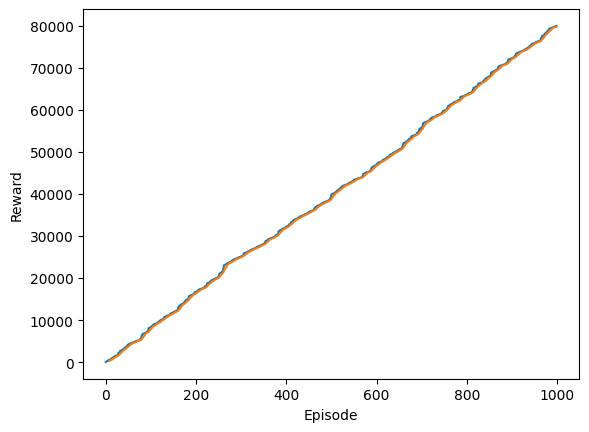

In [ ]:
#agent = a2c(env)
actions, rewards, values, next_obs = a2c(env)

In [ ]:
rewards

[8.924999999999999,
 28.815000000000005,
 -16.235,
 35.81333333333333,
 -11.545833333333334,
 32.56916666666667,
 8.925,
 7.350000000000001,
 5.2261363636363605,
 19.42636363636364,
 7.140000000000001,
 -15.045000000000002,
 3.57,
 10.184999999999999,
 4.013863636363634,
 15.432136363636367,
 5.064937499999999,
 56.339062500000004,
 3.57,
 53.55,
 -43.96388888888889,
 82.78763888888888,
 -68.60506578947368,
 12.266003289473684,
 3.57,
 8.255625,
 44.401875000000004,
 -38.3061,
 78.8256,
 -47.510749999999994,
 3.5700000000000003,
 10.16076923076923,
 54.69423076923077,
 -47.599999999999994,
 64.40875,
 -33.691874999999996,
 3.57,
 6.961499999999999,
 7.69428947368421,
 162.05921052631575,
 -156.93719999999996,
 129.71594999999996,
 0,
 3.57,
 11.067,
 6.485499999999998,
 239.4875,
 -237.20666666666668,
 3.57,
 15.271666666666665,
 23.99833333333333,
 -25.96363636363636,
 24.016363636363636,
 -14.195335968379446,
 3.57,
 9.265,
 18.808181818181822,
 25.221818181818186,
 49.78875000000001

In [ ]:
next_obs

[array([ 1.57064822e+02,  1.90807633e+02,  6.28684082e+01, -2.00000000e-02,
         2.14200000e+02,  2.40000000e+01]),
 array([163.06086122, 184.7412396 ,  58.41941637,   0.88847194,
        264.18      ,   7.        ]),
 array([ 1.41366931e+02,  1.84875675e+02,  5.66392573e+01, -2.00000000e-02,
         4.51605000e+02,  2.10000000e+01]),
 array([171.82770271, 181.44565277,  51.88105692,   0.9144005 ,
        515.865     ,   9.        ]),
 array([ 1.39268180e+02,  1.96933971e+02,  4.99925380e+01, -2.00000000e-02,
         6.40815000e+02,  1.40000000e+01]),
 array([176.9692356 , 193.29615165,  46.68621044,   0.88710415,
        705.075     ,   9.        ]),
 array([ 1.64441057e+02,  1.84185063e+02,  5.99630439e+01, -2.00000000e-02,
         1.24950000e+02,  1.40000000e+01]),
 array([ 1.62096210e+02,  1.95695203e+02,  6.07037573e+01, -2.00000000e-02,
         2.76675000e+02,  1.70000000e+01]),
 array([ 1.66976902e+02,  1.89315372e+02,  6.89308969e+01, -2.00000000e-02,
         4.7302500

In [ ]:
import numpy as np

In [ ]:
arr = np.array(next_obs)
heartrate, systolic_bp, diastolic_bp, spo2, calories, duration = np.hsplit(arr, 6)

In [ ]:
df = pd.DataFrame(data=[actions,duration, rewards, heartrate, systolic_bp, diastolic_bp, spo2, calories],  index=None, columns=None).transpose()
df.columns = ["Actions","Duration(Mins)", "Rewards", "Heartrate(BPM)", "Systolic BP", "Diastolic BP", "SpO2", "Calories Burnt"]
df

,Actions,Duration(Mins),Rewards,Heartrate(BPM),Systolic BP,Diastolic BP,SpO2,Calories Burnt
0,4,[24.0],8.925,[157.06482180644895],[190.8076325931953],[62.86840824209216],[-0.02],[214.2]
1,6,[7.0],28.815,[163.06086122281712],[184.74123959900484],[58.4194163725484],[0.8884719429442709],[264.18]
2,4,[21.0],-16.235,[141.36693106016654],[184.87567535582036],[56.639257262340415],[-0.02],[451.605]
3,6,[9.0],35.813333,[171.82770271250396],[181.44565276551018],[51.881056918581244],[0.9144005021425632],[515.865]
4,4,[14.0],-11.545833,[139.26818025452133],[196.93397135478529],[49.99253799346944],[-0.02],[640.815]
...,...,...,...,...,...,...,...,...
5995,6,[7.0],17.34,[171.9137001404921],[139.5428287782858],[63.92532657082168],[0.9314308183085028],[146.37]
5996,4,[21.0],-5.015,[149.97899249981765],[169.86423172378127],[69.84332890874043],[-0.02],[333.795]
5997,6,[11.0],21.59,[179.3130216491293],[166.83224507303962],[67.6473851630086],[0.928324861951217],[412.33500000000004]
5998,6,[26.0],-14.485962,[173.8344850189433],[163.5108813107636],[63.95804770645814],[0.9045401026287112],[597.975]


In [ ]:
df.dtypes

Actions           object
Duration(Mins)    object
Rewards           object
Heartrate(BPM)    object
Systolic BP       object
Diastolic BP      object
SpO2              object
Calories Burnt    object
dtype: object

In [ ]:
df['Actions'] = df['Actions'].astype(str)
df['Duration(Mins)'] = df['Duration(Mins)'].astype(float)
df['Rewards'] = df['Rewards'].astype(str).astype(float)
df['Heartrate(BPM)'] = df['Heartrate(BPM)'].astype(float)
df['Systolic BP'] = df['Systolic BP'].astype(float)
df['Diastolic BP'] = df['Diastolic BP'].astype(float)
df['SpO2'] = df['SpO2'].astype(float)
df['Calories Burnt'] = df['Calories Burnt'].astype(float)

In [ ]:
df.dtypes

Actions            object
Duration(Mins)    float64
Rewards           float64
Heartrate(BPM)    float64
Systolic BP       float64
Diastolic BP      float64
SpO2              float64
Calories Burnt    float64
dtype: object

In [ ]:
df['Heartrate(BPM)'] = df['Heartrate(BPM)'].round(0)
df['Actions'] = df['Actions'].replace(['0','1','2','3','4','5','6'], ["Rest","Walk","Aerobic walk",  "Hiit walk", "Run", "Cycle", "Weightlift"])
df['Systolic BP'] = 90 + (df['Systolic BP'] - min(df['Systolic BP']))*90/(max(df['Systolic BP']) - min(df['Systolic BP']))
df['Systolic BP'] = 60 + (df['Systolic BP'] - min(df['Systolic BP']))*60/(max(df['Systolic BP']) - min(df['Systolic BP']))
df

,Actions,Duration(Mins),Rewards,Heartrate(BPM),Systolic BP,Diastolic BP,SpO2,Calories Burnt
0,Run,24.0,8.925000,157.0,104.101552,62.868408,-0.020000,214.200
1,Weightlift,7.0,28.815000,163.0,101.620358,58.419416,0.888472,264.180
2,Run,21.0,-16.235000,141.0,101.675343,56.639257,-0.020000,451.605
3,Weightlift,9.0,35.813333,172.0,100.272441,51.881057,0.914401,515.865
4,Run,14.0,-11.545833,139.0,106.607264,49.992538,-0.020000,640.815
...,...,...,...,...,...,...,...,...
5995,Weightlift,7.0,17.340000,172.0,83.133913,63.925327,0.931431,146.370
5996,Run,21.0,-5.015000,150.0,95.535565,69.843329,-0.020000,333.795
5997,Weightlift,11.0,21.590000,179.0,94.295462,67.647385,0.928325,412.335
5998,Weightlift,26.0,-14.485962,174.0,92.937003,63.958048,0.904540,597.975


In [ ]:
import math

In [ ]:
for i in range(6000):
  df['Workout_plan']= math.floor(i/5) + 1

In [ ]:
for i in range(6000):
  df['Workout_plan'][i]= math.floor(i/5) + 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-214-5b7af03ea2fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Workout_plan'][i]= math.floor(i/5) + 1


In [ ]:
df

,Actions,Duration(Mins),Rewards,Heartrate(BPM),Systolic BP,Diastolic BP,SpO2,Calories Burnt,Workout_plan
0,Run,24.0,8.925000,157.0,104.101552,62.868408,-0.020000,214.200,1
1,Weightlift,7.0,28.815000,163.0,101.620358,58.419416,0.888472,264.180,1
2,Run,21.0,-16.235000,141.0,101.675343,56.639257,-0.020000,451.605,1
3,Weightlift,9.0,35.813333,172.0,100.272441,51.881057,0.914401,515.865,1
4,Run,14.0,-11.545833,139.0,106.607264,49.992538,-0.020000,640.815,1
...,...,...,...,...,...,...,...,...,...
5995,Weightlift,7.0,17.340000,172.0,83.133913,63.925327,0.931431,146.370,1200
5996,Run,21.0,-5.015000,150.0,95.535565,69.843329,-0.020000,333.795,1200
5997,Weightlift,11.0,21.590000,179.0,94.295462,67.647385,0.928325,412.335,1200
5998,Weightlift,26.0,-14.485962,174.0,92.937003,63.958048,0.904540,597.975,1200


In [ ]:
#Risky conditions
def risky_conditions(heartrate, sys_bp, dia_bp, spo2):
  heart_rate = (heartrate < safe_zone_min) or (heartrate > safe_zone_max)
  sys_bp = (sys_bp > hyper2_sys_min) or (sys_bp < normal_sys_min)
  dia_bp = (dia_bp > hyper2_dia_min) or (dia_bp < normal_dia_min)
  if(gender == 1):
    spo2 = ((initial_spo2 - spo2) > 0.04) or (spo2 <= risky_spo2_max)
  else:
    spo2 = ((initial_spo2 - spo2) > 0.03) or (spo2 <= risky_spo2_max)
  return (heart_rate or (sys_bp and dia_bp) or spo2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for i in range(6000):
  df['Alarm']= risky_conditions(df['Heartrate(BPM)'][i], df['Systolic BP'][i], df['Diastolic BP'][i], df['SpO2'][i])

In [ ]:
for i in range(6000):
  df['Alarm'][i]= risky_conditions(df['Heartrate(BPM)'][i], df['Systolic BP'][i], df['Diastolic BP'][i], df['SpO2'][i])

<ipython-input-220-0d33a2611489>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Alarm'][i]= risky_conditions(df['Heartrate(BPM)'][i], df['Systolic BP'][i], df['Diastolic BP'][i], df['SpO2'][i])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#path = '/content/drive/My Drive/output_a2c.csv'
#path = '/content/drive/My Drive/output_a2c_new_1.csv'
path = '/content/drive/My Drive/output_a2c_new_2.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Workout plan suggested by A2C model

In [ ]:
#Cumulative rewards per workout
cum_rew  = []
for i in range(0, 5994, 5):
  k = df['Rewards'][i] + df['Rewards'][i+1] + df['Rewards'][i+2] + df['Rewards'][i+3] + df['Rewards'][i+4]
  cum_rew.append(k)

In [ ]:
cum_rew

[45.7725,
 73.49666666666667,
 9.863863636363632,
 133.95613636363635,
 -13.94531250000001,
 45.66625,
 85.23375,
 146.59312499999996,
 -12.584249999999997,
 27.608,
 11.42572463768116,
 35.827499999999986,
 590.8349999999999,
 -535.9644230769229,
 127.92786057692307,
 29.749999999999996,
 114.23999999999998,
 21.419999999999998,
 23.403333333333336,
 139.10604166666664,
 233.760625,
 -160.395,
 91.035,
 46.85625,
 74.52374999999999,
 23.65125000000001,
 373.25624999999997,
 -243.98606060606056,
 17.75912727272728,
 48.195000000000014,
 37.009,
 176.33155555555555,
 -127.44899999999997,
 16.998891304347822,
 505.23260869565223,
 42.177586206896564,
 20.68271739130435,
 74.19003260869565,
 93.11750000000002,
 276.8237500000001,
 20.847884615384615,
 30.865624999999998,
 191.59000000000003,
 -134.2915,
 89.07149999999999,
 28.546305555555556,
 117.17249999999996,
 21.3084375,
 73.185,
 -23.820284090909087,
 17.771761363636358,
 298.2572727272727,
 79.25399999999999,
 79.65562500000001,
 

In [ ]:
max(cum_rew)

881.535

In [ ]:
k = cum_rew.index(max(cum_rew))
k

844

In [ ]:
calories = df['Calories Burnt'][(k*5)-1]
calories

357.0

In [ ]:
workout = []
duration = []
for i in range(5):
  workout.append(df['Actions'][(k*5)+i-5])
  duration.append(df['Duration(Mins)'][(k*5)+i-5])

In [ ]:
workout

['Run', 'Weightlift', 'Weightlift', 'Run', 'Run']

In [ ]:
duration

[11.0, 8.0, 9.0, 12.0, 28.0]

In [ ]:
workout_plan = {'Exercise': workout,
        'Time': duration}
workout_plan = pd.DataFrame(workout_plan)

In [ ]:
workout_plan

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Exercise,Time
0,Run,11.0
1,Weightlift,8.0
2,Weightlift,9.0
3,Run,12.0
4,Run,28.0



Customised PPO Model

In [ ]:
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)

        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)

    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()

In [ ]:
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gym
import numpy as np

env = SmartCoach()
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
                    alpha=alpha, n_epochs=n_epochs,
                    input_dims=env.observation_space.shape)
n_games = 300

best_score = 0
#best_score = env.reward_range[0]
score_history = []
actions = []
next_obs = []
rewards = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
  observation = env.reset()
  done = False
  score = 0
  while not done:
    action, prob, val = agent.choose_action(observation)
    #observation_, reward, done = env.step(action)
    observation_, reward, done, info = env.step(action)
    actions.append(action)
    rewards.append(reward)
    next_obs.append(observation_)
    n_steps += 1
    score += reward
    agent.remember(observation, action, prob, val, reward, done)
    if n_steps % N == 0:
      agent.learn()
      learn_iters += 1
    observation = observation_
  score_history.append(score)
  avg_score = np.mean(score_history[-100:])

  if avg_score > best_score:
    best_score = avg_score

  print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', n_steps, 'learning_steps', learn_iters)
  x = [i+1 for i in range(len(score_history))]


  # Plot results
  #smoothed_rewards = pd.Series.rolling(pd.Series(reward), 10).mean()
  #smoothed_rewards = [elem for elem in smoothed_rewards]
  plt.plot(score_history)
  #plt.plot(smoothed_rewards)
  #plt.plot()
  plt.xlabel('Episode')
  plt.ylabel('Reward')
plt.show()

episode 0 score 258001.2 avg score 258001.2 time_steps 1000 learning_steps 50
episode 1 score 183165.7 avg score 220583.4 time_steps 2000 learning_steps 100
episode 2 score 146830.0 avg score 195999.0 time_steps 3000 learning_steps 150
episode 3 score 32538.4 avg score 155133.8 time_steps 4000 learning_steps 200
episode 4 score 290144.6 avg score 182136.0 time_steps 5000 learning_steps 250
episode 5 score 15749.9 avg score 154405.0 time_steps 6000 learning_steps 300
episode 6 score -2578.0 avg score 131978.8 time_steps 7000 learning_steps 350
episode 7 score 109954.7 avg score 129225.8 time_steps 8000 learning_steps 400
episode 8 score 46791.6 avg score 120066.4 time_steps 9000 learning_steps 450
episode 9 score -997.0 avg score 107960.1 time_steps 10000 learning_steps 500
episode 10 score 317829.9 avg score 127039.2 time_steps 11000 learning_steps 550
episode 11 score 34042.0 avg score 119289.4 time_steps 12000 learning_steps 600
episode 12 score 54204.6 avg score 114282.9 time_steps 

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


episode 0 score -5000.0 avg score -5000.0 time_steps 100 learning_steps 20
episode 1 score -4400.0 avg score -4700.0 time_steps 200 learning_steps 40
episode 2 score -4500.0 avg score -4633.3 time_steps 300 learning_steps 60
episode 3 score -4600.0 avg score -4625.0 time_steps 400 learning_steps 80
episode 4 score -4600.0 avg score -4620.0 time_steps 500 learning_steps 100
episode 5 score -5300.0 avg score -4733.3 time_steps 600 learning_steps 120
episode 6 score -4800.0 avg score -4742.9 time_steps 700 learning_steps 140
episode 7 score -5200.0 avg score -4800.0 time_steps 800 learning_steps 160
episode 8 score -4600.0 avg score -4777.8 time_steps 900 learning_steps 180
episode 9 score -4600.0 avg score -4760.0 time_steps 1000 learning_steps 200
episode 10 score -5500.0 avg score -4827.3 time_steps 1100 learning_steps 220
episode 11 score -4800.0 avg score -4825.0 time_steps 1200 learning_steps 240
episode 12 score -4600.0 avg score -4807.7 time_steps 1300 learning_steps 260
episode 1

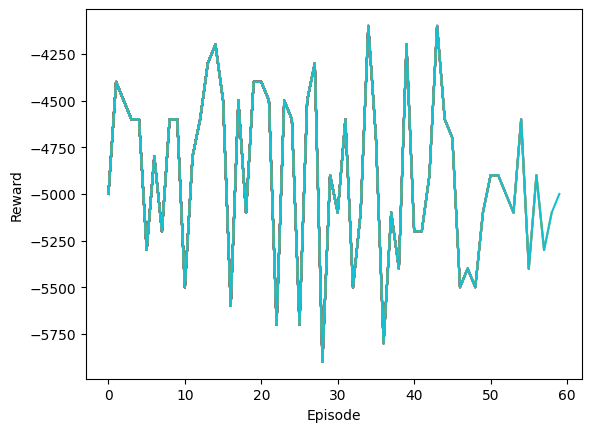

In [ ]:
import gym
import numpy as np

env = SmartCoach()
N = 5
batch_size = 5
n_epochs = 4
alpha = 0.0003
agent = Agent(n_actions=env.action_space.n, batch_size=batch_size,
                    alpha=alpha, n_epochs=n_epochs,
                    input_dims=env.observation_space.shape)
n_games = 60

best_score = 0
#best_score = env.reward_range[0]
score_history = []
actions = []
next_obs = []
rewards = []

learn_iters = 0
avg_score = 0
n_steps = 0

for i in range(n_games):
  observation = env.reset()
  done = False
  score = 0
  while not done:
    action, prob, val = agent.choose_action(observation)
    observation_, reward, done = env.step(action)
    #observation_, reward, done, info = env.step(action)
    actions.append(action)
    rewards.append(reward)
    next_obs.append(observation_)
    n_steps += 1
    score += reward
    agent.remember(observation, action, prob, val, reward, done)
    if n_steps % N == 0:
      agent.learn()
      learn_iters += 1
    observation = observation_
  score_history.append(score)
  avg_score = np.mean(score_history[-100:])

  if avg_score > best_score:
    best_score = avg_score

  print('episode', i, 'score %.1f' % score, 'avg score %.1f' % avg_score,
                'time_steps', n_steps, 'learning_steps', learn_iters)
  x = [i+1 for i in range(len(score_history))]


  # Plot results
  #smoothed_rewards = pd.Series.rolling(pd.Series(reward), 10).mean()
  #smoothed_rewards = [elem for elem in smoothed_rewards]
  plt.plot(score_history)
  #plt.plot(smoothed_rewards)
  #plt.plot()
  plt.xlabel('Episode')
  plt.ylabel('Reward')
plt.show()

In [ ]:
arr = np.array(next_obs)
heartrate, systolic_bp, diastolic_bp, spo2, calories, duration = np.hsplit(arr, 6)

In [ ]:
df = pd.DataFrame(data=[actions, duration, rewards, heartrate, systolic_bp, diastolic_bp, spo2, calories],  index=None, columns=None).transpose()
df.columns = ["Actions","Duration(Mins)", "Rewards", "Heartrate(BPM)", "Systolic BP", "Diastolic BP", "SpO2", "Calories Burnt"]
df

,Actions,Duration(Mins),Rewards,Heartrate(BPM),Systolic BP,Diastolic BP,SpO2,Calories Burnt
0,3,[0.0],-100,[131.89058153021207],[98.63175701478934],[65.41888985221095],[0.9720471457577737],[0.0]
1,4,[0.0],0,[131.89058153021207],[98.63175701478934],[65.41888985221095],[0.9720471457577737],[0.0]
2,2,[0.0],-100,[131.89058153021207],[98.63175701478934],[65.41888985221095],[0.9720471457577737],[0.0]
3,4,[0.0],0,[131.89058153021207],[98.63175701478934],[65.41888985221095],[0.9720471457577737],[0.0]
4,3,[0.0],-100,[131.89058153021207],[98.63175701478934],[65.41888985221095],[0.9720471457577737],[0.0]
...,...,...,...,...,...,...,...,...
5995,3,[0.0],-100,[122.26566836433989],[105.26347189486242],[75.08857285178242],[0.9992787149837089],[0.0]
5996,3,[0.0],0,[122.26566836433989],[105.26347189486242],[75.08857285178242],[0.9992787149837089],[0.0]
5997,3,[0.0],0,[122.26566836433989],[105.26347189486242],[75.08857285178242],[0.9992787149837089],[0.0]
5998,3,[0.0],0,[122.26566836433989],[105.26347189486242],[75.08857285178242],[0.9992787149837089],[0.0]


In [ ]:
df.dtypes

Actions           object
Duration(Mins)    object
Rewards           object
Heartrate(BPM)    object
Systolic BP       object
Diastolic BP      object
SpO2              object
Calories Burnt    object
dtype: object

In [ ]:
df['Actions'] = df['Actions'].astype(str)
df['Duration(Mins)'] = df['Duration(Mins)'].astype(float)
df['Rewards'] = df['Rewards'].astype(str).astype(float)
df['Heartrate(BPM)'] = df['Heartrate(BPM)'].astype(float)
df['Systolic BP'] = df['Systolic BP'].astype(float)
df['Diastolic BP'] = df['Diastolic BP'].astype(float)
df['SpO2'] = df['SpO2'].astype(float)
df['Calories Burnt'] = df['Calories Burnt'].astype(float)

In [ ]:
df.dtypes

Actions            object
Duration(Mins)    float64
Rewards           float64
Heartrate(BPM)    float64
Systolic BP       float64
Diastolic BP      float64
SpO2              float64
Calories Burnt    float64
dtype: object

In [ ]:
df['Actions'] = df['Actions'].replace(['0','1','2','3','4','5','6'], ["Rest","Walk","Aerobic walk",  "Hiit walk", "Run", "Cycle", "Weightlift"])
df

,Actions,Duration(Mins),Rewards,Heartrate(BPM),Systolic BP,Diastolic BP,SpO2,Calories Burnt
0,Hiit walk,0.0,-100.0,131.890582,98.631757,65.418890,0.972047,0.0
1,Run,0.0,0.0,131.890582,98.631757,65.418890,0.972047,0.0
2,Aerobic walk,0.0,-100.0,131.890582,98.631757,65.418890,0.972047,0.0
3,Run,0.0,0.0,131.890582,98.631757,65.418890,0.972047,0.0
4,Hiit walk,0.0,-100.0,131.890582,98.631757,65.418890,0.972047,0.0
...,...,...,...,...,...,...,...,...
5995,Hiit walk,0.0,-100.0,122.265668,105.263472,75.088573,0.999279,0.0
5996,Hiit walk,0.0,0.0,122.265668,105.263472,75.088573,0.999279,0.0
5997,Hiit walk,0.0,0.0,122.265668,105.263472,75.088573,0.999279,0.0
5998,Hiit walk,0.0,0.0,122.265668,105.263472,75.088573,0.999279,0.0


In [ ]:
df['Heartrate(BPM)'] = df['Heartrate(BPM)'].round(0)
df['Actions'] = df['Actions'].replace(['1','2','3','4','5','6','7'], ["Rest","Walk","Aerobic walk",  "Hiit walk", "Run", "Cycle", "Weightlift"])
df['Systolic BP'] = 90 + (df['Systolic BP'] - min(df['Systolic BP']))*90/(max(df['Systolic BP']) - min(df['Systolic BP']))
df['Systolic BP'] = 60 + (df['Systolic BP'] - min(df['Systolic BP']))*60/(max(df['Systolic BP']) - min(df['Systolic BP']))
df

,Actions,Duration(Mins),Rewards,Heartrate(BPM),Systolic BP,Diastolic BP,SpO2,Calories Burnt
0,Hiit walk,0.0,-100.0,132.0,76.906907,65.418890,0.972047,0.0
1,Run,0.0,0.0,132.0,76.906907,65.418890,0.972047,0.0
2,Aerobic walk,0.0,-100.0,132.0,76.906907,65.418890,0.972047,0.0
3,Run,0.0,0.0,132.0,76.906907,65.418890,0.972047,0.0
4,Hiit walk,0.0,-100.0,132.0,76.906907,65.418890,0.972047,0.0
...,...,...,...,...,...,...,...,...
5995,Hiit walk,0.0,-100.0,122.0,90.298292,75.088573,0.999279,0.0
5996,Hiit walk,0.0,0.0,122.0,90.298292,75.088573,0.999279,0.0
5997,Hiit walk,0.0,0.0,122.0,90.298292,75.088573,0.999279,0.0
5998,Hiit walk,0.0,0.0,122.0,90.298292,75.088573,0.999279,0.0


In [ ]:
import math

In [ ]:
for i in range(6000):
  df['Workout_plan'] = math.floor(i/5) + 1

In [ ]:
for i in range(6000):
  df['Workout_plan'][i] = math.floor(i/5) + 1

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-344-7855e1da68b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Workout_plan'][i] = math.floor(i/5) + 1


In [ ]:
df

,Actions,Duration(Mins),Rewards,Heartrate(BPM),Systolic BP,Diastolic BP,SpO2,Calories Burnt,Workout_plan
0,Hiit walk,0.0,-100.0,132.0,76.906907,65.418890,0.972047,0.0,1
1,Run,0.0,0.0,132.0,76.906907,65.418890,0.972047,0.0,1
2,Aerobic walk,0.0,-100.0,132.0,76.906907,65.418890,0.972047,0.0,1
3,Run,0.0,0.0,132.0,76.906907,65.418890,0.972047,0.0,1
4,Hiit walk,0.0,-100.0,132.0,76.906907,65.418890,0.972047,0.0,1
...,...,...,...,...,...,...,...,...,...
5995,Hiit walk,0.0,-100.0,122.0,90.298292,75.088573,0.999279,0.0,1200
5996,Hiit walk,0.0,0.0,122.0,90.298292,75.088573,0.999279,0.0,1200
5997,Hiit walk,0.0,0.0,122.0,90.298292,75.088573,0.999279,0.0,1200
5998,Hiit walk,0.0,0.0,122.0,90.298292,75.088573,0.999279,0.0,1200


In [ ]:
#Risky conditions
def risky_conditions(heartrate, sys_bp, dia_bp, spo2):
  heart_rate = (heartrate < safe_zone_min) or (heartrate > safe_zone_max)
  sys_bp = (sys_bp > hyper1_sys_min) or (sys_bp < normal_sys_min)
  dia_bp = (dia_bp > hyper1_dia_min) or (dia_bp < normal_dia_min)
  if(gender == 1):
    spo2 = ((initial_spo2 - spo2) > 0.04) or (spo2 <= risky_spo2_max)
  else:
    spo2 = ((initial_spo2 - spo2) > 0.03) or (spo2 <= risky_spo2_max)
  return (heart_rate or sys_bp or dia_bp or spo2)

In [ ]:
for i in range(6000):
  df['Alarm'] = risky_conditions(df['Heartrate(BPM)'][i], df['Systolic BP'][i], df['Diastolic BP'][i], df['SpO2'][i])

In [ ]:
for i in range(6000):
  df['Alarm'][i] = risky_conditions(df['Heartrate(BPM)'][i], df['Systolic BP'][i], df['Diastolic BP'][i], df['SpO2'][i])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-348-785c96b01ffc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Alarm'][i] = risky_conditions(df['Heartrate(BPM)'][i], df['Systolic BP'][i], df['Diastolic BP'][i], df['SpO2'][i])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#path = '/content/drive/My Drive/output_ppo.csv'
#path = '/content/drive/My Drive/output_ppo_new.csv'
#path = '/content/drive/My Drive/output_ppo_new_1.csv'
path = '/content/drive/My Drive/output_ppo_new_2.csv'
with open(path, 'w', encoding = 'utf-8-sig') as f:
  df.to_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Workout suggested by PPO model

In [ ]:
#Cumulative rewards per workout
cum_rew  = []
for i in range(0, 5994, 5):
  k = df['Rewards'][i] + df['Rewards'][i+1] + df['Rewards'][i+2] + df['Rewards'][i+3] + df['Rewards'][i+4]
  cum_rew.append(k)

In [ ]:
cum_rew

[-200.0,
 -400.0,
 -300.0,
 -100.0,
 -300.0,
 -300.0,
 -300.0,
 -100.0,
 -200.0,
 -100.0,
 -200.0,
 -200.0,
 -100.0,
 -300.0,
 -400.0,
 -300.0,
 -300.0,
 -300.0,
 -100.0,
 -300.0,
 -200.0,
 -100.0,
 -100.0,
 -100.0,
 -300.0,
 -200.0,
 0.0,
 -300.0,
 -300.0,
 -400.0,
 -100.0,
 -300.0,
 -300.0,
 -200.0,
 -100.0,
 -300.0,
 -300.0,
 -200.0,
 -300.0,
 -200.0,
 -100.0,
 -200.0,
 -100.0,
 -100.0,
 -300.0,
 -300.0,
 -300.0,
 -200.0,
 -300.0,
 -200.0,
 -300.0,
 -200.0,
 -100.0,
 -200.0,
 -200.0,
 -400.0,
 -200.0,
 -200.0,
 -300.0,
 -100.0,
 -300.0,
 -100.0,
 -200.0,
 -300.0,
 -200.0,
 -400.0,
 -300.0,
 -200.0,
 -200.0,
 -100.0,
 -200.0,
 -300.0,
 -200.0,
 -300.0,
 -100.0,
 -100.0,
 -300.0,
 -300.0,
 -200.0,
 -200.0,
 -100.0,
 -300.0,
 -200.0,
 -300.0,
 -300.0,
 -200.0,
 -300.0,
 -200.0,
 -200.0,
 -400.0,
 -300.0,
 -400.0,
 -400.0,
 -300.0,
 -100.0,
 -300.0,
 -400.0,
 -300.0,
 -100.0,
 -100.0,
 0.0,
 -200.0,
 -300.0,
 -300.0,
 -300.0,
 -100.0,
 0.0,
 -200.0,
 -100.0,
 -200.0,
 -300.0,
 -400.0,
 

In [ ]:
max(cum_rew)

0.0

In [ ]:
k = cum_rew.index(max(cum_rew))
k

20

In [ ]:
calories = df['Calories Burnt'][(k*5)-1]
calories

0.0

In [ ]:
workout = []
duration = []
for i in range(5):
  workout.append(df['Actions'][(k*5)+i-5])
  duration.append(df['Duration(Mins)'][(k*5)+i-5])

In [ ]:
workout

['Hiit walk', 'Hiit walk', 'Hiit walk', 'Hiit walk', 'Hiit walk']

In [ ]:
duration

[0.0, 0.0, 0.0, 0.0, 0.0]

In [ ]:
workout_plan = {'Exercise': workout,
        'Time': duration}
workout_plan = pd.DataFrame(workout_plan)

In [ ]:
workout_plan

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Exercise,Time
0,Hiit walk,0.0
1,Hiit walk,0.0
2,Hiit walk,0.0
3,Hiit walk,0.0
4,Hiit walk,0.0


Model Evaluation will be based on time taken to train and maximum award achieved